# TOMOseq data analysis pipeline

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from venn import venn
import scanpy as sc
import anndata as ad
import seaborn as sns
import math
from scipy.stats import zscore, variation, ttest_ind
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import normalize, scale, MinMaxScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Describe funciton to process de data

In [2]:
def accessData(list_files, list_labels):
    """opens the read/transcript/gene counts of each file"""
    #create empty dictionary to store the dataframes
    dic_dataframes = {}
    #iterate to get the file names
    #make a counter to access the correct label
    count = 0
    for file in list_files:
        #open each file
        data_frame = pd.read_csv(file, sep='\t', compression='gzip', index_col=0)
        #add the dataframe as an element of a dictionary with key the filename
        dic_dataframes[list_labels[count]] = data_frame
        count = count + 1
    
    return dic_dataframes


def saveCSV(dic_data, label):
    """Save dataframes inside dictionary to csv files"""
    for key in dic_data:
        dic_data[key].to_csv(key+'_'+label+'.tsv.gz', sep='\t', compression='gzip')
    
    return print('Files saved')



def normalizeTO(dic_data, factor):
    """Normalize to median/mean/factor
    1. divide by the total reads in each column (normalization)
    2. multiply by the factor of total raeds across sections (scaling)"""
    #make a counter for the smaple number to select the median position
    count = 0
    #make a dictionary to store the normalized datasets
    dic_normal = {}
    #Get each dataframe
    for key in dic_data:
        #get the total transcript counts per section
        data_frame_total = dic_data[key].sum(axis='index')
        #divide each section by the total of the section
        data_frame_normal_s1 = dic_data[key].divide(data_frame_total, axis='columns')
        #multiply by the meadian value 
        data_frame_normal = data_frame_normal_s1.multiply(factor)
        count = count + 1
        #save the dataframe to the dictionary
        dic_normal[key] = data_frame_normal
    
    return dic_normal


def zscores(dic_data):
    """Calculates de z scores for each gene individually"""
    #Create a dictinary to store the dataframes of z scores
    dic_zscores = {}
    for key in dic_data:
        #create a dataframe to store the zscores
        df_zscore = pd.DataFrame(columns = dic_data[key].columns, index = dic_data[key].index)
        #calculate z scores for each gene
        #for that we need to get the info from every row independently and then get the z score
        for index in dic_data[key].index.values:
            #transform the series into list, then to np.array and apply z score funtion from scipy.stats
            #and save it to the Zscore df
            data_gene = np.array(list(dic_data[key].loc[index]))
            df_zscore.loc[index] = zscore(data_gene.astype(float))
        #save the df_zscores to the dictionary
        dic_zscores[key] = df_zscore.astype(float)
    
    return dic_zscores


def scaledZscores(dic_data):
    """Calculates de scaled z scores for each gene individually.
    Normalize the Z score to scaled Z score (-1 to 1)"""
    #Create a dictinary to store the dataframes of z scores
    dic_scaled_zscores = {}
    for key in dic_data:
        #create a dataframe to store the zscores
        df_scaled_zscore = pd.DataFrame(columns = dic_data[key].columns, index = dic_data[key].index)
        #calculate z scores for each gene
        #for that we need to get the info from every row independently and then get the z score
        for index in dic_data[key].index.values:
            ## 1.convert the column value of the dataframe to floats
            float_array = dic_data[key].loc[index].values.astype(float)
            # Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
            float_array = float_array.reshape(-1, 1)
            # 2. create a min max processing object
            min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
            scaled_array = min_max_scaler.fit_transform(float_array)
            # 3. convert the scaled array to dataframe. First reshape the array to the original shape
            scaled_array = scaled_array.reshape(len(dic_data[key].columns.values),)
            df_scaled_zscore.loc[index] = scaled_array
        #save the df_zscores to the dictionary 
        #Use astype(float) to ensure the values are numbers for correct plotting
        dic_scaled_zscores[key] = df_scaled_zscore.astype(float)
    
    return dic_scaled_zscores



## Anna's formulas for hierarchical clustering
def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True', leaf_colors = []):
    """performs hierarchical clustering using linkage and dendogram functions from scipy.cluster.hierarchy package"""
    if len(leaf_colors) > 0:
        hierarchy.set_link_color_palette(leaf_colors)
    df = df.replace(np.nan,0)
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg


def getClusterByColor(dg, labels):
    """given a dendogram and labels, it groups labels by colors in the dendogram (i.e. clusters)"""
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters


def plotHeatmap(dic_data, dg, clusters, figsize, title, type_data, reorganize = False, new_index_order = []):
    """Use the combined clustering to plot the indivudal heatmaps for each sample"""
    #access each dictionary and count the number of samples
    keys = []
    for key in dic_data:
        keys.append(key)      
    #check the number of samples to provide the width ratios
    ratios = [0.5]
    for element in range(len(keys)):
        if element < len(keys)-1:
            ratios.append(3)
        if element == len(keys)-1:
            ratios.append(4)
    # plot multiple plots with plt.sublots. axs is a list of all the subplots. Plot as many plots as samples plus 
    # one for the cluster label
    fig, axs = plt.subplots(nrows = 1, ncols = len(keys)+1, sharey='row', gridspec_kw={'width_ratios': ratios}, figsize = figsize);
    #make a count to access the correct plot
    count = 0
    for key in dic_data:
        if reorganize == False:
            #use dg['leaves'] indexes to organize the data to plot
            data_plot = dic_data[key].loc[dic_data[key].index[dg['leaves']]]
        if reorganize == True:
            data_plot = dic_data[key].reindex(index = new_index_order)
        # to plot I use ax.imshow
        im = axs[count+1].imshow(data_plot, aspect='auto', interpolation='none', cmap='viridis')
        # Hide grid lines
        axs[count+1].grid(False)
        # add labels
        axs[count+1].set_title(key)
        #remove ticks on the y axis
        axs[count+1].tick_params(top=False, bottom=True, left=False, right=False)
        #add 1 to the count to go to next sample
        count = count + 1
        
    
    #create the colour bar and label it, we use the last image (im)
    #cax = divider.append_axes('left', size='5%', pad=0.05)
    cb = fig.colorbar(im, orientation='vertical', shrink = 0.3)
    cb.set_label(type_data)

    # Make a big plot in order to craete shared axis labels
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Sections Proximal-Distal (knee to ankle)")

    #Introduce the cluster bar
    #make the variable bottom to 0, which indicates were the cluster starts
    bottom = 0
    for cluster in clusters:
        if int(cluster) < len(clusters)-1: 
            #get the height of the cluster
            height = len(clusters[cluster])
            axs[0].bar(-0.5, height = height, bottom=bottom-0.5, width=0.2, align='center')
            #add cluster labels
            axs[0].text(-0.5, bottom-0.5+height/2, str(int(cluster)+1), ha='center', va='center')
            #add the length of the current cluster to the bottom variable for the next cluster start
            bottom = bottom + len(clusters[cluster])

        #I add -1 to the last bottom, otherwise the plot gets out of the grid
        if int(cluster) == len(clusters)-1:
            height = len(clusters[cluster])
            axs[0].bar(-0.5, height = height, bottom=bottom-0.5, width=0.2, align='center')
            #add cluster label
            axs[0].text(-0.5, bottom-0.5+height/2, str(int(cluster)+1), ha='center', va='center')

    #axs[0].set_ylim(0,bottom)  

    #remove ticks and plot frame from the cluster bar
    axs[0].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axs[0].axis('off')
    #add the figure title
    fig.suptitle(title, fontsize=13)
    
    
    
def ClusterGeneNames(data, clusters, dg, file_name):
    """Creates a txt file that contains the gene ids of each cluster to use for GO search"""
    #create the file
    #We declared the variable f to open a file . Open takes 2 arguments, the file that we want 
    #to open and a string that represents the kinds of permission or operation we want to do on the file
    #Here, we used "w" letter in our argument, which indicates write and will create a file if it does 
    #not exist in library
    #Plus sign indicates both read and write.
    f = open(file_name,"w+")
    #change the index order of the data in the heatmap
    data = data.index[dg['leaves']]
    #access the gene info of each cluster
    start = 0
    end = 0
    for key in clusters:
        #writte the cluster name
        #The output we want to iterate in the file is "Cluster ", which we declare with write function and 
        #then percent d (displays integer)
        #So basically we are putting in the line number that we are writing (key + 1), then putting it in a carriage 
        #return and a new line character
        f.write('\nCluster %d\r\n' % (int(key)+1))
        #go through each index to substract the gene id and write it on the file
        end = end + len(clusters[key])
        for element in data[start:end]:
            #split the index and save the gene id and new line
            info = element.split('_')
            f.write(str(info[1]) + '\n')
        start = start + len(clusters[key])
    #close the file when done
    f.close()
    
    return print(file_name)


def plotHeatmapAnn(dic_data, dg, clusters, figsize, title, type_data, g_annotate, reorganize = False, new_index_order = []):
    """Use the combined clustering to plot the indivudal heatmaps for each sample"""
    #access each dictionary and count the number of samples
    keys = []
    for key in dic_data:
        keys.append(key)      
    #check the number of samples to provide the width ratios
    ratios = [0.5]
    for element in range(len(keys)):
        if element < len(keys)-1:
            ratios.append(3)
        if element == len(keys)-1:
            ratios.append(4)
    # plot multiple plots with plt.sublots. axs is a list of all the subplots. Plot as many plots as samples plus 
    # one for the cluster label
    fig, axs = plt.subplots(nrows = 1, ncols = len(keys)+1, sharey='row', gridspec_kw={'width_ratios': ratios}, figsize = figsize);
    #make a count to access the correct plot
    count = 0
    for key in dic_data:
        if reorganize == False:
            #use dg['leaves'] indexes to organize the data to plot
            data_plot = dic_data[key].loc[dic_data[key].index[dg['leaves']]]
        if reorganize == True:
            data_plot = dic_data[key].reindex(index = new_index_order)
        # to plot I use ax.imshow
        im = axs[count+1].imshow(data_plot, aspect='auto', interpolation='none', cmap='viridis')
        # Hide grid lines
        axs[count+1].grid(False)
        # add labels
        axs[count+1].set_title(key)
        #remove ticks on the y axis
        axs[count+1].set_yticks([])
        axs[count+1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
        #add 1 to the count to go to next sample
        count = count + 1
    
    axs[count].set_yticks([i for i, g in enumerate(data_plot.index[::]) if g.rsplit('_')[1] in g_annotate])
    axs[count].set_yticklabels([g.rsplit('_')[1] for g in data_plot.index[::] if g.rsplit('_')[1] in g_annotate])
        
    
    #create the colour bar and label it, we use the last image (im)
    #cax = divider.append_axes('left', size='5%', pad=0.05)
    cb = fig.colorbar(im, orientation='vertical', shrink = 0.3)
    cb.set_label(type_data)

    # Make a big plot in order to craete shared axis labels
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Sections Proximal-Distal (knee to ankle)")

    #Introduce the cluster bar
    #make the variable bottom to 0, which indicates were the cluster starts
    bottom = 0
    for cluster in clusters:
        if int(cluster) < len(clusters)-1: 
            #get the height of the cluster
            height = len(clusters[cluster])
            axs[0].bar(-0.5, height = height, bottom=bottom-0.5, width=0.2, align='center')
            #add cluster labels
            axs[0].text(-0.5, bottom-0.5+height/2, str(int(cluster)+1), ha='center', va='center')
            #add the length of the current cluster to the bottom variable for the next cluster start
            bottom = bottom + len(clusters[cluster])

        #I add -1 to the last bottom, otherwise the plot gets out of the grid
        if int(cluster) == len(clusters)-1:
            height = len(clusters[cluster])
            axs[0].bar(-0.5, height = height, bottom=bottom-0.5, width=0.2, align='center')
            #add cluster label
            axs[0].text(-0.5, bottom-0.5+height/2, str(int(cluster)+1), ha='center', va='center')

    #axs[0].set_ylim(0,bottom)  

    #remove ticks and plot frame from the cluster bar
    axs[0].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axs[0].axis('off')
    #add the figure title
    fig.suptitle(title, fontsize=13)




## PCA maps of sections 

In [3]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
#path = '/Volumes/Clara/Data/re-map_MOUSE-E102/'
path=''
file_names = [path + 'Muscle_1_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz', 
             path + 'Muscle_2_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz',
             path + 'Muscle_3_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz',
             path + 'Muscle_4_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz']
labels = ['Muscle_1', 'Muscle_2', 'Muscle_3', 'Muscle_4']


#use accessData() function to obtain a dictonary with each dataset with labels as key
data_genes_filtered_normal= accessData(file_names, labels)
data_genes_filtered_normal

{'Muscle_1':                                                   001         002         003  \
 new_gene                                                                        
 ENSMUSG00000000031_H19_lincRNA             525.703164  648.449576  766.204651   
 ENSMUSG00000000056_Narf_ProteinCoding        8.474564    2.703446    0.000000   
 ENSMUSG00000000078_Klf6_ProteinCoding        5.649019    2.703446    4.801128   
 ENSMUSG00000000085_Scmh1_ProteinCoding       2.824165    0.000000    1.599985   
 ENSMUSG00000000088_Cox5a_ProteinCoding     164.952214  166.130244  184.962088   
 ...                                               ...         ...         ...   
 ENSMUSG00000115987_Vps28_ProteinCoding      16.955342   21.646076    9.605776   
 ENSMUSG00000116564_Riok2_ProteinCoding       5.649019    5.407553    1.599985   
 ENSMUSG00000116590_AC154200.1_lincRNA      104.956104   75.947139   56.233243   
 ENSMUSG00000117924_Tmem223_ProteinCoding     5.649019    0.000000   16.017459   
 ENS

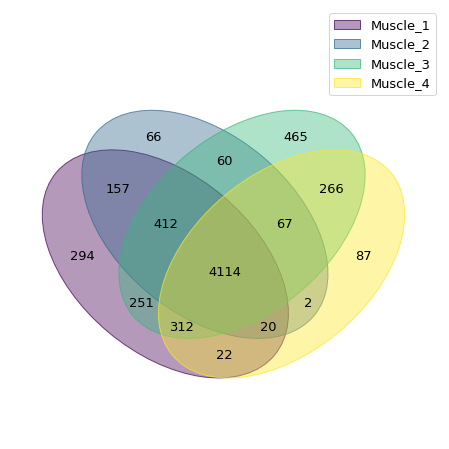

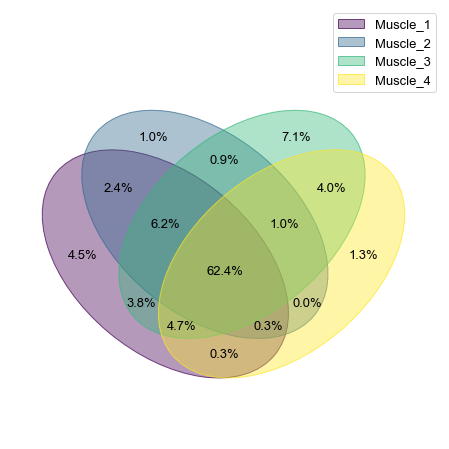

In [4]:
#Venn diagram without TOMOseq filter
samples = {
    "Muscle_1": set(list(data_genes_filtered_normal['Muscle_1'].index)),
    "Muscle_2": set(list(data_genes_filtered_normal['Muscle_2'].index)), 
    "Muscle_3": set(list(data_genes_filtered_normal['Muscle_3'].index)), 
    "Muscle_4": set(list(data_genes_filtered_normal['Muscle_4'].index)),
}

venn(samples)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 7
plt.savefig('Venn_Ngenes.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()
venn(samples, fmt="{percentage:.1f}%")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 7
plt.savefig('Venn_Pgenes.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

In [5]:
pd.DataFrame.from_dict(samples, orient='index').T.to_excel("data_venn.xlsx")

In [6]:
#calculate the szcores
data_zscores = zscores(data_genes_filtered_normal)



In [7]:
data_zscores_re={}
for key in data_zscores:
    data_zscores_re[key] = data_zscores[key].add_suffix('_'+key)
    print(key, len(list(data_zscores[key].columns)))
data_zscores_re[key]

Muscle_1 37
Muscle_2 45
Muscle_3 46
Muscle_4 43


001_Muscle_4  002_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 0.530953      0.160581   
ENSMUSG00000000056_Narf_ProteinCoding         -0.615313      0.369567   
ENSMUSG00000000078_Klf6_ProteinCoding         -1.562245     -1.181947   
ENSMUSG00000000085_Scmh1_ProteinCoding        -1.433953     -0.819454   
ENSMUSG00000000088_Cox5a_ProteinCoding        -1.565216      1.260661   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding        -1.577749      0.235319   
ENSMUSG00000116590_AC154200.1_lincRNA         -2.592039     -0.440790   
ENSMUSG00000117679_Apbb3_ProteinCoding        -0.364993     -0.221151   
ENSMUSG00000117924_Tmem223_ProteinCoding      -1.317433      0.585311   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -1.127529      1.007312   

                                           003_Muscle_4  004_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 0.932760      2.027773   
ENSMUSG00000000056_Narf_ProteinCoding          1.278004      1.258545   
ENSMUSG00000000078_Klf6_ProteinCoding         -0.583298      1.785380   
ENSMUSG00000000085_Scmh1_ProteinCoding        -0.247735     -0.353168   
ENSMUSG00000000088_Cox5a_ProteinCoding         1.862015      0.669165   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding         1.277714      1.246685   
ENSMUSG00000116590_AC154200.1_lincRNA         -0.569041      0.624357   
ENSMUSG00000117679_Apbb3_ProteinCoding         1.710767     -1.412773   
ENSMUSG00000117924_Tmem223_ProteinCoding       0.018801      1.191779   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -0.212185     -0.502116   

                                           005_Muscle_4  006_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 1.276972      1.551331   
ENSMUSG00000000056_Narf_ProteinCoding          0.760358     -0.824214   
ENSMUSG00000000078_Klf6_ProteinCoding         -0.217032     -0.700582   
ENSMUSG00000000085_Scmh1_ProteinCoding         0.739689     -1.433953   
ENSMUSG00000000088_Cox5a_ProteinCoding         1.263980      1.496008   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding        -0.085616      0.344286   
ENSMUSG00000116590_AC154200.1_lincRNA          0.909792     -0.474890   
ENSMUSG00000117679_Apbb3_ProteinCoding         0.080218     -1.058323   
ENSMUSG00000117924_Tmem223_ProteinCoding      -0.177108     -0.123811   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -0.708463     -0.859035   

                                           007_Muscle_4  008_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 1.133426      0.669879   
ENSMUSG00000000056_Narf_ProteinCoding          0.610689      0.356962   
ENSMUSG00000000078_Klf6_ProteinCoding          0.550389     -0.427664   
ENSMUSG00000000085_Scmh1_ProteinCoding         0.271629      1.622287   
ENSMUSG00000000088_Cox5a_ProteinCoding         0.941684      0.918969   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding         0.425157      1.523837   
ENSMUSG00000116590_AC154200.1_lincRNA          1.146220     -1.024769   
ENSMUSG00000117679_Apbb3_ProteinCoding        -1.127439      1.446131   
ENSMUSG00000117924_Tmem223_ProteinCoding       2.049775     -1.231105   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -0.798703     -0.773994   

                                           009_Muscle_4  010_Muscle_4  ...  \
new_gene                                                               ...   
ENSMUSG00000000031_H19_lincRNA                 0.005091     -0.569689  ...   
ENSMUSG00

In [8]:
df1 = pd.concat([data_zscores_re['Muscle_1'], data_zscores_re['Muscle_2']], axis=1)
df2 = pd.concat([df1, data_zscores_re['Muscle_3']], axis=1)

data_zscores_all={}
data_zscores_all['shared'] = pd.concat([df2, data_zscores_re['Muscle_4']], axis=1).dropna()

data_zscores_all['shared']

001_Muscle_1  002_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                 -1.036785     -0.373270   
ENSMUSG00000000056_Narf_ProteinCoding           1.138439     -0.706679   
ENSMUSG00000000078_Klf6_ProteinCoding          -0.892160     -1.732086   
ENSMUSG00000000085_Scmh1_ProteinCoding         -0.546422     -1.798119   
ENSMUSG00000000088_Cox5a_ProteinCoding          0.213081      0.271711   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding      0.759145     -1.421242   
ENSMUSG00000115987_Vps28_ProteinCoding         -0.194923      1.037764   
ENSMUSG00000116590_AC154200.1_lincRNA           2.502420      0.237031   
ENSMUSG00000117924_Tmem223_ProteinCoding       -1.082169     -2.321594   
ENSMUSG00000118346_Tmem179b_ProteinCoding       0.128962      1.676261   

                                            003_Muscle_1  004_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                  0.263263      0.569445   
ENSMUSG00000000056_Narf_ProteinCoding          -1.571013     -1.300227   
ENSMUSG00000000078_Klf6_ProteinCoding          -1.133935     -0.327262   
ENSMUSG00000000085_Scmh1_ProteinCoding         -1.088990     -0.296048   
ENSMUSG00000000088_Cox5a_ProteinCoding          1.208961      0.823092   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding     -0.333022     -0.815569   
ENSMUSG00000115987_Vps28_ProteinCoding         -2.126330     -0.859483   
ENSMUSG00000116590_AC154200.1_lincRNA          -1.302481      0.392095   
ENSMUSG00000117924_Tmem223_ProteinCoding        1.192721      0.284125   
ENSMUSG00000118346_Tmem179b_ProteinCoding      -0.604251      0.467311   

                                            005_Muscle_1  006_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                  1.227004      1.785570   
ENSMUSG00000000056_Narf_ProteinCoding          -0.139761     -0.907144   
ENSMUSG00000000078_Klf6_ProteinCoding          -0.268263      0.461843   
ENSMUSG00000000085_Scmh1_ProteinCoding          0.185970      1.272163   
ENSMUSG00000000088_Cox5a_ProteinCoding         -0.411594      1.069682   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding      0.281813      0.159224   
ENSMUSG00000115987_Vps28_ProteinCoding         -1.117924      0.457893   
ENSMUSG00000116590_AC154200.1_lincRNA          -1.564440      0.275353   
ENSMUSG00000117924_Tmem223_ProteinCoding       -0.356237      1.179756   
ENSMUSG00000118346_Tmem179b_ProteinCoding      -0.222253     -0.318884   

                                            007_Muscle_1  008_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                  2.050725      1.350514   
ENSMUSG00000000056_Narf_ProteinCoding          -0.071753      0.052491   
ENSMUSG00000000078_Klf6_ProteinCoding           1.067162     -0.813462   
ENSMUSG00000000085_Scmh1_ProteinCoding          0.973714      0.452481   
ENSMUSG00000000088_Cox5a_ProteinCoding         -0.353025      1.699342   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding     -1.379345     -1.472183   
ENSMUSG00000115987_Vps28_ProteinCoding          0.083101      0.698913   
ENSMUSG00000116590_AC154200.1_lincRNA           0.730918     -0.627430   
ENSMUSG00000117924_Tmem223_ProteinCoding        1.802962      2.144763   
ENSMUSG00000118346_Tmem179b_ProteinCoding       0.777706     -1.055958   

                                            009_Muscle_1  010_Muscle_1  ...  \
new_gene                                                                ...   
ENSMUSG00000000031_H19_lincRNA    

In [9]:
data_zscores['Muscle_1'].shape, data_zscores['Muscle_2'].shape, data_zscores['Muscle_3'].shape, data_zscores['Muscle_4'].shape, data_zscores_all['shared'].shape


((5582, 37), (4898, 45), (5947, 46), (4890, 43), (4114, 171))

In [10]:
d = {'Section': [i for i in data_zscores['Muscle_1'].columns.values]+[i for i in data_zscores['Muscle_2'].columns.values]+[i for i in data_zscores['Muscle_3'].columns.values]+[i for i in data_zscores['Muscle_4'].columns.values], 
     'Sample': list(['Muscle_1']*37+['Muscle_2']*45+['Muscle_3']*46+['Muscle_4']*43), 
     'Region': list(['Proximal']*4+['Transition']*3+['Central']*17+['Transition']*6+['Distal']*7+['Transition']*5+['Central']*22+['Transition']*7+['Distal']*11+['Proximal']*6+['Transition']*2+['Central']*20+['Transition']*6+['Distal']*12+['Proximal']*4+['Transition']*6+['Central']*20+['Transition']*6+['Distal']*7)}
df_obs_all = pd.DataFrame(d)
df_obs_all

Section    Sample      Region
0       001  Muscle_1    Proximal
1       002  Muscle_1    Proximal
2       003  Muscle_1    Proximal
3       004  Muscle_1    Proximal
4       005  Muscle_1  Transition
..      ...       ...         ...
166     039  Muscle_4      Distal
167     040  Muscle_4      Distal
168     041  Muscle_4      Distal
169     042  Muscle_4      Distal
170     043  Muscle_4      Distal

[171 rows x 3 columns]

In [11]:
d = {'gene_id': list(data_zscores_all['shared'].index.values), 'gene_name': [i.split('_')[1] for i in data_zscores_all['shared'].index.values]}
df_var_all = pd.DataFrame(d)
df_var_all


gene_id   gene_name
0                 ENSMUSG00000000031_H19_lincRNA         H19
1          ENSMUSG00000000056_Narf_ProteinCoding        Narf
2          ENSMUSG00000000078_Klf6_ProteinCoding        Klf6
3         ENSMUSG00000000085_Scmh1_ProteinCoding       Scmh1
4         ENSMUSG00000000088_Cox5a_ProteinCoding       Cox5a
...                                          ...         ...
4109  ENSMUSG00000113902_Ndufb1.ps_ProteinCoding   Ndufb1.ps
4110      ENSMUSG00000115987_Vps28_ProteinCoding       Vps28
4111       ENSMUSG00000116590_AC154200.1_lincRNA  AC154200.1
4112    ENSMUSG00000117924_Tmem223_ProteinCoding     Tmem223
4113   ENSMUSG00000118346_Tmem179b_ProteinCoding    Tmem179b

[4114 rows x 2 columns]

In [12]:
adata = ad.AnnData(X=np.array(data_zscores_all['shared'].T),
                        obs=df_obs_all,
                        var=df_var_all)
adata.var_names = adata.var['gene_id']
adata

/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 171 × 4114
    obs: 'Section', 'Sample', 'Region'
    var: 'gene_id', 'gene_name'

In [13]:
rnd_vars = []
for i in range(5):
    print('randomization ',str(i))
    v = adata.X.reshape(adata.shape[0]*adata.shape[1])
    np.random.shuffle(v)
    v = v.reshape(adata.X.shape)
    V = np.cov(v.T)
    eigval, eigvec = np.linalg.eig(V)
    rnd_vars.append(eigval)
    

randomization  0
randomization  1
randomization  2
randomization  3
randomization  4


In [14]:
adata = ad.AnnData(X=np.array(data_zscores_all['shared'].T),
                        obs=df_obs_all,
                        var=df_var_all)
adata.var_names = adata.var['gene_id']
sc.tl.pca(adata, svd_solver='arpack', n_comps = min([min(adata.shape)-1,5050]))
adata

/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 171 × 4114
    obs: 'Section', 'Sample', 'Region'
    var: 'gene_id', 'gene_name'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [15]:
#calculate the statistics of the random sample
rnd_mean = [np.mean([x[i] for x in rnd_vars]) for i in range(len(rnd_vars[0]))]
rnd_stderr = [np.std([x[i] for x in rnd_vars])/np.sqrt(len(rnd_vars)-1) for i in range(len(rnd_vars[0]))]
rnd_max = [np.max([x[i] for x in rnd_vars]) for i in range(len(rnd_vars[0]))]
var_th = rnd_mean[np.array(rnd_mean).argmax()] + rnd_stderr[np.array(rnd_stderr).argmax()]
npca = max([(adata.uns['pca']['variance']>1.2*var_th).sum(),5])
fraction_rnd_var=[rnd_vars[0]/sum(rnd_vars[0])*100, rnd_vars[1]/sum(rnd_vars[1])*100, rnd_vars[2]/sum(rnd_vars[2])*100, rnd_vars[3]/sum(rnd_vars[3])*100, rnd_vars[4]/sum(rnd_vars[4])*100]
fra_rnd_mean = [np.mean([x[i] for x in fraction_rnd_var]) for i in range(len(fraction_rnd_var[0]))]
fra_rnd_stderr = [np.std([x[i] for x in fraction_rnd_var])/np.sqrt(len(fraction_rnd_var)-1) for i in range(len(fraction_rnd_var[0]))]


In [16]:
data_pca=pd.DataFrame(columns=['component','perc_variance','rnd_perc_var_mean','rnd_perc_var_sterr'])
data_pca['component']=np.arange(1,56)
data_pca['perc_variance']=adata.uns['pca']['variance'][0:55]/sum(adata.uns['pca']['variance'])*100
data_pca['rnd_perc_var_mean']=fra_rnd_mean[0:55]
data_pca['rnd_perc_var_sterr']=fra_rnd_stderr[0:55]
data_pca.to_excel("data_pca.xlsx") 
data_pca

component  perc_variance   rnd_perc_var_mean  rnd_perc_var_sterr
0           1       3.967896  0.845123+0.000000j            0.003003
1           2       3.318887  0.832075+0.000000j            0.002414
2           3       2.573574  0.825898+0.000000j            0.002321
3           4       2.024199  0.821511+0.000000j            0.002216
4           5       1.861160  0.812701+0.000000j            0.000880
5           6       1.759399  0.807035+0.000000j            0.000450
6           7       1.571673  0.802886+0.000000j            0.000615
7           8       1.516339  0.799688+0.000000j            0.001129
8           9       1.388615  0.792581+0.000000j            0.000961
9          10       1.328168  0.789593+0.000000j            0.001019
10         11       1.278701  0.784592+0.000000j            0.001074
11         12       1.266906  0.779711+0.000000j            0.001652
12         13       1.202926  0.777549+0.000000j            0.001028
13         14       1.185936  0.773133+0.000000j            0.001468
14         15       1.128049  0.768521+0.000000j            0.001401
15         16       1.107306  0.764988+0.000000j            0.001655
16         17       1.074426  0.760756+0.000000j            0.001982
17         18       1.059345  0.758688+0.000000j            0.001401
18         19       1.045767  0.753355+0.000000j            0.001387
19         20       1.029255  0.749139+0.000000j            0.001158
20         21       1.008295  0.745400+0.000000j            0.000622
21         22       0.982471  0.742460+0.000000j            0.000390
22         23       0.958096  0.738185+0.000000j            0.000528
23         24       0.947567  0.734706+0.000000j            0.000723
24         25       0.941870  0.731493+0.000000j            0.001319
25         26       0.891218  0.726851+0.000000j            0.002226
26         27       0.889497  0.725115+0.000000j            0.001493
27         28       0.877609  0.721244+0.000000j            0.003140
28         29       0.861781  0.719762+0.000000j            0.002152
29         30       0.851661  0.717596+0.000000j            0.001899
30         31       0.839573  0.716389+0.000000j            0.001729
31         32       0.815492  0.713251+0.000000j            0.001813
32         33       0.810876  0.708637+0.000000j            0.003244
33         34       0.802392  0.702787+0.000000j            0.002859
34         35       0.787344  0.703805+0.000000j            0.001094
35         36       0.777320  0.702501+0.000000j            0.001749
36         37       0.763041  0.632186+0.000000j            0.066145
37         38       0.748869  0.697020+0.000000j            0.001245
38         39       0.740894  0.629840+0.000000j            0.064127
39         40       0.722660  0.568301+0.000000j            0.076521
40         41       0.715481  0.567923+0.000000j            0.074554
41         42       0.696878  0.627586+0.000000j            0.059527
42         43       0.682405  0.685812+0.000000j            0.001721
43         44       0.676538  0.622839+0.000000j            0.061519
44         45       0.673481  0.620373+0.000000j            0.059945
45         46       0.662387  0.559126+0.000000j            0.071698
46         47       0.653781  0.562037+0.000000j            0.069762
47         48       0.643741  0.562193+0.000000j            0.068931
48         49       0.639633  0.502552+0.000000j            0.069240
49         50       0.634994  0.559772+0.000000j            0.070225
50         51       0.621342  0.505665+0.000000j            0.068780
51         52       0.617501  0.505717+0.000000j            0.067062
52         53       0.610661  0.506484+0.000000j            0.065844
53         54       0.606967  0.614664+0.000000j            0.051692
54         55       0.595034  0.613549+0.000000j            0.051148

/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/matplotlib/collections.py:1368: ComplexWarning: Casting complex values to real discards the imaginary part
  seg = np.asarray(seg, float)


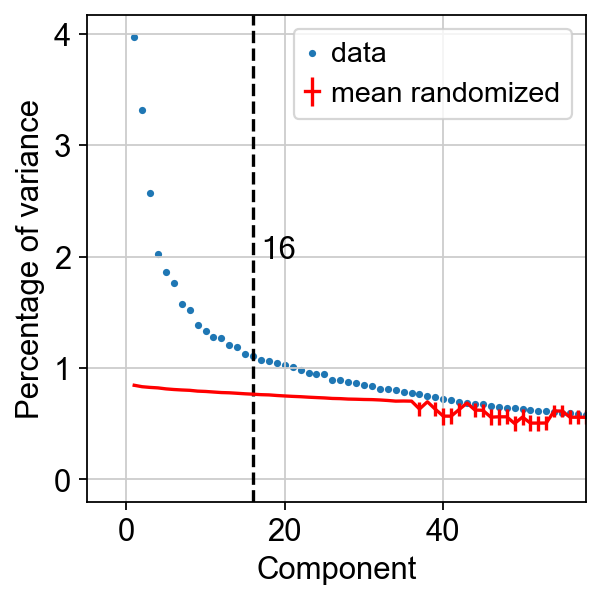

In [17]:
sc.set_figure_params(scanpy=True, fontsize=14)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(np.arange(1, len(adata.uns['pca']['variance'])+1), adata.uns['pca']['variance']/sum(adata.uns['pca']['variance'])*100, s = 5, label = 'data')
ax.errorbar(np.arange(1,len(rnd_vars[0])+1), fra_rnd_mean, yerr = fra_rnd_stderr, color = 'red', label = 'mean randomized')
ax.text(npca, 0.5*((adata.uns['pca']['variance']/sum(adata.uns['pca']['variance'])*100).max()+(adata.uns['pca']['variance']/sum(adata.uns['pca']['variance'])*100).min()), ' '+str(npca), ha = 'left', fontsize=14, fontname="Microsoft Sans Serif")
ax.axvline(npca, ls = '--', c = 'k') 
ax.set_xlim(-5,min([3*npca, len(rnd_vars[0])+1])+10)
ax.set_ylabel('Percentage of variance', fontsize=14, fontname="Arial")
ax.legend()
plt.xlabel('Component', fontsize=14, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.savefig('pca_variance.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()


## Leiden clustering

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


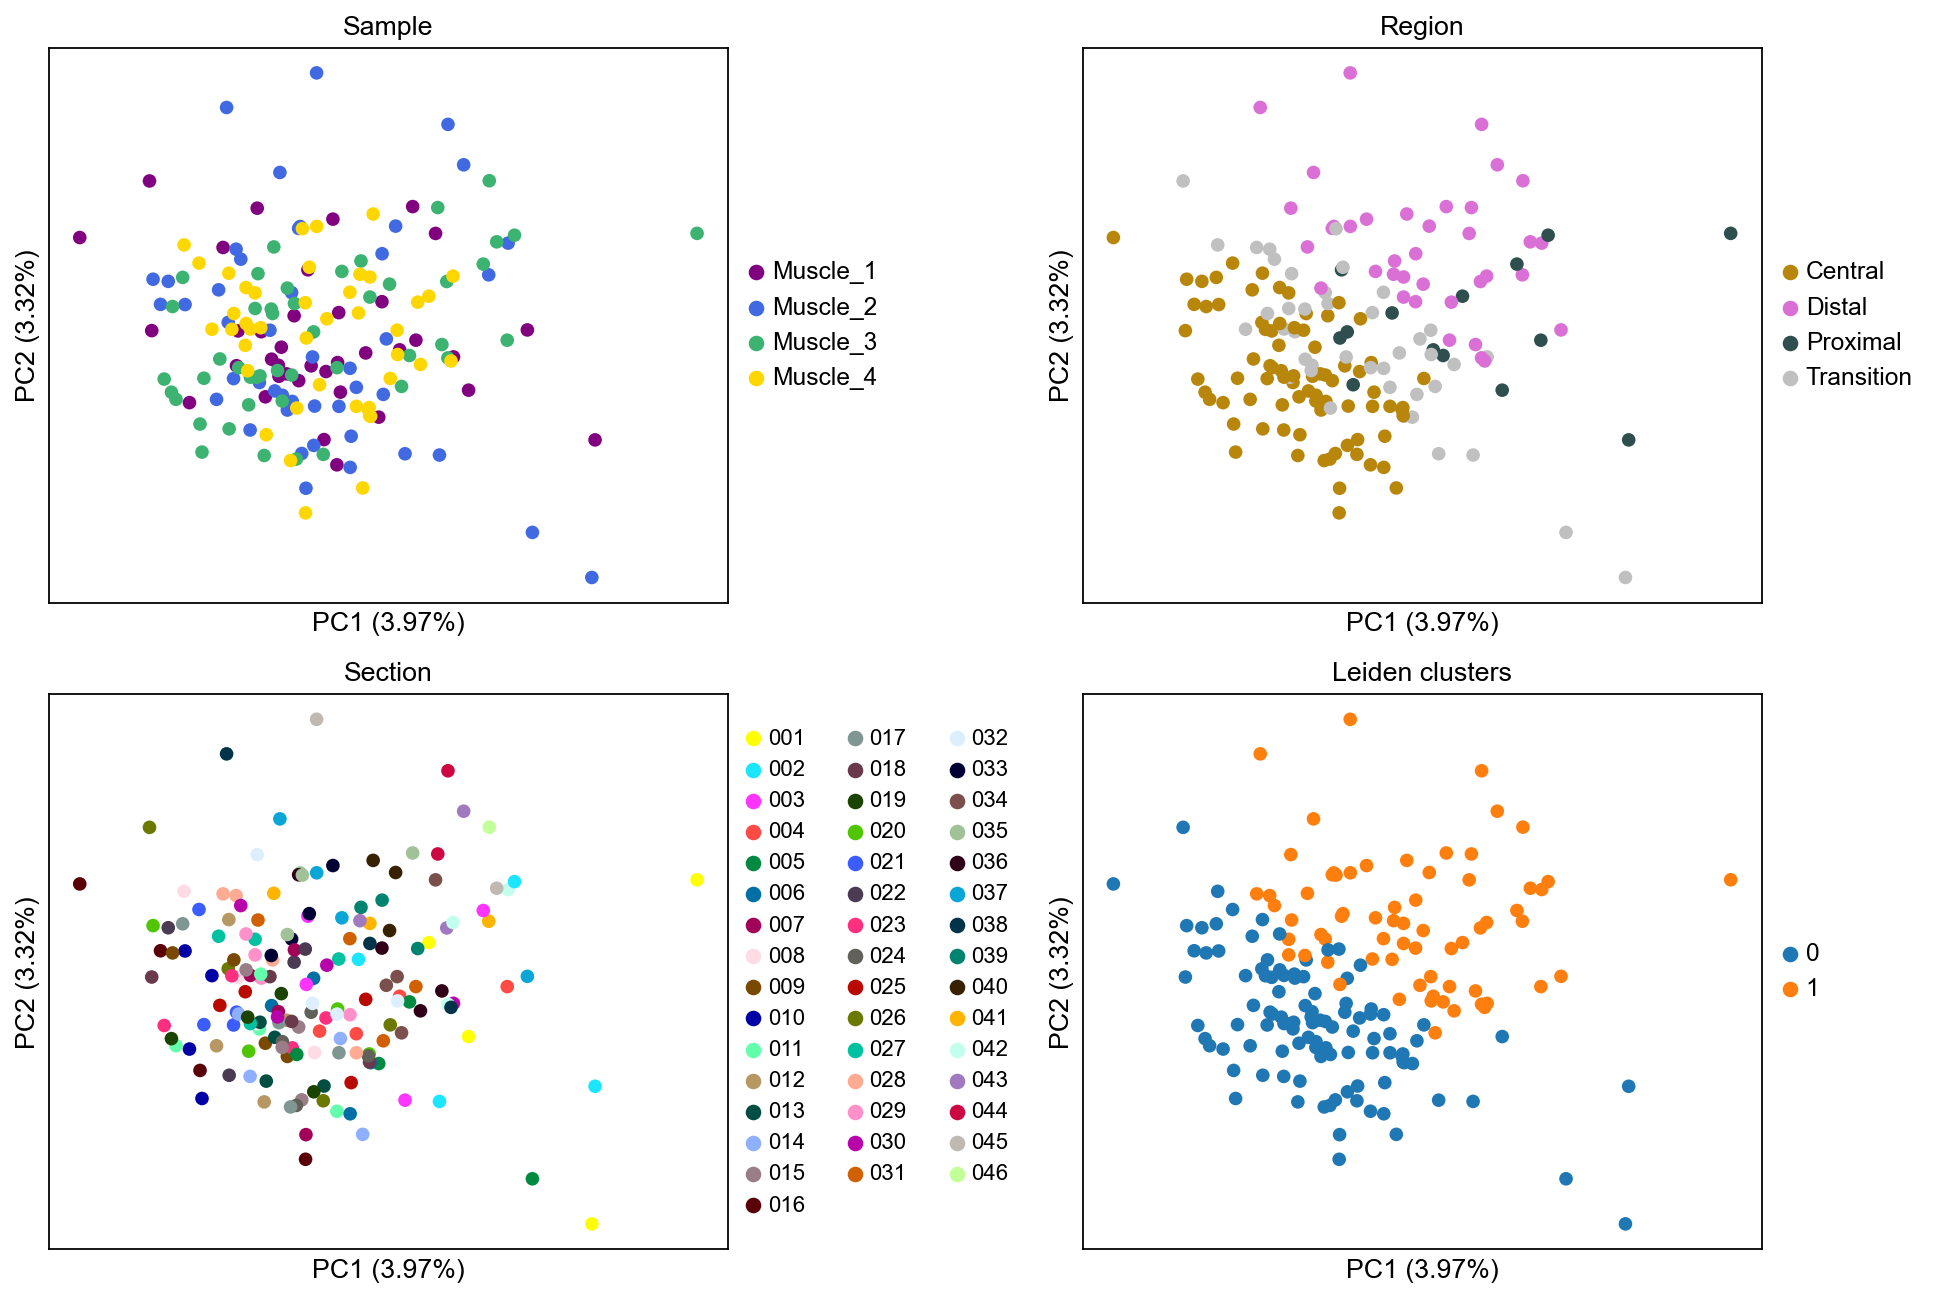

In [18]:

sc.set_figure_params(scanpy=True, fontsize=12, figsize=(1.5,1.5), color_map='Spectral_r')
fig, axs = plt.subplots(2, 2, figsize=(12,8),constrained_layout=True)
adata_plot = adata
adata_plot.obs['Section'] = adata_plot.obs['Section'].astype("category") # legend on data only works if the pandas column is categorical


sc.pl.pca(adata, components = ['1,2'], color='Sample', palette=['purple', 'royalblue', 'mediumseagreen', 'gold'], annotate_var_explained=True, ax=axs[0,0], show=False, size=150)
sc.pl.pca(adata, components = ['1,2'], color=['Region'], annotate_var_explained=True, palette=['darkgoldenrod', 'orchid', 'darkslategrey', 'silver'], ax=axs[0,1], show=False, size=150)
sc.pl.pca(adata_plot, components = ['1,2'], color='Section', legend_fontsize=10, color_map='Spectral_r', annotate_var_explained=True, ax=axs[1,0], show=False, size=150)

#neighbors and leiden cluster
sc.pp.neighbors(adata, n_neighbors = 65, n_pcs = 16)
sc.tl.leiden(adata, resolution = 0.5)

sc.pl.pca(adata, components = ['1,2'], color="leiden", title="Leiden clusters", ax=axs[1,1], show=False, size=150, annotate_var_explained=True)





In [19]:

#rename clusters
new_cluster_names = [
    'Central',
    'Proximal-distal'
    ]
adata.rename_categories('leiden', new_cluster_names)

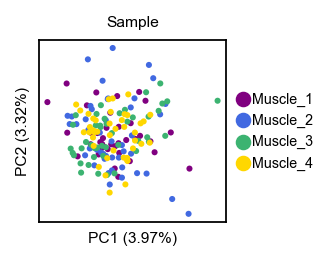

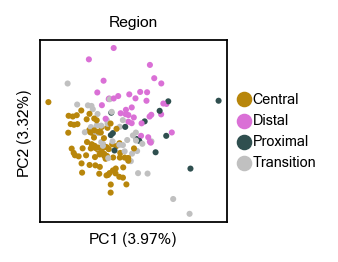

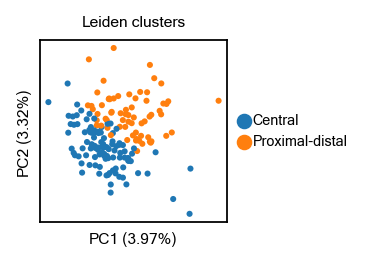

In [20]:
sc.set_figure_params(fontsize=7, figsize=(1.5,1.5), color_map='Spectral_r')
sc.pl.pca(adata, components = ['1,2'], color='Sample', palette=['purple', 'royalblue', 'mediumseagreen', 'gold'], annotate_var_explained=True, size=30, return_fig=True)
plt.gcf()
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.savefig('PC_sample.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()

sc.pl.pca(adata, components = ['1,2'], color=['Region'], annotate_var_explained=True, palette=['darkgoldenrod', 'orchid', 'darkslategrey', 'silver'], size=30, return_fig=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.savefig('PC_region.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()

sc.pl.pca(adata, components = ['1,2'], color="leiden", title="Leiden clusters", size=30, annotate_var_explained=True, return_fig=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.savefig('PC_cluster.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()


In [21]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
path = ''

file_names = [path + 'Muscle_1_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz', 
             path + 'Muscle_2_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz',
              path + 'Muscle_3_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz', 
             path + 'Muscle_4_genes.t.t.counts_filtered_noRibo_TOMOseq2-4.tsv.gz']

labels = ['Muscle_1', 'Muscle_2','Muscle_3', 'Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_genes_filtered = accessData(file_names, labels)


In [22]:
meta_data=pd.DataFrame(adata.obs)
meta_data['Transcript counts'] = list(data_genes_filtered['Muscle_1'].sum())+list(data_genes_filtered['Muscle_2'].sum())+list(data_genes_filtered['Muscle_3'].sum())+list(data_genes_filtered['Muscle_4'].sum())
meta_data['PC1'] = list(pd.DataFrame(adata.obsm['X_pca']).iloc[:,0])
meta_data['PC2'] = list(pd.DataFrame(adata.obsm['X_pca']).iloc[:,0])
meta_data.to_excel("metadata.xlsx") 
meta_data

Section    Sample      Region           leiden  Transcript counts  \
0       001  Muscle_1    Proximal          Central      161211.575240   
1       002  Muscle_1    Proximal          Central      188609.317165   
2       003  Muscle_1    Proximal  Proximal-distal      285859.890922   
3       004  Muscle_1    Proximal  Proximal-distal      603433.080500   
4       005  Muscle_1  Transition          Central      462816.711656   
..      ...       ...         ...              ...                ...   
166     039  Muscle_4      Distal  Proximal-distal      348027.897739   
167     040  Muscle_4      Distal  Proximal-distal      582268.965080   
168     041  Muscle_4      Distal  Proximal-distal      201367.900503   
169     042  Muscle_4      Distal  Proximal-distal      160966.128144   
170     043  Muscle_4      Distal  Proximal-distal      166629.459771   

           PC1        PC2  
0    19.433060  19.433060  
1    35.949142  35.949142  
2    -1.548404  -1.548404  
3    10.428934  10.428934  
4     7.703436   7.703436  
..         ...        ...  
166  12.789564  12.789564  
167   6.970232   6.970232  
168   6.545357   6.545357  
169  17.398216  17.398216  
170   5.242346   5.242346  

[171 rows x 7 columns]

## Analisis correlations sections from all 4 muscles


In [23]:
#calculate the szcores
data_zscores = zscores(data_genes_filtered_normal)


In [24]:
data_zscores_re={}
for key in data_zscores:
    data_zscores_re[key] = data_zscores[key].add_suffix('_'+key)
    print(key, len(list(data_zscores[key].columns)))
data_zscores_re[key]

Muscle_1 37
Muscle_2 45
Muscle_3 46
Muscle_4 43


001_Muscle_4  002_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 0.530953      0.160581   
ENSMUSG00000000056_Narf_ProteinCoding         -0.615313      0.369567   
ENSMUSG00000000078_Klf6_ProteinCoding         -1.562245     -1.181947   
ENSMUSG00000000085_Scmh1_ProteinCoding        -1.433953     -0.819454   
ENSMUSG00000000088_Cox5a_ProteinCoding        -1.565216      1.260661   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding        -1.577749      0.235319   
ENSMUSG00000116590_AC154200.1_lincRNA         -2.592039     -0.440790   
ENSMUSG00000117679_Apbb3_ProteinCoding        -0.364993     -0.221151   
ENSMUSG00000117924_Tmem223_ProteinCoding      -1.317433      0.585311   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -1.127529      1.007312   

                                           003_Muscle_4  004_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 0.932760      2.027773   
ENSMUSG00000000056_Narf_ProteinCoding          1.278004      1.258545   
ENSMUSG00000000078_Klf6_ProteinCoding         -0.583298      1.785380   
ENSMUSG00000000085_Scmh1_ProteinCoding        -0.247735     -0.353168   
ENSMUSG00000000088_Cox5a_ProteinCoding         1.862015      0.669165   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding         1.277714      1.246685   
ENSMUSG00000116590_AC154200.1_lincRNA         -0.569041      0.624357   
ENSMUSG00000117679_Apbb3_ProteinCoding         1.710767     -1.412773   
ENSMUSG00000117924_Tmem223_ProteinCoding       0.018801      1.191779   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -0.212185     -0.502116   

                                           005_Muscle_4  006_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 1.276972      1.551331   
ENSMUSG00000000056_Narf_ProteinCoding          0.760358     -0.824214   
ENSMUSG00000000078_Klf6_ProteinCoding         -0.217032     -0.700582   
ENSMUSG00000000085_Scmh1_ProteinCoding         0.739689     -1.433953   
ENSMUSG00000000088_Cox5a_ProteinCoding         1.263980      1.496008   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding        -0.085616      0.344286   
ENSMUSG00000116590_AC154200.1_lincRNA          0.909792     -0.474890   
ENSMUSG00000117679_Apbb3_ProteinCoding         0.080218     -1.058323   
ENSMUSG00000117924_Tmem223_ProteinCoding      -0.177108     -0.123811   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -0.708463     -0.859035   

                                           007_Muscle_4  008_Muscle_4  \
new_gene                                                                
ENSMUSG00000000031_H19_lincRNA                 1.133426      0.669879   
ENSMUSG00000000056_Narf_ProteinCoding          0.610689      0.356962   
ENSMUSG00000000078_Klf6_ProteinCoding          0.550389     -0.427664   
ENSMUSG00000000085_Scmh1_ProteinCoding         0.271629      1.622287   
ENSMUSG00000000088_Cox5a_ProteinCoding         0.941684      0.918969   
...                                                 ...           ...   
ENSMUSG00000115987_Vps28_ProteinCoding         0.425157      1.523837   
ENSMUSG00000116590_AC154200.1_lincRNA          1.146220     -1.024769   
ENSMUSG00000117679_Apbb3_ProteinCoding        -1.127439      1.446131   
ENSMUSG00000117924_Tmem223_ProteinCoding       2.049775     -1.231105   
ENSMUSG00000118346_Tmem179b_ProteinCoding     -0.798703     -0.773994   

                                           009_Muscle_4  010_Muscle_4  ...  \
new_gene                                                               ...   
ENSMUSG00000000031_H19_lincRNA                 0.005091     -0.569689  ...   
ENSMUSG00

In [25]:
data_zscores_all={}
df1 = pd.concat([data_zscores_re['Muscle_1'], data_zscores_re['Muscle_2']], axis=1)
df2 = pd.concat([df1, data_zscores_re['Muscle_3']], axis=1).dropna()
data_zscores_all['shared'] = pd.concat([df2, data_zscores_re['Muscle_4']], axis=1).dropna()

data_zscores_all['shared']

001_Muscle_1  002_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                 -1.036785     -0.373270   
ENSMUSG00000000056_Narf_ProteinCoding           1.138439     -0.706679   
ENSMUSG00000000078_Klf6_ProteinCoding          -0.892160     -1.732086   
ENSMUSG00000000085_Scmh1_ProteinCoding         -0.546422     -1.798119   
ENSMUSG00000000088_Cox5a_ProteinCoding          0.213081      0.271711   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding      0.759145     -1.421242   
ENSMUSG00000115987_Vps28_ProteinCoding         -0.194923      1.037764   
ENSMUSG00000116590_AC154200.1_lincRNA           2.502420      0.237031   
ENSMUSG00000117924_Tmem223_ProteinCoding       -1.082169     -2.321594   
ENSMUSG00000118346_Tmem179b_ProteinCoding       0.128962      1.676261   

                                            003_Muscle_1  004_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                  0.263263      0.569445   
ENSMUSG00000000056_Narf_ProteinCoding          -1.571013     -1.300227   
ENSMUSG00000000078_Klf6_ProteinCoding          -1.133935     -0.327262   
ENSMUSG00000000085_Scmh1_ProteinCoding         -1.088990     -0.296048   
ENSMUSG00000000088_Cox5a_ProteinCoding          1.208961      0.823092   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding     -0.333022     -0.815569   
ENSMUSG00000115987_Vps28_ProteinCoding         -2.126330     -0.859483   
ENSMUSG00000116590_AC154200.1_lincRNA          -1.302481      0.392095   
ENSMUSG00000117924_Tmem223_ProteinCoding        1.192721      0.284125   
ENSMUSG00000118346_Tmem179b_ProteinCoding      -0.604251      0.467311   

                                            005_Muscle_1  006_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                  1.227004      1.785570   
ENSMUSG00000000056_Narf_ProteinCoding          -0.139761     -0.907144   
ENSMUSG00000000078_Klf6_ProteinCoding          -0.268263      0.461843   
ENSMUSG00000000085_Scmh1_ProteinCoding          0.185970      1.272163   
ENSMUSG00000000088_Cox5a_ProteinCoding         -0.411594      1.069682   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding      0.281813      0.159224   
ENSMUSG00000115987_Vps28_ProteinCoding         -1.117924      0.457893   
ENSMUSG00000116590_AC154200.1_lincRNA          -1.564440      0.275353   
ENSMUSG00000117924_Tmem223_ProteinCoding       -0.356237      1.179756   
ENSMUSG00000118346_Tmem179b_ProteinCoding      -0.222253     -0.318884   

                                            007_Muscle_1  008_Muscle_1  \
new_gene                                                                 
ENSMUSG00000000031_H19_lincRNA                  2.050725      1.350514   
ENSMUSG00000000056_Narf_ProteinCoding          -0.071753      0.052491   
ENSMUSG00000000078_Klf6_ProteinCoding           1.067162     -0.813462   
ENSMUSG00000000085_Scmh1_ProteinCoding          0.973714      0.452481   
ENSMUSG00000000088_Cox5a_ProteinCoding         -0.353025      1.699342   
...                                                  ...           ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding     -1.379345     -1.472183   
ENSMUSG00000115987_Vps28_ProteinCoding          0.083101      0.698913   
ENSMUSG00000116590_AC154200.1_lincRNA           0.730918     -0.627430   
ENSMUSG00000117924_Tmem223_ProteinCoding        1.802962      2.144763   
ENSMUSG00000118346_Tmem179b_ProteinCoding       0.777706     -1.055958   

                                            009_Muscle_1  010_Muscle_1  ...  \
new_gene                                                                ...   
ENSMUSG00000000031_H19_lincRNA    

In [26]:
data_corr_all={}
for key in data_zscores_all:
    dataframe=data_zscores_all[key].astype(float)
    data_corr_all[key] = dataframe.corr()
data_corr_all['shared'].to_excel("data_correlations.xlsx") 
data_corr_all['shared']

001_Muscle_1  002_Muscle_1  003_Muscle_1  004_Muscle_1  \
001_Muscle_1      1.000000      0.007670      0.012907     -0.001847   
002_Muscle_1      0.007670      1.000000     -0.025132      0.067789   
003_Muscle_1      0.012907     -0.025132      1.000000      0.010499   
004_Muscle_1     -0.001847      0.067789      0.010499      1.000000   
005_Muscle_1     -0.055567      0.032504     -0.048539      0.042554   
...                    ...           ...           ...           ...   
039_Muscle_4     -0.020731      0.009600     -0.049167      0.003538   
040_Muscle_4      0.012421     -0.002952      0.006987      0.014204   
041_Muscle_4      0.001110     -0.009957      0.014541     -0.017398   
042_Muscle_4      0.042994      0.021696      0.013206      0.033418   
043_Muscle_4     -0.001414     -0.000764      0.011664     -0.025379   

              005_Muscle_1  006_Muscle_1  007_Muscle_1  008_Muscle_1  \
001_Muscle_1     -0.055567     -0.018624     -0.071920     -0.041480   
002_Muscle_1      0.032504     -0.017803     -0.014064     -0.045905   
003_Muscle_1     -0.048539     -0.061440     -0.078381     -0.037940   
004_Muscle_1      0.042554      0.067851      0.006762     -0.055495   
005_Muscle_1      1.000000      0.072720      0.008642     -0.001578   
...                    ...           ...           ...           ...   
039_Muscle_4     -0.004897      0.012933     -0.012143     -0.012230   
040_Muscle_4      0.006008     -0.052248     -0.002236     -0.002182   
041_Muscle_4     -0.006012      0.002280     -0.019885     -0.033175   
042_Muscle_4     -0.017053     -0.003166     -0.011182     -0.022354   
043_Muscle_4     -0.034129     -0.040223     -0.014186     -0.010104   

              009_Muscle_1  010_Muscle_1  ...  034_Muscle_4  035_Muscle_4  \
001_Muscle_1     -0.059568     -0.052409  ...     -0.011708     -0.053579   
002_Muscle_1     -0.035227     -0.067409  ...      0.011872     -0.001875   
003_Muscle_1     -0.045227     -0.069869  ...     -0.020688     -0.028292   
004_Muscle_1     -0.006986     -0.058894  ...     -0.008124      0.036834   
005_Muscle_1      0.028049      0.044823  ...      0.028009     -0.030189   
...                    ...           ...  ...           ...           ...   
039_Muscle_4     -0.017734     -0.028523  ...      0.064947     -0.017764   
040_Muscle_4     -0.053180     -0.110791  ...      0.055396      0.044372   
041_Muscle_4     -0.019138     -0.032667  ...     -0.004022     -0.021266   
042_Muscle_4     -0.015664     -0.039482  ...      0.023877     -0.028598   
043_Muscle_4     -0.023254     -0.044395  ...     -0.014256     -0.070686   

              036_Muscle_4  037_Muscle_4  038_Muscle_4  039_Muscle_4  \
001_Muscle_1     -0.004378      0.023256     -0.040658     -0.020731   
002_Muscle_1     -0.015698     -0.002104      0.029273      0.009600   
003_Muscle_1     -0.053963      0.031285     -0.046090     -0.049167   
004_Muscle_1     -0.040249      0.013748     -0.011041      0.003538   
005_Muscle_1      0.013810     -0.059437      0.034885     -0.004897   
...                    ...           ...           ...           ...   
039_Muscle_4      0.021409     -0.009699      0.044835      1.000000   
040_Muscle_4     -0.003995      0.075665      0.057090      0.046673   
041_Muscle_4      0.007470      0.021462      0.005502      0.023571   
042_Muscle_4     -0.007816      0.035561      0.014623      0.006103   
043_Muscle_4     -0.012755      0.018133     -0.012343      0.019312   

              040_Muscle_4  041_Muscle_4  042_Muscle_4  043_Muscle_4  
001_Muscle_1      0.012421      0.001110      0.042994     -0.001414  
002_Muscle_1     -0.002952     -0.009957      0.021696     -0.000764  
003_Muscle_1      0.006987      0.014541      0.013206      0.011664  
004_Muscle_1      0.014204     -0.017398      0.033418     -0.025379  
005_Muscle_1      0.006008     -0.006012     -0.017053     -0.034129  
...                    ...           ...           ...           ...

In [27]:
for index in data_corr_all['shared'].index:
    data_corr_all['shared'].loc[index,index] = 0
data_corr_all['shared']

001_Muscle_1  002_Muscle_1  003_Muscle_1  004_Muscle_1  \
001_Muscle_1      0.000000      0.007670      0.012907     -0.001847   
002_Muscle_1      0.007670      0.000000     -0.025132      0.067789   
003_Muscle_1      0.012907     -0.025132      0.000000      0.010499   
004_Muscle_1     -0.001847      0.067789      0.010499      0.000000   
005_Muscle_1     -0.055567      0.032504     -0.048539      0.042554   
...                    ...           ...           ...           ...   
039_Muscle_4     -0.020731      0.009600     -0.049167      0.003538   
040_Muscle_4      0.012421     -0.002952      0.006987      0.014204   
041_Muscle_4      0.001110     -0.009957      0.014541     -0.017398   
042_Muscle_4      0.042994      0.021696      0.013206      0.033418   
043_Muscle_4     -0.001414     -0.000764      0.011664     -0.025379   

              005_Muscle_1  006_Muscle_1  007_Muscle_1  008_Muscle_1  \
001_Muscle_1     -0.055567     -0.018624     -0.071920     -0.041480   
002_Muscle_1      0.032504     -0.017803     -0.014064     -0.045905   
003_Muscle_1     -0.048539     -0.061440     -0.078381     -0.037940   
004_Muscle_1      0.042554      0.067851      0.006762     -0.055495   
005_Muscle_1      0.000000      0.072720      0.008642     -0.001578   
...                    ...           ...           ...           ...   
039_Muscle_4     -0.004897      0.012933     -0.012143     -0.012230   
040_Muscle_4      0.006008     -0.052248     -0.002236     -0.002182   
041_Muscle_4     -0.006012      0.002280     -0.019885     -0.033175   
042_Muscle_4     -0.017053     -0.003166     -0.011182     -0.022354   
043_Muscle_4     -0.034129     -0.040223     -0.014186     -0.010104   

              009_Muscle_1  010_Muscle_1  ...  034_Muscle_4  035_Muscle_4  \
001_Muscle_1     -0.059568     -0.052409  ...     -0.011708     -0.053579   
002_Muscle_1     -0.035227     -0.067409  ...      0.011872     -0.001875   
003_Muscle_1     -0.045227     -0.069869  ...     -0.020688     -0.028292   
004_Muscle_1     -0.006986     -0.058894  ...     -0.008124      0.036834   
005_Muscle_1      0.028049      0.044823  ...      0.028009     -0.030189   
...                    ...           ...  ...           ...           ...   
039_Muscle_4     -0.017734     -0.028523  ...      0.064947     -0.017764   
040_Muscle_4     -0.053180     -0.110791  ...      0.055396      0.044372   
041_Muscle_4     -0.019138     -0.032667  ...     -0.004022     -0.021266   
042_Muscle_4     -0.015664     -0.039482  ...      0.023877     -0.028598   
043_Muscle_4     -0.023254     -0.044395  ...     -0.014256     -0.070686   

              036_Muscle_4  037_Muscle_4  038_Muscle_4  039_Muscle_4  \
001_Muscle_1     -0.004378      0.023256     -0.040658     -0.020731   
002_Muscle_1     -0.015698     -0.002104      0.029273      0.009600   
003_Muscle_1     -0.053963      0.031285     -0.046090     -0.049167   
004_Muscle_1     -0.040249      0.013748     -0.011041      0.003538   
005_Muscle_1      0.013810     -0.059437      0.034885     -0.004897   
...                    ...           ...           ...           ...   
039_Muscle_4      0.021409     -0.009699      0.044835      0.000000   
040_Muscle_4     -0.003995      0.075665      0.057090      0.046673   
041_Muscle_4      0.007470      0.021462      0.005502      0.023571   
042_Muscle_4     -0.007816      0.035561      0.014623      0.006103   
043_Muscle_4     -0.012755      0.018133     -0.012343      0.019312   

              040_Muscle_4  041_Muscle_4  042_Muscle_4  043_Muscle_4  
001_Muscle_1      0.012421      0.001110      0.042994     -0.001414  
002_Muscle_1     -0.002952     -0.009957      0.021696     -0.000764  
003_Muscle_1      0.006987      0.014541      0.013206      0.011664  
004_Muscle_1      0.014204     -0.017398      0.033418     -0.025379  
005_Muscle_1      0.006008     -0.006012     -0.017053     -0.034129  
...                    ...           ...           ...           ...

In [28]:
colors=[]
data_clusters=adata.obs
for index in data_clusters.index:
    if data_clusters.loc[index]['leiden'] == 'Central':
        colors.append('tab:blue')
    if data_clusters.loc[index]['leiden'] == 'Proximal-distal':
        colors.append('tab:orange')
data_clusters['color']= colors
data_clusters

Section    Sample      Region           leiden  Transcript counts  \
0       001  Muscle_1    Proximal          Central      161211.575240   
1       002  Muscle_1    Proximal          Central      188609.317165   
2       003  Muscle_1    Proximal  Proximal-distal      285859.890922   
3       004  Muscle_1    Proximal  Proximal-distal      603433.080500   
4       005  Muscle_1  Transition          Central      462816.711656   
..      ...       ...         ...              ...                ...   
166     039  Muscle_4      Distal  Proximal-distal      348027.897739   
167     040  Muscle_4      Distal  Proximal-distal      582268.965080   
168     041  Muscle_4      Distal  Proximal-distal      201367.900503   
169     042  Muscle_4      Distal  Proximal-distal      160966.128144   
170     043  Muscle_4      Distal  Proximal-distal      166629.459771   

           PC1        PC2       color  
0    19.433060  19.433060    tab:blue  
1    35.949142  35.949142    tab:blue  
2    -1.548404  -1.548404  tab:orange  
3    10.428934  10.428934  tab:orange  
4     7.703436   7.703436    tab:blue  
..         ...        ...         ...  
166  12.789564  12.789564  tab:orange  
167   6.970232   6.970232  tab:orange  
168   6.545357   6.545357  tab:orange  
169  17.398216  17.398216  tab:orange  
170   5.242346   5.242346  tab:orange  

[171 rows x 8 columns]

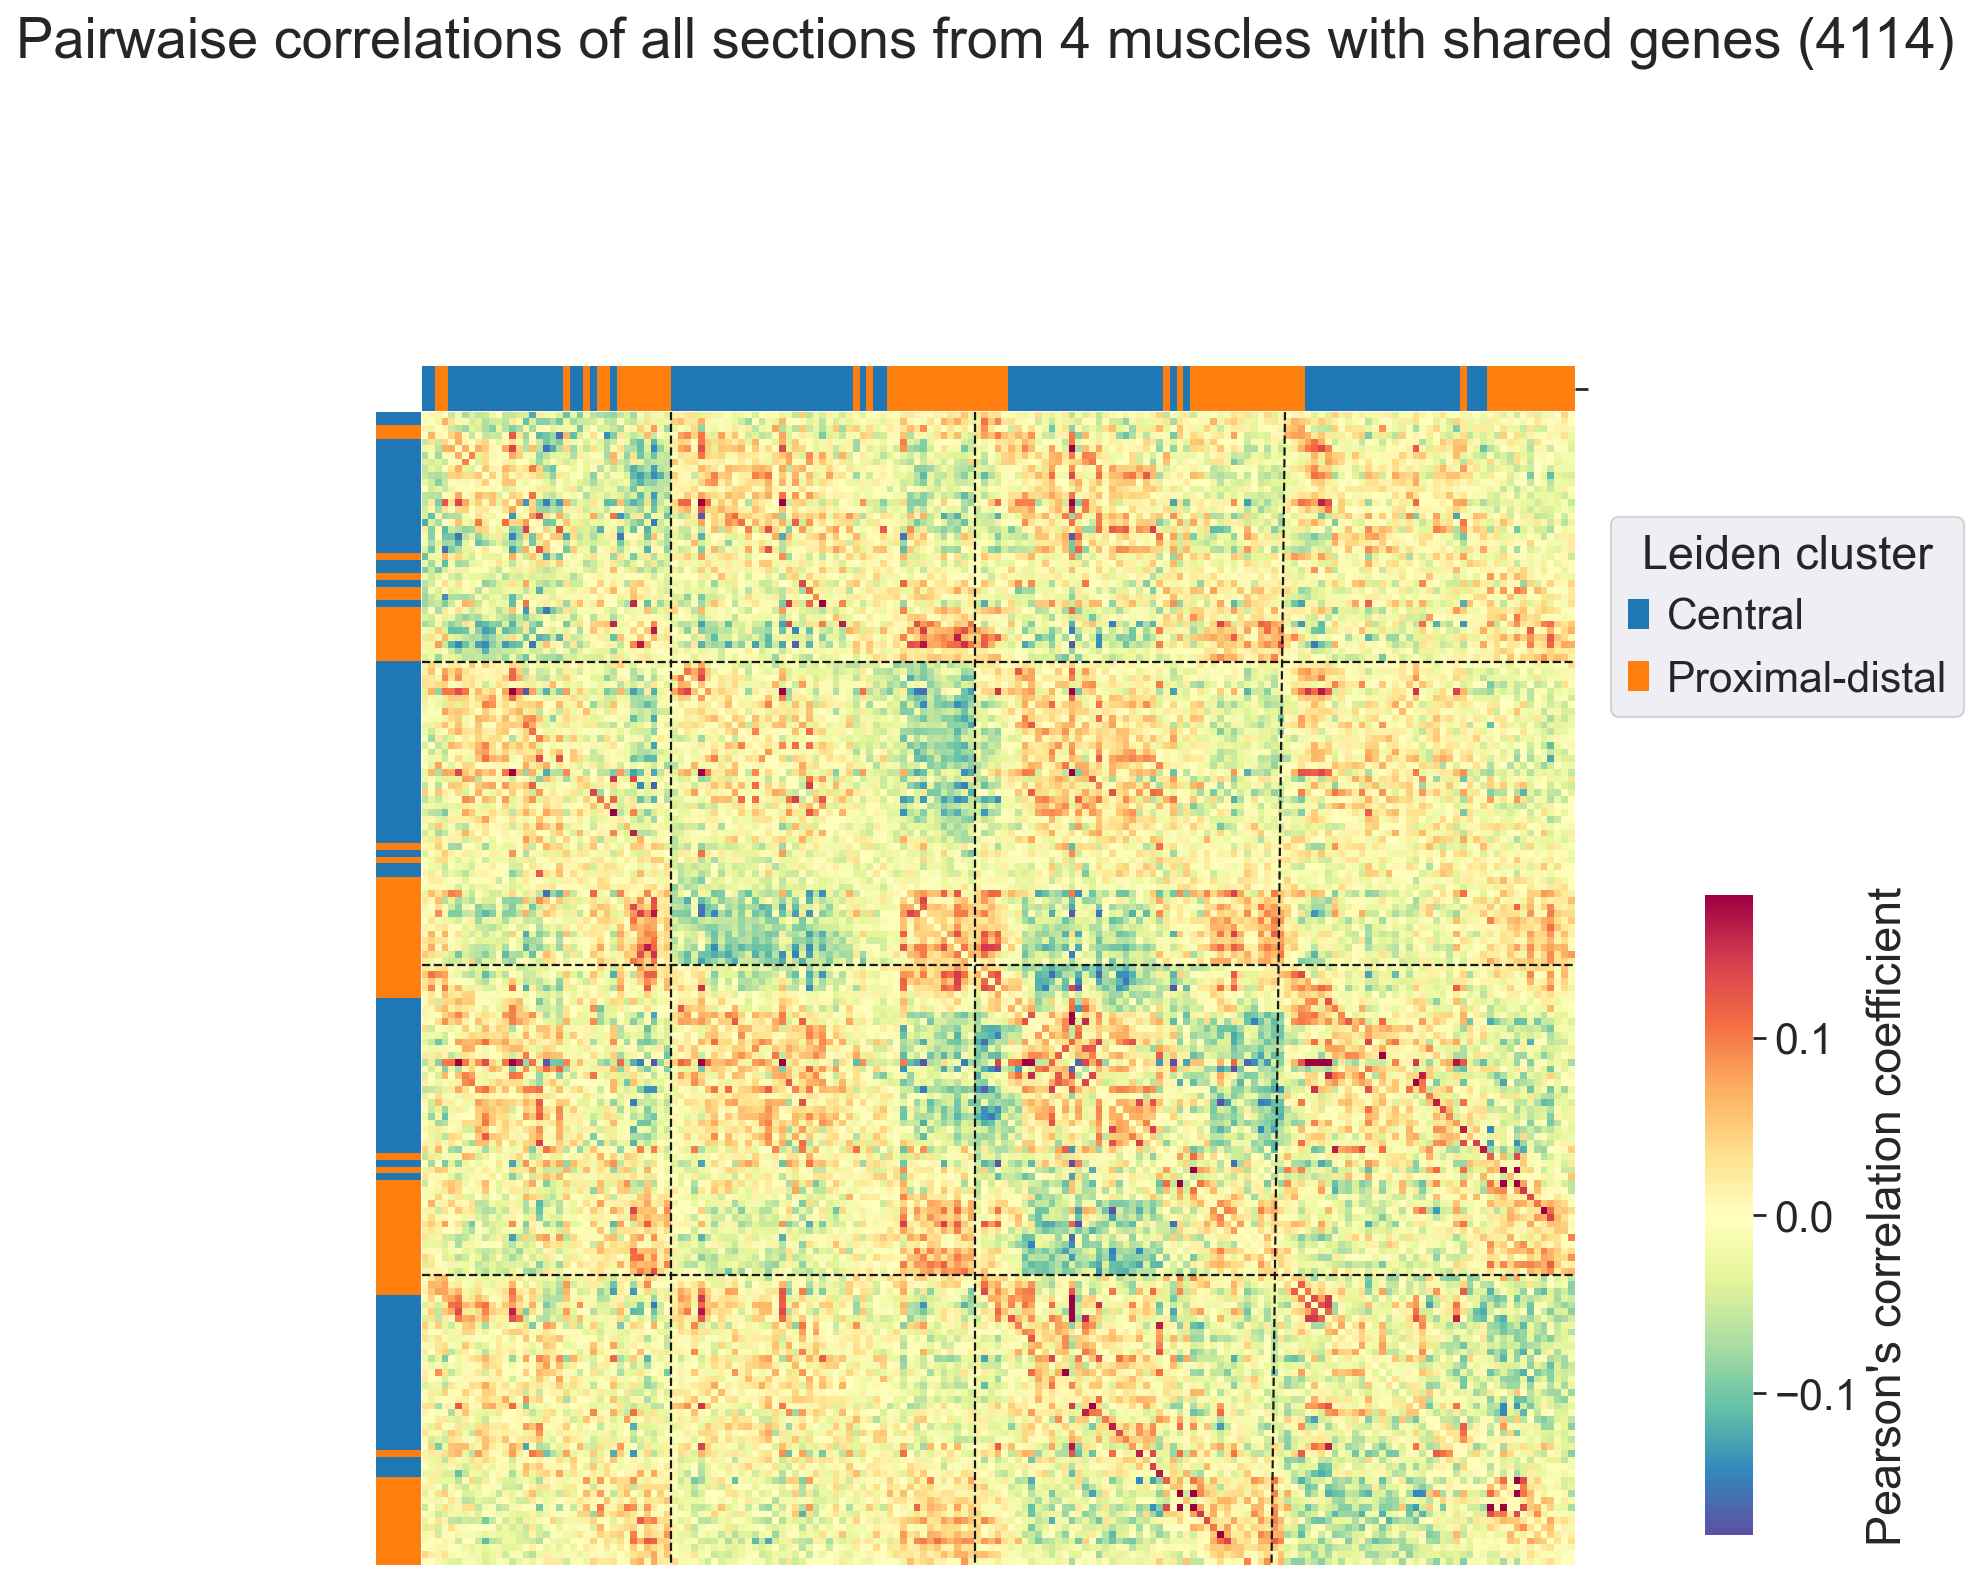

In [29]:
samples2=pd.Series(list(data_clusters['leiden']), index=list(np.arange(0,171)))
colors2=pd.Series(list(data_clusters['color']), index=list(np.arange(0,171)))
reference2 = {'Central': 'tab:blue', 'Proximal-distal': 'tab:orange'}

data_plot=data_corr_all['shared'].reset_index(drop=True)
data_plot.columns = list(np.arange(0,171))

sns.set(font_scale=1.75)

g = sns.clustermap(data_plot, row_cluster=False, col_cluster=False, row_colors = colors2, col_colors = colors2, cmap="Spectral_r", yticklabels=False, xticklabels=False, cbar_kws={'label': "Pearson's correlation coefficient"}, vmax=0.18, vmin=-0.18)
# Turn off the clustering
# Add colored class labels 
#add title and adjust color bar location
g.fig.suptitle('Pairwaise correlations of all sections from 4 muscles with shared genes (4114)', y=1, x=0.6)
g.ax_cbar.set_position((1.05, 0.05, .03, 0.4))

# add legends

for label in samples2.unique():
    g.ax_row_dendrogram.bar(0, 0, color=reference2[label], label=label, linewidth=0);
l2 = g.ax_row_dendrogram.legend(title='Leiden cluster', loc="upper right", ncol=1, bbox_to_anchor=(1.225, 0.7), bbox_transform=plt.gcf().transFigure)

#add lines delimiting muscles
ax = g.ax_heatmap  
#ax.plot([0, 171], [0, 0], 'w-', lw = 2)
ax.plot([0, 171], [37, 37], 'k--', lw = 1)
ax.plot([0, 171], [37+45, 37+45], 'k--', lw = 1)
ax.plot([0, 171], [37+45+46, 37+45+46], 'k--', lw = 1)

#ax.plot([0, 0], [0, 171], 'w-', lw = 1) 
ax.plot([37, 37], [0, 171], 'k--', lw = 1)
ax.plot([37+45, 37+45], [0, 171], 'k--', lw = 1)
ax.plot([37+45+46, 35+45+46], [0, 171], 'k--', lw = 1)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('Correlation_heatmap_all.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()
 

/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


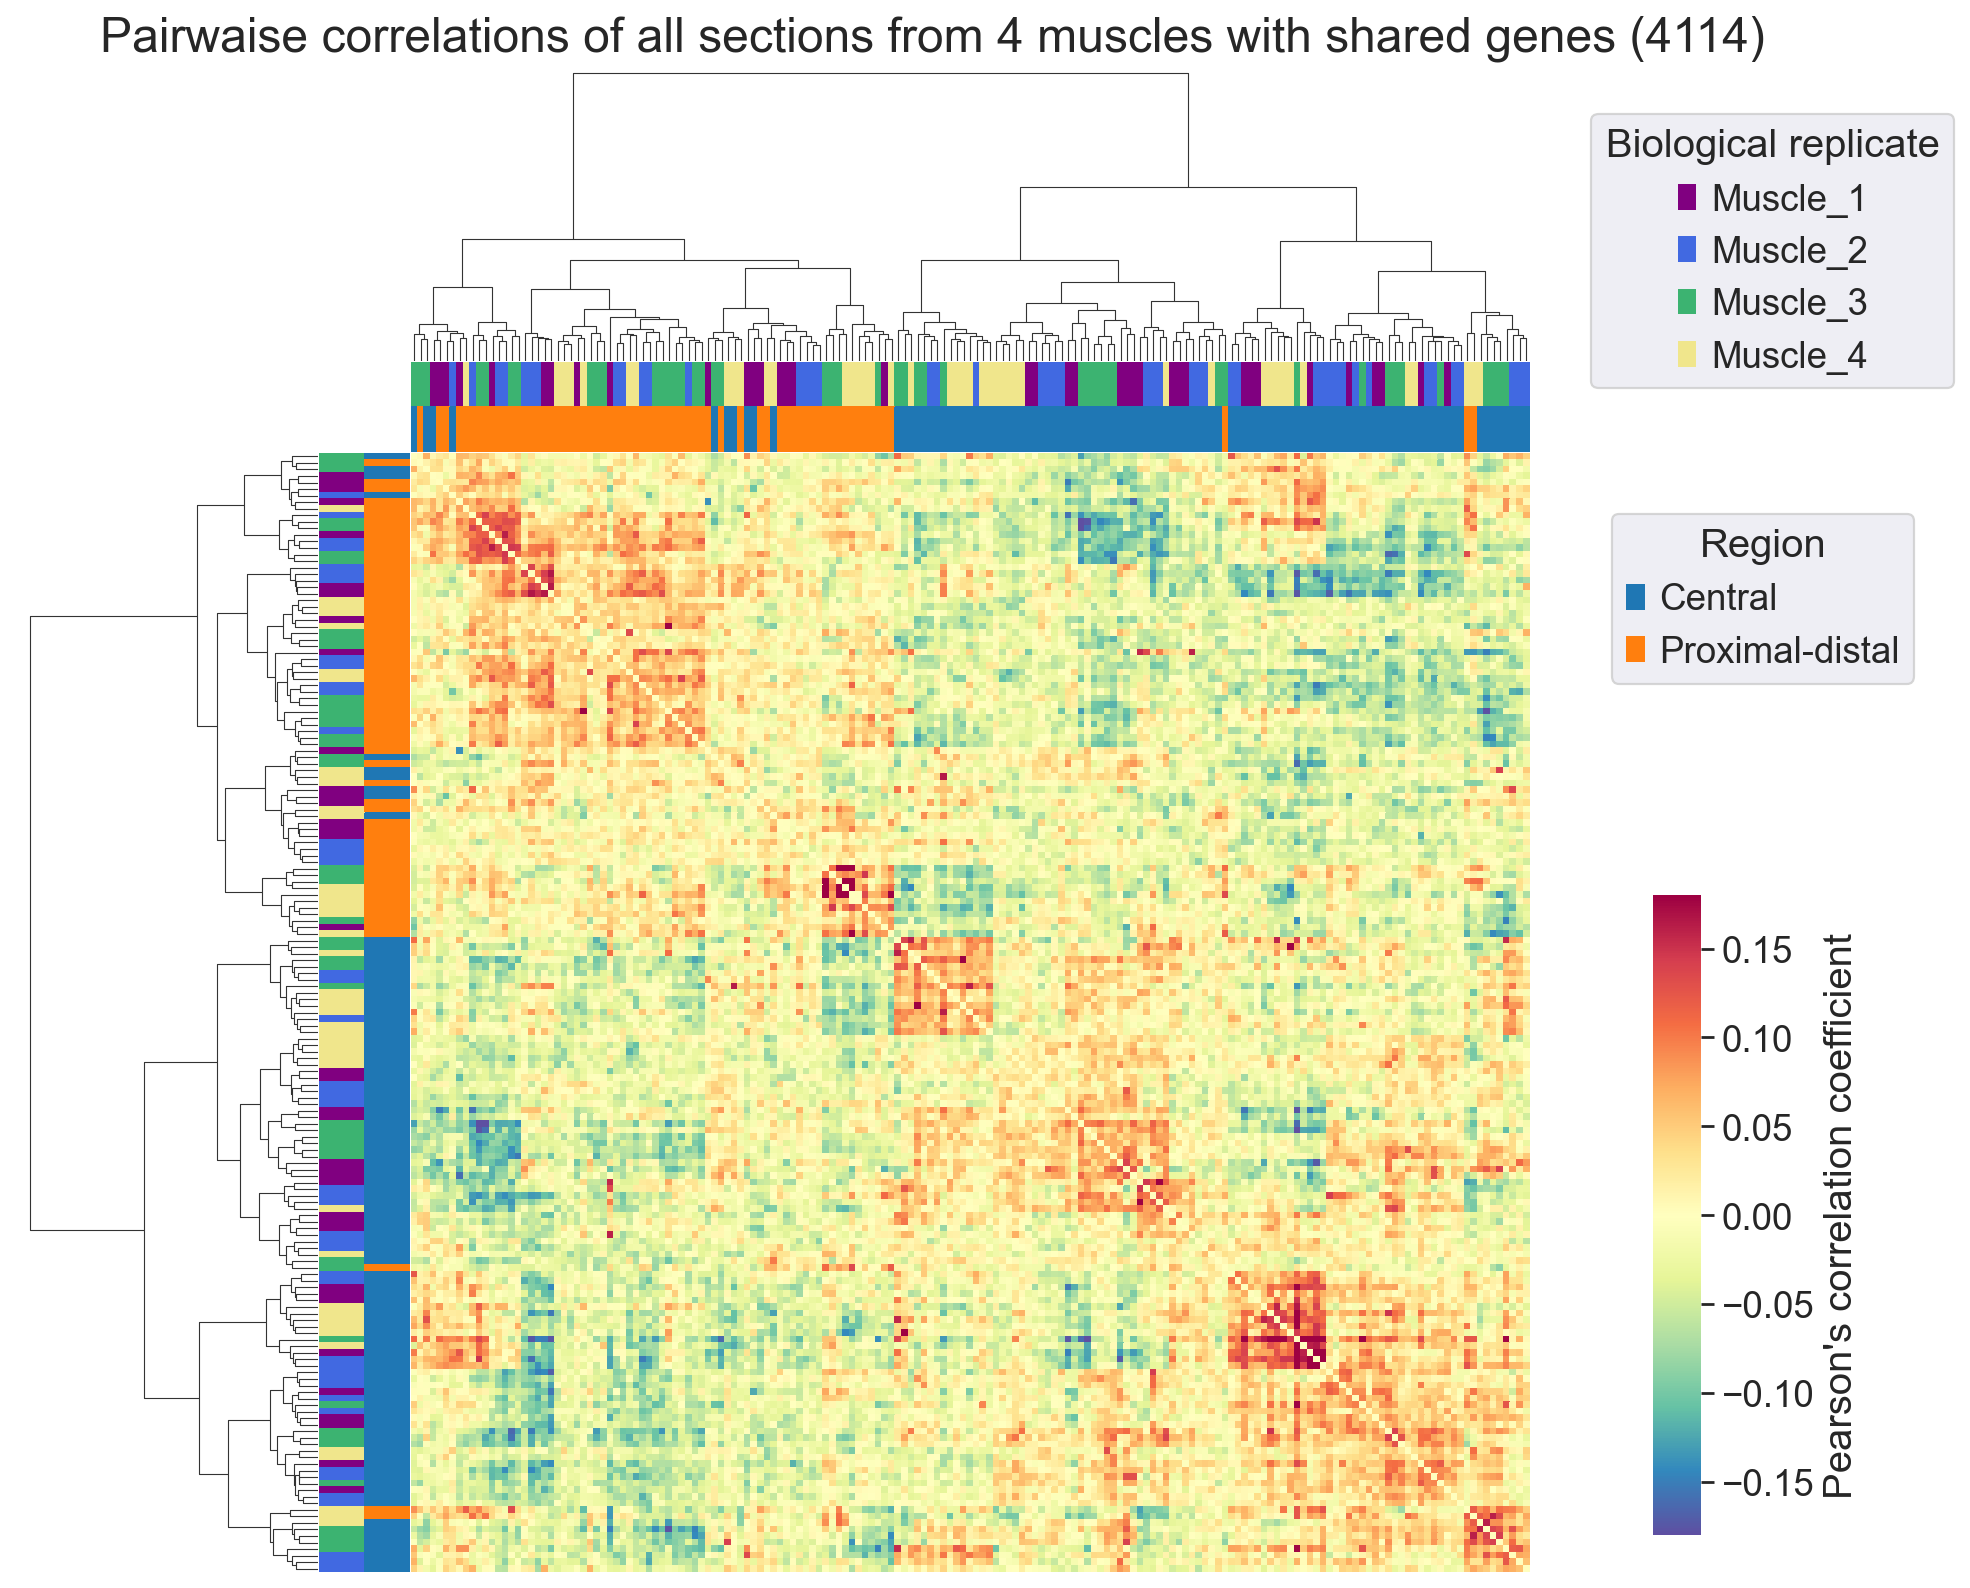

In [30]:
samples=pd.Series(list(['Muscle_1']*37+['Muscle_2']*45+['Muscle_3']*46+['Muscle_4']*43), index=list(np.arange(0,171)))
colors=pd.Series(list(['purple']*37+['royalblue']*45+['mediumseagreen']*46+['khaki']*43), index=list(np.arange(0,171)))

reference={'Muscle_1': 'purple', 'Muscle_2': 'royalblue', 'Muscle_3': 'mediumseagreen', 'Muscle_4': 'khaki'}

samples2=pd.Series(list(data_clusters['leiden']), index=list(np.arange(0,171)))
colors2=pd.Series(list(data_clusters['color']), index=list(np.arange(0,171)))
reference2 = {'Central': 'tab:blue', 'Proximal-distal': 'tab:orange'}

data_plot=data_corr_all['shared'].reset_index(drop=True)
data_plot.columns = list(np.arange(0,171))

sns.set(font="sans-serif", font_scale=1.5)

g = sns.clustermap(data_plot, method='ward', cmap='Spectral_r', row_colors = [colors, colors2], col_colors = [colors, colors2], yticklabels=False, xticklabels=False, cbar_kws={'label': "Pearson's correlation coefficient"}, vmax=0.18, vmin=-0.18)

# Turn off the clustering
# Add colored class labels 
#add title and adjust color bar location
g.fig.suptitle('Pairwaise correlations of all sections from 4 muscles with shared genes (4114)', y=1, x=0.6)
g.ax_cbar.set_position((1.05, 0.05, .03, 0.4))

# add legends
for label in samples.unique():
    g.ax_col_dendrogram.bar(0, 0, color=reference[label], label=label, linewidth=0);
l1 = g.ax_col_dendrogram.legend(title='Biological replicate', loc="upper right", ncol=1, bbox_to_anchor=(1.25, 0.95), bbox_transform=plt.gcf().transFigure)

for label in samples2.unique():
    g.ax_row_dendrogram.bar(0, 0, color=reference2[label], label=label, linewidth=0);
l2 = g.ax_row_dendrogram.legend(title='Region', loc="upper right", ncol=1, bbox_to_anchor=(1.225, 0.7), bbox_transform=plt.gcf().transFigure)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 7
plt.savefig('Correlation_cluster_all.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()


### Visualization of clusters on unfiltered data

In [31]:
data={}
data['Muscle_1']=pd.read_excel('data_filter_Muscle1.xlsx', index_col=0) 
data['Muscle_2']=pd.read_excel('data_filter_Muscle2.xlsx', index_col=0)
data['Muscle_3']=pd.read_excel('data_filter_Muscle3.xlsx', index_col=0)
data['Muscle_4']=pd.read_excel('data_filter_Muscle4.xlsx', index_col=0)

In [32]:
adata_1=adata[adata.obs["Sample"] == "Muscle_1"]
data_1=pd.DataFrame(adata_1.obs)
data_1=data_1.set_index('Section')

list_cluster=[]
list_color=[]

for index in data['Muscle_1'].index:
    if data['Muscle_1'].loc[index]['Filter'] == 'No':
        list_cluster.append('Filtered')
        list_color.append('grey')
    else:
        list_cluster.append(data_1.loc[data['Muscle_1'].loc[index]['Filter']]['leiden'])
        list_color.append(data_1.loc[data['Muscle_1'].loc[index]['Filter']]['color'])
data['Muscle_1']['leiden']=list_cluster
data['Muscle_1']['color']=list_color

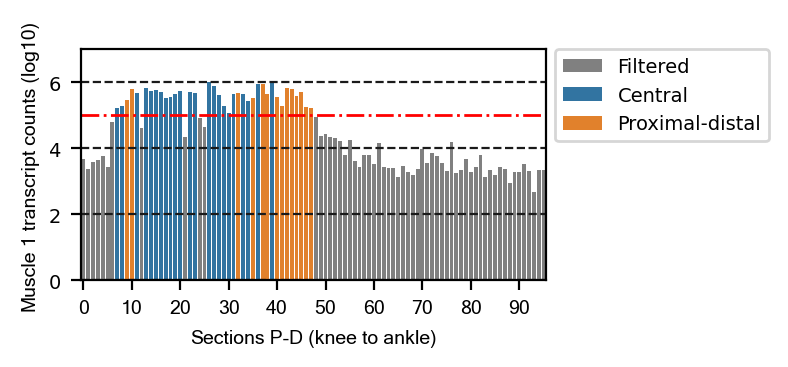

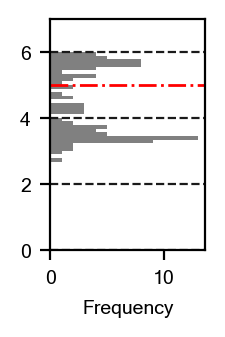

In [33]:
plt.rcParams.update(plt.rcParamsDefault)
# Define bar properties
bar_heights = list(data['Muscle_1']['log10'])
sections = np.arange(1,97)
labels = list(data['Muscle_1']['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})

palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
    'Filtered': 'grey'
}

plt.figure(figsize=(3, 1.5))
sns.barplot(x="Section", hue="Leiden cluster", y="Transcript counts", data=df, palette=palette, dodge = False)

plt.xlabel('Sections P-D (knee to ankle)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 1 transcript counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7)
plt.ylim([0, 7])
#select everyother 10 labels from the list of column names
plt.xticks(ticks=np.arange(0, 96, 10), labels=[str(i) for i in range(0,96,10)], rotation='horizontal', fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=7)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 7
plt.savefig('coverage_M1_cluters.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

#plot the frequency form the selection
df['Transcript counts'].plot(kind='hist', legend=False, figsize=(1, 1.5), bins=30, color='grey', orientation='horizontal');
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.ylim([0, 7])
plt.xlabel('Frequency', fontsize=7, fontname="Microsoft Sans Serif")

plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Trans-counts_freq_M1_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

In [34]:
adata_2=adata[adata.obs["Sample"] == "Muscle_2"]
data_2=pd.DataFrame(adata_2.obs)
data_2=data_2.set_index('Section')

list_cluster=[]
list_color=[]

for index in data['Muscle_2'].index:
    if data['Muscle_2'].loc[index]['Filter'] == 'No':
        list_cluster.append('Filtered')
        list_color.append('grey')
    else:
        list_cluster.append(data_2.loc[data['Muscle_2'].loc[index]['Filter']]['leiden'])
        list_color.append(data_2.loc[data['Muscle_2'].loc[index]['Filter']]['color'])
data['Muscle_2']['leiden']=list_cluster
data['Muscle_2']['color']=list_color

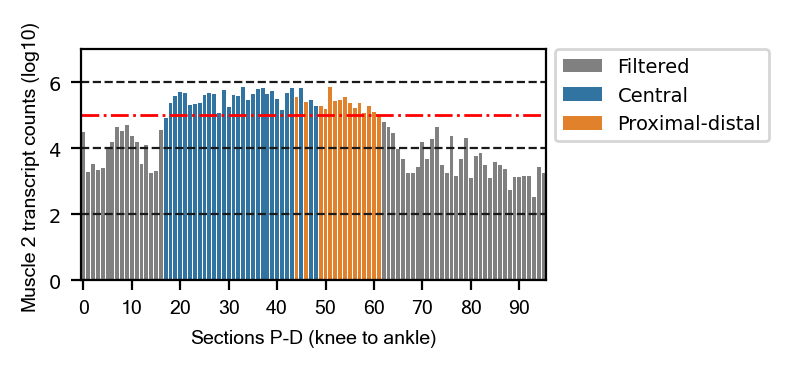

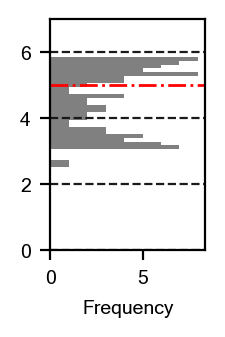

In [35]:
plt.rcParams.update(plt.rcParamsDefault)
# Define bar properties
bar_heights = list(data['Muscle_2']['log10'])
sections = np.arange(1,97)
labels = list(data['Muscle_2']['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})

palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
    'Filtered': 'grey'
}

plt.figure(figsize=(3, 1.5))
sns.barplot(x="Section", hue="Leiden cluster", y="Transcript counts", data=df, palette=palette, dodge = False)

plt.xlabel('Sections P-D (knee to ankle)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 2 transcript counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7)
plt.ylim([0, 7])
#select everyother 10 labels from the list of column names
plt.xticks(ticks=np.arange(0, 96, 10), labels=[str(i) for i in range(0,96,10)], rotation='horizontal', fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=7)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 7
plt.savefig('coverage_M2_cluters.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

#plot the frequency form the selection
df['Transcript counts'].plot(kind='hist', legend=False, figsize=(1, 1.5), bins=30, color='grey', orientation='horizontal');
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.ylim([0, 7])
plt.xlabel('Frequency', fontsize=7, fontname="Microsoft Sans Serif")

plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Trans-counts_freq_M2_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

In [36]:
adata_3=adata[adata.obs["Sample"] == "Muscle_3"]
data_3=pd.DataFrame(adata_3.obs)
data_3=data_3.set_index('Section')

list_cluster=[]
list_color=[]

for index in data['Muscle_3'].index:
    if data['Muscle_3'].loc[index]['Filter'] == 'No':
        list_cluster.append('Filtered')
        list_color.append('grey')
    else:
        list_cluster.append(data_3.loc[data['Muscle_3'].loc[index]['Filter']]['leiden'])
        list_color.append(data_3.loc[data['Muscle_3'].loc[index]['Filter']]['color'])
data['Muscle_3']['leiden']=list_cluster
data['Muscle_3']['color']=list_color

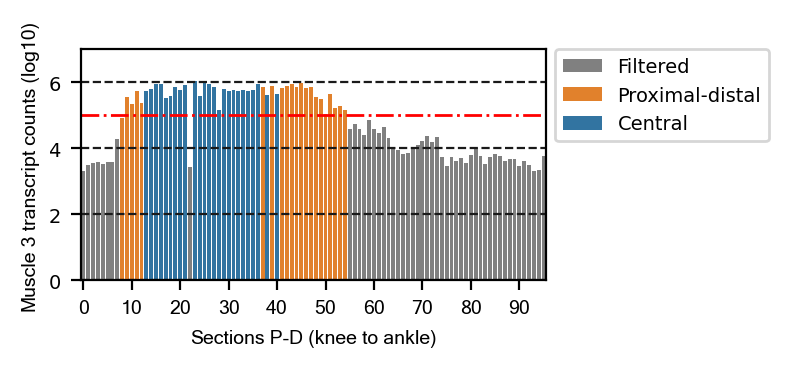

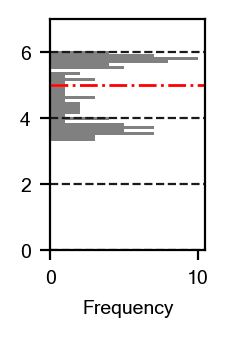

In [37]:
plt.rcParams.update(plt.rcParamsDefault)
# Define bar properties
bar_heights = list(data['Muscle_3']['log10'])
sections = np.arange(1,97)
labels = list(data['Muscle_3']['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})

palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
    'Filtered': 'grey'
}

plt.figure(figsize=(3, 1.5))
sns.barplot(x="Section", hue="Leiden cluster", y="Transcript counts", data=df, palette=palette, dodge = False)

plt.xlabel('Sections P-D (knee to ankle)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 3 transcript counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7)
plt.ylim([0, 7])
#select everyother 10 labels from the list of column names
plt.xticks(ticks=np.arange(0, 96, 10), labels=[str(i) for i in range(0,96,10)], rotation='horizontal', fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=7)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 7
plt.savefig('coverage_M3_cluters.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

#plot the frequency form the selection
df['Transcript counts'].plot(kind='hist', legend=False, figsize=(1, 1.5), bins=30, color='grey', orientation='horizontal');
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.ylim([0, 7])
plt.xlabel('Frequency', fontsize=7, fontname="Microsoft Sans Serif")

plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Trans-counts_freq_M3_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

In [38]:
adata_4=adata[adata.obs["Sample"] == "Muscle_4"]
data_4=pd.DataFrame(adata_4.obs)
data_4=data_4.set_index('Section')

list_cluster=[]
list_color=[]

for index in data['Muscle_4'].index:
    if data['Muscle_4'].loc[index]['Filter'] == 'No':
        list_cluster.append('Filtered')
        list_color.append('grey')
    else:
        list_cluster.append(data_4.loc[data['Muscle_4'].loc[index]['Filter']]['leiden'])
        list_color.append(data_4.loc[data['Muscle_4'].loc[index]['Filter']]['color'])
data['Muscle_4']['leiden']=list_cluster
data['Muscle_4']['color']=list_color

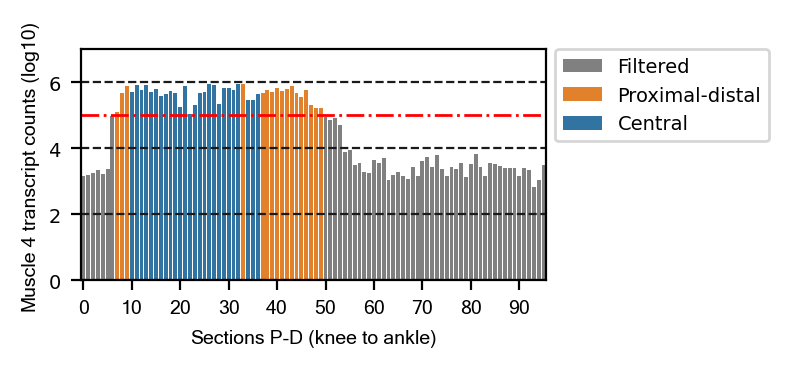

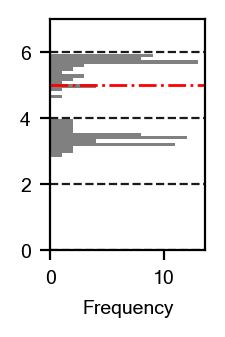

In [39]:
plt.rcParams.update(plt.rcParamsDefault)
# Define bar properties
bar_heights = list(data['Muscle_4']['log10'])
sections = np.arange(1,97)
labels = list(data['Muscle_4']['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})

palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
    'Filtered': 'grey'
}

plt.figure(figsize=(3, 1.5))
sns.barplot(x="Section", hue="Leiden cluster", y="Transcript counts", data=df, palette=palette, dodge = False)

plt.xlabel('Sections P-D (knee to ankle)', fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Muscle 4 transcript counts (log10)', fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7)
plt.ylim([0, 7])
#select everyother 10 labels from the list of column names
plt.xticks(ticks=np.arange(0, 96, 10), labels=[str(i) for i in range(0,96,10)], rotation='horizontal', fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=7)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 7
plt.savefig('coverage_M4_cluters.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

#plot the frequency form the selection
df['Transcript counts'].plot(kind='hist', legend=False, figsize=(1, 1.5), bins=30, color='grey', orientation='horizontal');
plt.axhline(y=5, color='red', linestyle='-.', linewidth = 1)
plt.ylim([0, 7])
plt.xlabel('Frequency', fontsize=7, fontname="Microsoft Sans Serif")

plt.xticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.grid(which='major', axis='y', linestyle='--', c='k')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('Trans-counts_freq_M4_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()

In [40]:
data['Muscle_1'].to_excel('data_filter_Muscle1_clusters.xlsx') 
data['Muscle_2'].to_excel('data_filter_Muscle2_clusters.xlsx') 
data['Muscle_3'].to_excel('data_filter_Muscle3_clusters.xlsx') 
data['Muscle_4'].to_excel('data_filter_Muscle4_clusters.xlsx') 

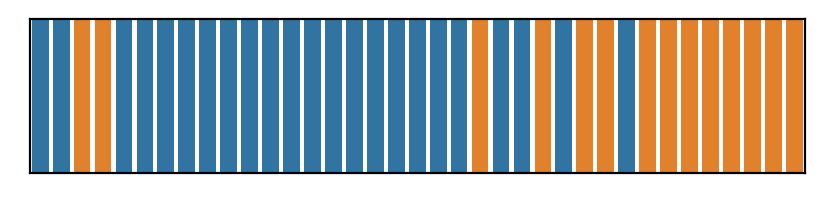

In [41]:
adata_1=adata[adata.obs["Sample"] == "Muscle_1"]
data_1=pd.DataFrame(adata_1.obs)
data_1['Transcript counts'] = [10]*len(adata_1.obs)
# Define bar properties
bar_heights = list(np.log10(data_1['Transcript counts']))
sections = [str(i) for i in data_1['Section']]
labels = list(data_1['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})


palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
}

plt.figure(figsize=(5, 1))
sns.barplot(data=df, x="Section", hue="Leiden cluster", y="Transcript counts", palette=palette, order=df['Section'], dodge = False)
plt.xlabel(None)
plt.ylabel(None)
plt.ylim([0, 1])
plt.xticks([]),plt.yticks([])
plt.legend('',frameon=False)
plt.savefig('M1_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()

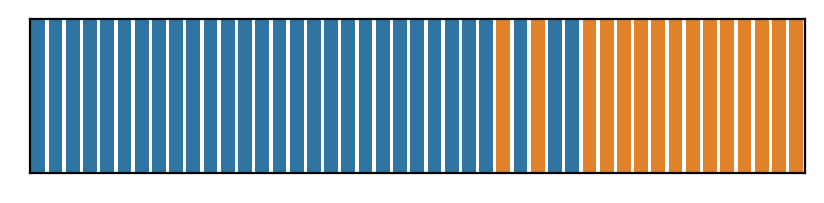

In [42]:
adata_2=adata[adata.obs["Sample"] == "Muscle_2"]
data_2=pd.DataFrame(adata_2.obs)
data_2['Transcript counts'] = [10]*len(adata_2.obs)
# Define bar properties
bar_heights = list(np.log10(data_2['Transcript counts']))
sections = [str(i) for i in data_2['Section']]
labels = list(data_2['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})


palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
}

plt.figure(figsize=(5, 1))
sns.barplot(data=df, x="Section", hue="Leiden cluster", y="Transcript counts", palette=palette, order=df['Section'], dodge = False)
plt.xlabel(None)
plt.ylabel(None)
plt.ylim([0, 1])
plt.xticks([]),plt.yticks([])
plt.legend('',frameon=False)
plt.savefig('M2_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight') 
plt.show()

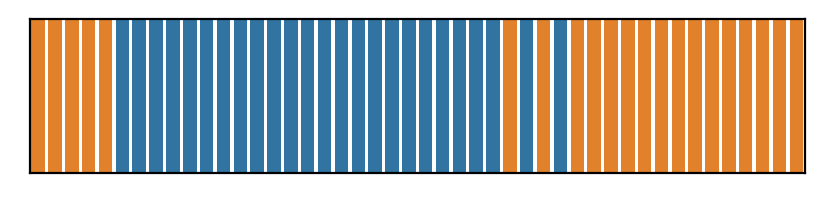

In [43]:
adata_3=adata[adata.obs["Sample"] == "Muscle_3"]
data_3=pd.DataFrame(adata_3.obs)
data_3['Transcript counts'] = [10]*len(adata_3.obs)
# Define bar properties
bar_heights = list(np.log10(data_3['Transcript counts']))
sections = [str(i) for i in data_3['Section']]
labels = list(data_3['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})


palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
}

plt.figure(figsize=(5, 1))
sns.barplot(data=df, x="Section", hue="Leiden cluster", y="Transcript counts", palette=palette, order=df['Section'], dodge = False)
plt.xlabel(None)
plt.ylabel(None)
plt.ylim([0, 1])
plt.xticks([]),plt.yticks([])
plt.legend('',frameon=False)
plt.savefig('M3_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight') 
plt.show()

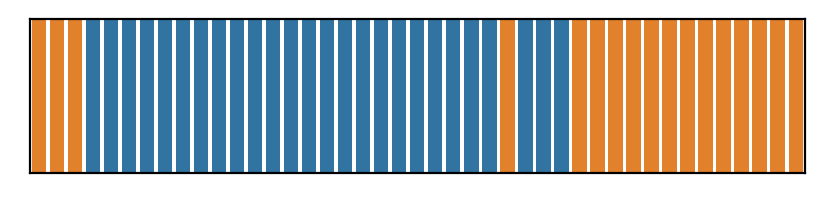

In [44]:
adata_4=adata[adata.obs["Sample"] == "Muscle_4"]
data_4=pd.DataFrame(adata_4.obs)
data_4['Transcript counts'] = [10]*len(adata_4.obs)
# Define bar properties
bar_heights = list(np.log10(data_4['Transcript counts']))
sections = [str(i) for i in data_4['Section']]
labels = list(data_4['leiden'])

# Build dataframe
df = pd.DataFrame({'Transcript counts': bar_heights,
                   'Section': sections,
                   'Leiden cluster': labels})


palette = {
    'Central': 'tab:blue',
    'Proximal-distal': 'tab:orange',
}

plt.figure(figsize=(5, 1))
sns.barplot(data=df, x="Section", hue="Leiden cluster", y="Transcript counts", palette=palette, order=df['Section'], dodge = False)
plt.xlabel(None)
plt.ylabel(None)
plt.ylim([0, 1])
plt.xticks([]),plt.yticks([])
plt.legend('',frameon=False)
plt.savefig('M4_clusters.svg', format = 'svg', dpi=300, bbox_inches='tight') 
plt.show()

### DEG analysis

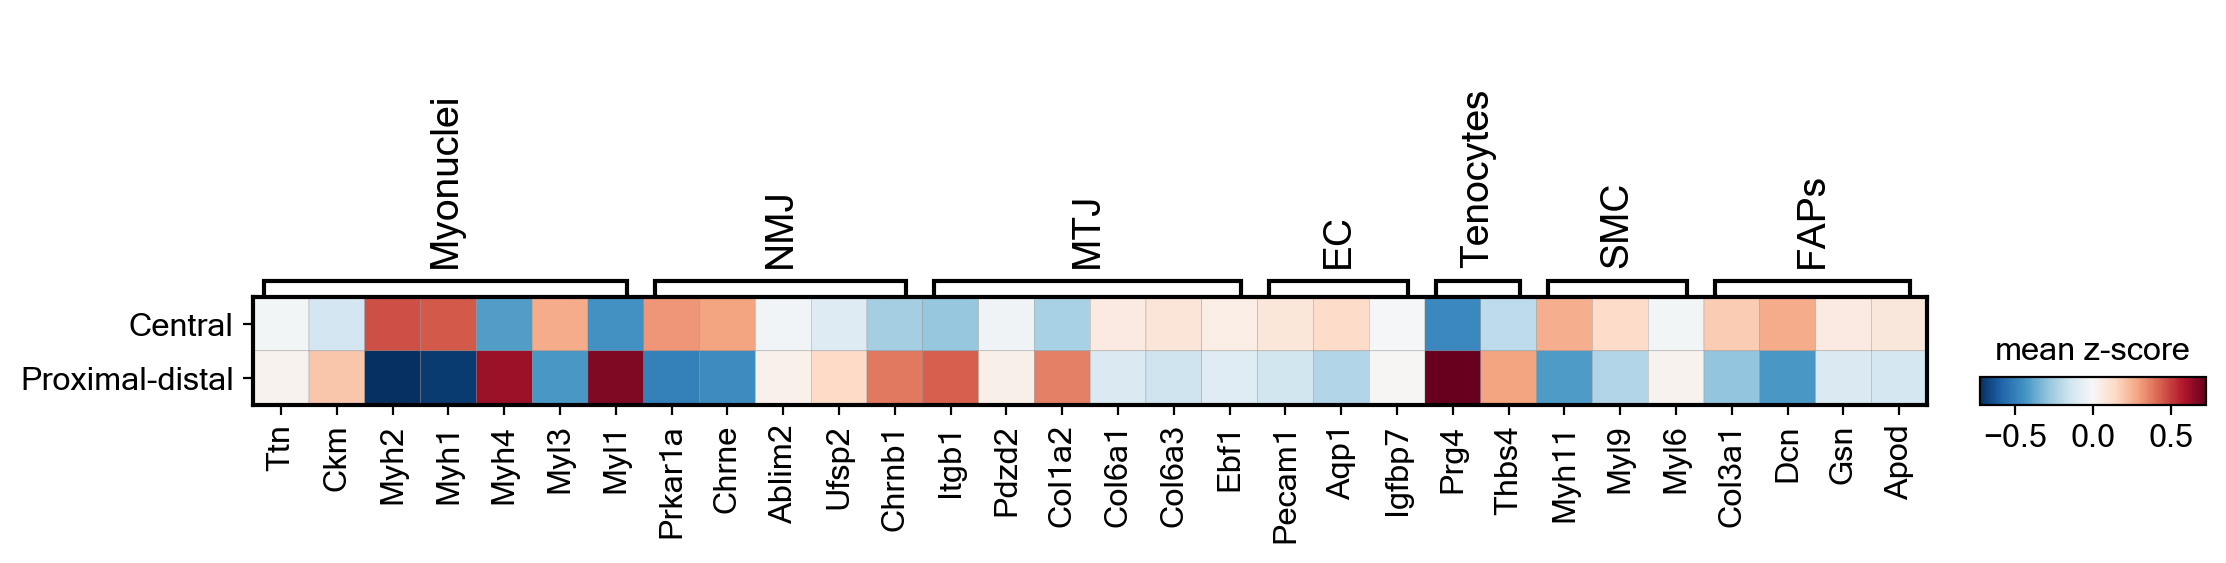

In [45]:
#Compare data to snRNAseq marker genes for MTJ, NMJ, myonuclei, FAPs, Endothelial, etc.
marker_genes_dict = {
    'Myonuclei': ['Ttn', 'Ckm', 'Myh2', 'Myh1', 'Myh4', 'Myl3', 'Myl1'],
    'NMJ': ['Prkar1a', 'Chrne', 'Ablim2', 'Ufsp2', 'Chrnb1'],
    'MTJ': ['Itgb1', 'Pdzd2', 'Col1a2', 'Col6a1', 'Col6a3', 'Ebf1'],
    'EC': ['Pecam1', 'Aqp1', 'Igfbp7'],
    'Tenocytes': ['Prg4', 'Thbs4'],
    'SMC': ['Myh11', 'Myl9', 'Myl6'],
    'FAPs': ['Col3a1', 'Dcn', 'Gsn', 'Apod']
}

#Compare data to snRNAseq marker genes for MTJ, NMJ, myonuclei, FAPs, Endothelial, etc.
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 14
sc.pl.matrixplot(adata, marker_genes_dict, groupby='leiden',  cmap='RdBu_r', gene_symbols='gene_name', colorbar_title='mean z-score', show=False);
plt.savefig('cluster-composition.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()




In [46]:
gene_ids = adata.var.index.values 
clusters = adata.obs['leiden'].cat.categories 
obs = adata[:,gene_ids].X.toarray() 
obs = pd.DataFrame(obs,columns=gene_ids,index=adata.obs['leiden'])
marker_genes = ['Ttn', 'Ckm', 'Myh2', 'Myh1', 'Myh4', 'Myl3', 'Myl1','Prkar1a', 'Chrne', 'Ablim2', 'Ufsp2', 'Chrnb1','Itgb1', 'Pdzd2', 'Col1a2', 'Col6a1', 'Col6a3', 'Ebf1', 'Pecam1', 'Aqp1', 'Igfbp7', 'Prg4', 'Thbs4', 'Myh11', 'Myl9', 'Myl6','Col3a1', 'Dcn', 'Gsn', 'Apod']
out = [id for id in obs.columns if any(g in id for g in marker_genes)]
average_obs = obs.groupby(level=0).mean() 
average_obs=average_obs[out]
average_obs.T.to_excel("cluster-composition_average.xlsx") 
average_obs

ENSMUSG00000001119_Col6a1_ProteinCoding  \
leiden                                                     
Central                                         0.066677   
Proximal-distal                                -0.103499   

                 ENSMUSG00000004655_Aqp1_ProteinCoding  \
leiden                                                   
Central                                       0.138236   
Proximal-distal                              -0.214576   

                 ENSMUSG00000006014_Prg4_ProteinCoding  \
leiden                                                   
Central                                      -0.468497   
Proximal-distal                               0.727219   

                 ENSMUSG00000014609_Chrne_ProteinCoding  \
leiden                                                    
Central                                        0.292171   
Proximal-distal                               -0.453519   

                 ENSMUSG00000018830_Myh11_ProteinCoding  \
leiden                                                    
Central                                        0.262389   
Proximal-distal                               -0.407291   

                 ENSMUSG00000019929_Dcn_ProteinCoding  \
leiden                                                  
Central                                      0.270050   
Proximal-distal                             -0.419182   

                 ENSMUSG00000020612_Prkar1a_ProteinCoding  \
leiden                                                      
Central                                          0.319976   
Proximal-distal                                 -0.496679   

                 ENSMUSG00000020717_Pecam1_ProteinCoding  \
leiden                                                     
Central                                         0.089230   
Proximal-distal                                -0.138506   

                 ENSMUSG00000021622_Ckmt2_ProteinCoding  \
leiden                                                    
Central                                        0.534497   
Proximal-distal                               -0.829667   

                 ENSMUSG00000021702_Thbs4_ProteinCoding  ...  \
leiden                                                   ...   
Central                                       -0.189521  ...   
Proximal-distal                                0.294183  ...   

                 ENSMUSG00000048126_Col6a3_ProteinCoding  \
leiden                                                     
Central                                         0.095979   
Proximal-distal                                -0.148982   

                 ENSMUSG00000051747_Ttn_ProteinCoding  \
leiden                                                  
Central                                     -0.018259   
Proximal-distal                              0.028342   

                 ENSMUSG00000056328_Myh1_ProteinCoding  \
leiden                                                   
Central                                       0.445048   
Proximal-distal                              -0.690821   

                 ENSMUSG00000057003_Myh4_ProteinCoding  \
leiden                                                   
Central                                      -0.403282   
Proximal-distal                               0.625990   

                 ENSMUSG00000057098_Ebf1_ProteinCoding  \
leiden                                                   
Central                                       0.055397   
Proximal-distal                              -0.085989   

                 ENSMUSG00000059741_Myl3_ProteinCoding  \
leiden                                                   
Central                                       0.272220   
Proximal-distal                              -0.422551   

                 ENSMUSG00000061816_Myl1_ProteinCoding  \
leiden                                                   
Central                                      -0.438602   
Proximal-distal                               0.680

/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/claramartinezmir/venv/base-env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


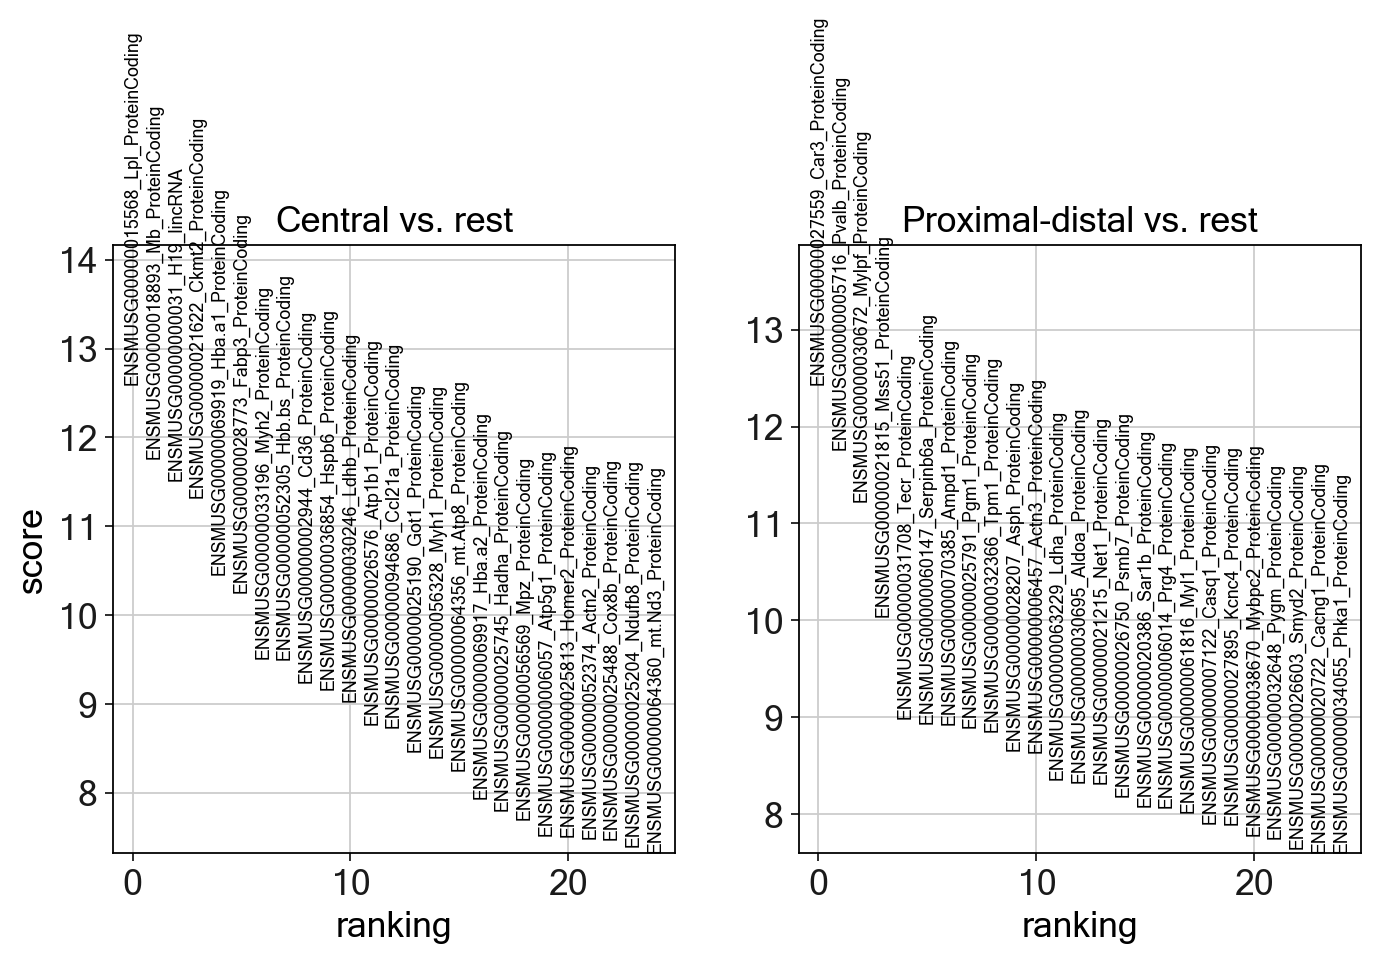

In [47]:
##Finding marker genes
sc.set_figure_params(fontsize=16, figsize=(5,5), color_map='Spectral_r')
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [48]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('ENSMUSG00000015568_Lpl_ProteinCoding', 'ENSMUSG00000027559_Car3_ProteinCoding'),
            ('ENSMUSG00000018893_Mb_ProteinCoding', 'ENSMUSG00000005716_Pvalb_ProteinCoding'),
            ('ENSMUSG00000000031_H19_lincRNA', 'ENSMUSG00000030672_Mylpf_ProteinCoding'),
            ...,
            ('ENSMUSG00000030672_Mylpf_ProteinCoding', 'ENSMUSG00000000031_H19_lincRNA'),
            ('ENSMUSG00000005716_Pvalb_ProteinCoding', 'ENSMUSG00000018893_Mb_ProteinCoding'),
            ('ENSMUSG00000027559_Car3_ProteinCoding', 'ENSMUSG00000015568_Lpl_ProteinCoding')],
           dtype=[('Central', 'O'), ('Proximal-distal', 'O')]),
 'scores': rec.array([( 12.591125,  12.429864), ( 11.765312,  11.763547),
            ( 11.51426 ,  11.226074), ..., (-11.226074, -11.51426 ),
            (-11.763547, -11.765312), (-12.429864, 

In [49]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg_data_noAdj = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals']})

deg_data = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals_adj']})
deg_data

Central_n  Central_s     Central_p  \
0        ENSMUSG00000015568_Lpl_ProteinCoding  12.591125  9.979596e-21   
1         ENSMUSG00000018893_Mb_ProteinCoding  11.765312  6.231995e-19   
2              ENSMUSG00000000031_H19_lincRNA  11.514260  1.837336e-19   
3      ENSMUSG00000021622_Ckmt2_ProteinCoding  11.321798  2.644431e-18   
4     ENSMUSG00000069919_Hba.a1_ProteinCoding  10.452645  3.291169e-17   
...                                       ...        ...           ...   
4109    ENSMUSG00000031708_Tecr_ProteinCoding  -8.985861  5.736622e-13   
4110   ENSMUSG00000021815_Mss51_ProteinCoding -10.045104  5.221850e-14   
4111   ENSMUSG00000030672_Mylpf_ProteinCoding -11.226074  1.116402e-18   
4112   ENSMUSG00000005716_Pvalb_ProteinCoding -11.763547  6.210816e-19   
4113    ENSMUSG00000027559_Car3_ProteinCoding -12.429864  2.346228e-20   

                            Proximal-distal_n  Proximal-distal_s  \
0       ENSMUSG00000027559_Car3_ProteinCoding          12.429864   
1      ENSMUSG00000005716_Pvalb_ProteinCoding          11.763547   
2      ENSMUSG00000030672_Mylpf_ProteinCoding          11.226074   
3      ENSMUSG00000021815_Mss51_ProteinCoding          10.045104   
4       ENSMUSG00000031708_Tecr_ProteinCoding           8.985861   
...                                       ...                ...   
4109  ENSMUSG00000069919_Hba.a1_ProteinCoding         -10.452645   
4110   ENSMUSG00000021622_Ckmt2_ProteinCoding         -11.321798   
4111           ENSMUSG00000000031_H19_lincRNA         -11.514260   
4112      ENSMUSG00000018893_Mb_ProteinCoding         -11.765312   
4113     ENSMUSG00000015568_Lpl_ProteinCoding         -12.591125   

      Proximal-distal_p  
0          2.346228e-20  
1          6.210816e-19  
2          1.116402e-18  
3          5.221850e-14  
4          5.736622e-13  
...                 ...  
4109       3.291169e-17  
4110       2.644431e-18  
4111       1.837336e-19  
4112       6.231995e-19  
4113       9.979596e-21  

[4114 rows x 6 columns]

In [50]:
#separete dataframes and add mean zscore
#add the mean z-score value for each gene from each cluster
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['leiden'].cat.categories)                                                                                                 

for clust in adata.obs.leiden.cat.categories: 
    res.loc[clust] = adata[adata.obs['leiden'].isin([clust]),:].X.mean(0)
res=res.T

#add the z-score diff and pvalues
res['Mean z-score difference'] = res['Central'].sub(res['Proximal-distal'])

data_pvalue=deg_data.set_index('Central_n').drop(['Central_s','Proximal-distal_n', 'Proximal-distal_p', 'Proximal-distal_s'], axis=1)
data_pvalue=data_pvalue.rename(columns={"Central_p": "Central_adj_p"})
proximaldist_score=deg_data.set_index('Proximal-distal_n').drop(['Central_n', 'Central_s', 'Central_p', 'Proximal-distal_p'], axis=1)
data_noAdjpvalue=deg_data_noAdj.set_index('Central_n').drop(['Proximal-distal_n', 'Proximal-distal_p', 'Proximal-distal_s'], axis=1)

data_deg_table=pd.concat([res,proximaldist_score], axis=1)
data_deg_table=pd.concat([data_deg_table,data_noAdjpvalue], axis=1)
data_deg_table=pd.concat([data_deg_table,data_pvalue], axis=1)
data_deg_table=data_deg_table.drop(['Proximal-distal','Central'], axis=1)
data_deg_table=data_deg_table.rename(columns={"Central_p": "p_value", "Central_adj_p": "adj_p_value"})
data_deg_table.to_excel("deg_data_pvalues.xlsx") 
data_deg_table

Mean z-score difference  \
ENSMUSG00000000031_H19_lincRNA                            1.331939   
ENSMUSG00000000056_Narf_ProteinCoding                     -0.16508   
ENSMUSG00000000078_Klf6_ProteinCoding                     0.199771   
ENSMUSG00000000085_Scmh1_ProteinCoding                   -0.013495   
ENSMUSG00000000088_Cox5a_ProteinCoding                    0.833008   
...                                                            ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding                0.743823   
ENSMUSG00000115987_Vps28_ProteinCoding                    0.011708   
ENSMUSG00000116590_AC154200.1_lincRNA                    -0.112502   
ENSMUSG00000117924_Tmem223_ProteinCoding                  -0.12155   
ENSMUSG00000118346_Tmem179b_ProteinCoding                -0.187541   

                                            Proximal-distal_s  Central_s  \
ENSMUSG00000000031_H19_lincRNA                     -11.514260  11.514260   
ENSMUSG00000000056_Narf_ProteinCoding                0.984629  -0.984629   
ENSMUSG00000000078_Klf6_ProteinCoding               -1.263283   1.263283   
ENSMUSG00000000085_Scmh1_ProteinCoding               0.084829  -0.084829   
ENSMUSG00000000088_Cox5a_ProteinCoding              -5.681613   5.681613   
...                                                       ...        ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding          -5.396659   5.396659   
ENSMUSG00000115987_Vps28_ProteinCoding              -0.073377   0.073377   
ENSMUSG00000116590_AC154200.1_lincRNA                0.672093  -0.672093   
ENSMUSG00000117924_Tmem223_ProteinCoding             0.773741  -0.773741   
ENSMUSG00000118346_Tmem179b_ProteinCoding            1.178781  -1.178781   

                                                 p_value   adj_p_value  
ENSMUSG00000000031_H19_lincRNA              1.339818e-22  1.837336e-19  
ENSMUSG00000000056_Narf_ProteinCoding       3.269434e-01  5.723596e-01  
ENSMUSG00000000078_Klf6_ProteinCoding       2.086327e-01  4.497115e-01  
ENSMUSG00000000085_Scmh1_ProteinCoding      9.325214e-01  9.715272e-01  
ENSMUSG00000000088_Cox5a_ProteinCoding      8.115821e-08  3.063164e-06  
...                                                  ...           ...  
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding  2.317409e-07  7.944851e-06  
ENSMUSG00000115987_Vps28_ProteinCoding      9.416144e-01  9.747865e-01  
ENSMUSG00000116590_AC154200.1_lincRNA       5.029011e-01  7.293044e-01  
ENSMUSG00000117924_Tmem223_ProteinCoding    4.403740e-01  6.787930e-01  
ENSMUSG00000118346_Tmem179b_ProteinCoding   2.405679e-01  4.830144e-01  

[4114 rows x 5 columns]

In [51]:
res

Central Proximal-distal  \
gene_id                                                                
ENSMUSG00000000031_H19_lincRNA              0.521871       -0.810068   
ENSMUSG00000000056_Narf_ProteinCoding       -0.06468        0.100399   
ENSMUSG00000000078_Klf6_ProteinCoding       0.078273       -0.121498   
ENSMUSG00000000085_Scmh1_ProteinCoding     -0.005288        0.008208   
ENSMUSG00000000088_Cox5a_ProteinCoding      0.326383       -0.506625   
...                                              ...             ...   
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding  0.291439       -0.452384   
ENSMUSG00000115987_Vps28_ProteinCoding      0.004587       -0.007121   
ENSMUSG00000116590_AC154200.1_lincRNA       -0.04408        0.068422   
ENSMUSG00000117924_Tmem223_ProteinCoding   -0.047625        0.073925   
ENSMUSG00000118346_Tmem179b_ProteinCoding  -0.073481         0.11406   

                                           Mean z-score difference  
gene_id                                                             
ENSMUSG00000000031_H19_lincRNA                            1.331939  
ENSMUSG00000000056_Narf_ProteinCoding                     -0.16508  
ENSMUSG00000000078_Klf6_ProteinCoding                     0.199771  
ENSMUSG00000000085_Scmh1_ProteinCoding                   -0.013495  
ENSMUSG00000000088_Cox5a_ProteinCoding                    0.833008  
...                                                            ...  
ENSMUSG00000113902_Ndufb1.ps_ProteinCoding                0.743823  
ENSMUSG00000115987_Vps28_ProteinCoding                    0.011708  
ENSMUSG00000116590_AC154200.1_lincRNA                    -0.112502  
ENSMUSG00000117924_Tmem223_ProteinCoding                  -0.12155  
ENSMUSG00000118346_Tmem179b_ProteinCoding                -0.187541  

[4114 rows x 3 columns]

In [52]:
#select DEG based on p value and man z-score diff
deg_list_c1_up = []
deg_list_c1_down = []
for index in deg_data.index:
    #check that the pvale is smaller than 0.05
    if deg_data.iloc[index][2]<=0.05:
        #check that the zscore difference is bigger than 1.0 between Central and Proximal-Distal. 
        #Find the gene name corresponding to every index for each region 
            #deg_data.iloc[index][0] --> Central
            #deg_data.iloc[index][2] --> Proximal-Distal
            #deg_data.iloc[index][4] --> Central_2
            #deg_data.iloc[index][6] --> transition
        if (res.loc[deg_data.iloc[index][0]]['Central']-res.loc[deg_data.iloc[index][0]]['Proximal-distal'])>=0.4:
            deg_list_c1_up.append(deg_data.iloc[index][0])
print(len(deg_list_c1_up))


deg_list_c2_up = []
deg_list_c2_down = []
for index in deg_data.index:
    if deg_data.iloc[index][5]<=0.05:
        if (res.loc[deg_data.iloc[index][3]]['Proximal-distal']-res.loc[deg_data.iloc[index][3]]['Central'])>=0.4:
            deg_list_c2_up.append(deg_data.iloc[index][3])
print(len(deg_list_c2_up))



deg_list=list(dict.fromkeys(deg_list_c1_up+deg_list_c2_up))
print(len(deg_list))

data_deg={}
for key in data_genes_filtered_normal:
    data_deg[key]=data_genes_filtered_normal[key].loc[deg_list]
data_deg

398
288
686


{'Muscle_1':                                                   001          002  \
 new_gene                                                             
 ENSMUSG00000015568_Lpl_ProteinCoding       102.106895    95.015603   
 ENSMUSG00000018893_Mb_ProteinCoding       1518.684082  1361.680333   
 ENSMUSG00000000031_H19_lincRNA             525.703164   648.449576   
 ENSMUSG00000021622_Ckmt2_ProteinCoding     139.201480   190.853658   
 ENSMUSG00000069919_Hba.a1_ProteinCoding    434.455107   204.612781   
 ...                                               ...          ...   
 ENSMUSG00000024548_Setbp1_ProteinCoding      2.824165     2.703446   
 ENSMUSG00000078941_Ak6_ProteinCoding         8.474564     8.112320   
 ENSMUSG00000027637_Rab5if_ProteinCoding     11.300799    21.646076   
 ENSMUSG00000028964_Park7_ProteinCoding      48.104837    29.774278   
 ENSMUSG00000079278_Tmem233_ProteinCoding     8.474564    27.064214   
 
                                                   003         

In [53]:
#calculate the szcores
data_deg_zscores = zscores(data_deg)
data_deg_zscores

{'Muscle_1':                                                001       002       003  \
 new_gene                                                                 
 ENSMUSG00000015568_Lpl_ProteinCoding     -0.948932 -1.150101  0.563149   
 ENSMUSG00000018893_Mb_ProteinCoding       0.228222 -0.504750  0.121778   
 ENSMUSG00000000031_H19_lincRNA           -1.036785 -0.373270  0.263263   
 ENSMUSG00000021622_Ckmt2_ProteinCoding   -1.345129  0.146068 -0.024021   
 ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.541062 -1.453766 -1.150003   
 ...                                            ...       ...       ...   
 ENSMUSG00000024548_Setbp1_ProteinCoding  -1.243572 -1.284722  1.068093   
 ENSMUSG00000078941_Ak6_ProteinCoding      0.275729  0.139859  2.503464   
 ENSMUSG00000027637_Rab5if_ProteinCoding  -1.726595  0.437611 -0.068735   
 ENSMUSG00000028964_Park7_ProteinCoding    1.053491 -0.855675  2.068159   
 ENSMUSG00000079278_Tmem233_ProteinCoding -2.397377  0.942048 -0.466063   
 
           

In [54]:
#Now let's normalize the Z score to scaled Z score (-1 to 1)
#Calculate scaled zscors
data_deg_scaled_zscores = scaledZscores(data_deg_zscores)
data_deg_scaled_zscores

{'Muscle_1':                                                001       002       003  \
 new_gene                                                                 
 ENSMUSG00000015568_Lpl_ProteinCoding     -0.375701 -0.472522  0.352051   
 ENSMUSG00000018893_Mb_ProteinCoding       0.306266 -0.032696  0.257041   
 ENSMUSG00000000031_H19_lincRNA           -0.553308 -0.219498  0.100738   
 ENSMUSG00000021622_Ckmt2_ProteinCoding   -0.582340  0.218478  0.127135   
 ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.486367 -0.959228 -0.801852   
 ...                                            ...       ...       ...   
 ENSMUSG00000024548_Setbp1_ProteinCoding  -0.613204 -0.629738  0.315601   
 ENSMUSG00000078941_Ak6_ProteinCoding     -0.077452 -0.143166  1.000000   
 ENSMUSG00000027637_Rab5if_ProteinCoding  -0.605114  0.338612  0.117814   
 ENSMUSG00000028964_Park7_ProteinCoding    0.422525 -0.396721  0.857931   
 ENSMUSG00000079278_Tmem233_ProteinCoding -1.000000  0.509458 -0.127024   
 
           

In [55]:
#save data 
saveCSV(data_deg, label = 'data_deg')
saveCSV(data_deg_zscores, label = 'data_deg_zscores')
saveCSV(data_deg_scaled_zscores, label = 'data_deg_scaled_zscores')
for key in data_deg_scaled_zscores:
    data_deg_scaled_zscores[key].to_excel('deg_'+key+'.xlsx')

Files saved
Files saved
Files saved


In [56]:
adata

AnnData object with n_obs × n_vars = 171 × 4114
    obs: 'Section', 'Sample', 'Region', 'leiden', 'Transcript counts', 'PC1', 'PC2', 'color'
    var: 'gene_id', 'gene_name'
    uns: 'pca', 'Sample_colors', 'Region_colors', 'Section_colors', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [58]:
adata_plot=adata[adata.obs["leiden"] == "Central"]
ann=pd.DataFrame(adata_plot.obs)
df_c=adata[adata.obs["leiden"] == "Central"].to_df().T
df_a=adata[adata.obs["leiden"] == "Proximal-distal"].to_df().T
df_plot=pd.concat([df_c, df_a], axis=1).loc[data_deg_scaled_zscores['Muscle_1'].index]
df_plot

0         1         4  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding     -0.948932 -1.150101  0.806315   
ENSMUSG00000018893_Mb_ProteinCoding       0.228222 -0.504750  1.305519   
ENSMUSG00000000031_H19_lincRNA           -1.036785 -0.373270  1.227004   
ENSMUSG00000021622_Ckmt2_ProteinCoding   -1.345129  0.146068  1.597967   
ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.541062 -1.453766  0.259964   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -1.243572 -1.284722 -1.061920   
ENSMUSG00000078941_Ak6_ProteinCoding      0.275729  0.139859 -0.803777   
ENSMUSG00000027637_Rab5if_ProteinCoding  -1.726595  0.437611  1.777509   
ENSMUSG00000028964_Park7_ProteinCoding    1.053491 -0.855675 -0.566040   
ENSMUSG00000079278_Tmem233_ProteinCoding -2.397377  0.942048  0.310991   

                                                 5         6         7  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding      1.050516  0.279064  0.269999   
ENSMUSG00000018893_Mb_ProteinCoding       1.040872  0.511540  1.661891   
ENSMUSG00000000031_H19_lincRNA            1.785570  2.050725  1.350514   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.967230  0.332262  1.116413   
ENSMUSG00000069919_Hba.a1_ProteinCoding   1.370194  1.600776  2.327884   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -1.026297 -0.607781  1.258162   
ENSMUSG00000078941_Ak6_ProteinCoding      2.039336  0.911263  0.909164   
ENSMUSG00000027637_Rab5if_ProteinCoding   1.435178 -0.158033  0.880066   
ENSMUSG00000028964_Park7_ProteinCoding   -0.404399 -0.604930  0.296180   
ENSMUSG00000079278_Tmem233_ProteinCoding -0.427648  0.870217  1.880236   

                                                 8         9        10  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding      1.020210  1.909419  0.868182   
ENSMUSG00000018893_Mb_ProteinCoding       1.096157  1.728355  0.529462   
ENSMUSG00000000031_H19_lincRNA            1.423106  0.857407  1.323363   
ENSMUSG00000021622_Ckmt2_ProteinCoding    1.601333  0.056140 -0.120390   
ENSMUSG00000069919_Hba.a1_ProteinCoding   0.433653  1.533374  0.994522   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding   0.411542 -0.094790  0.650559   
ENSMUSG00000078941_Ak6_ProteinCoding     -1.103253 -0.191998  0.869748   
ENSMUSG00000027637_Rab5if_ProteinCoding  -1.075792 -0.847552  0.823838   
ENSMUSG00000028964_Park7_ProteinCoding   -0.042578 -0.937913  0.067405   
ENSMUSG00000079278_Tmem233_ProteinCoding  0.227092 -0.390467 -1.208455   

                                                11  ...       161       162  \
new_gene                                            ...                       
ENSMUSG00000015568_Lpl_ProteinCoding      0.851362  ... -0.825705 -1.238098   
ENSMUSG00000018893_Mb_ProteinCoding       0.901420  ... -0.959669 -1.641413   
ENSMUSG00000000031_H19_lincRNA            0.629451  ... -0.578593  0.056750   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.291676  ... -0.964421 -1.780723   
ENSMUSG00000069919_Hba.a1_ProteinCoding   1.013311  ... -0.756247 -0.923471   
...                                            ...  ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding   2.771467  ...  0.599785 -0.916669   
ENSMUSG00000078941_Ak6_ProteinCoding     -0.798332  ... -1.041576 -0.807581   
ENSMUSG00000027637_Rab5if_ProteinCoding   1.084815  ...  1.036856 -0.544433   
ENSMUSG00000028964_Park7_ProteinCoding    0.384810  ...  0.190437 -0.327690   
ENSMUSG00000079278_Tmem233_ProteinCoding  0.929707  ... -0.538118 -0.624843   

                                               163       164       165  \
new_gene                                                  

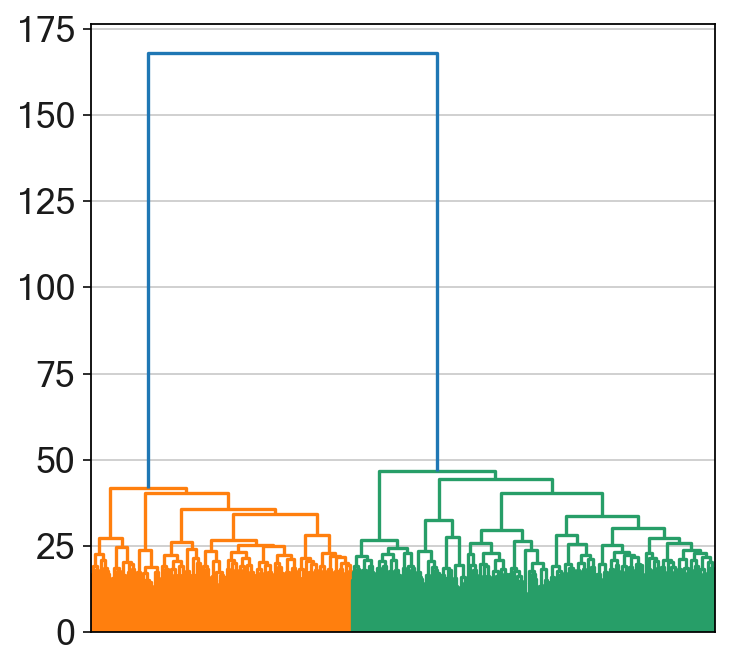

In [59]:
#calculate the clustering for each dataset
Z, dg = hierarchicalClustering(df_plot, plot = True, cth = 55)

clusters = getClusterByColor(dg, labels=df_plot.index)


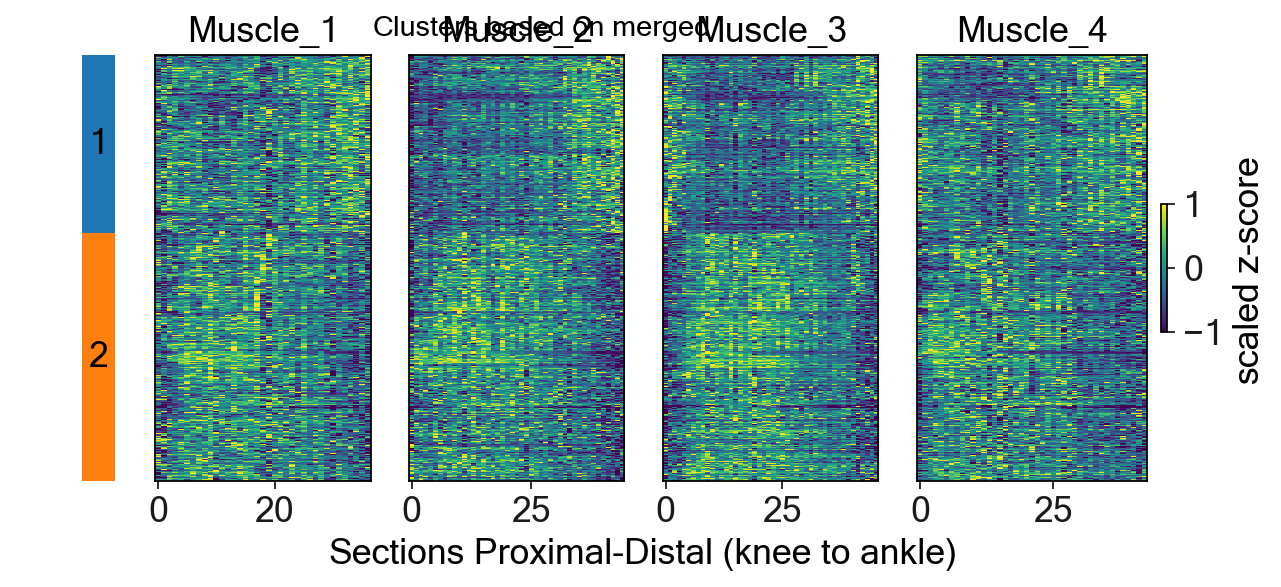

In [60]:
#Use the clustering to plot the indivudal figures
plotHeatmap(data_deg_scaled_zscores, dg, clusters, title='Clusters based on merged', figsize=(9,3.5), type_data = 'scaled z-score')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('DEG_heatmap.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()


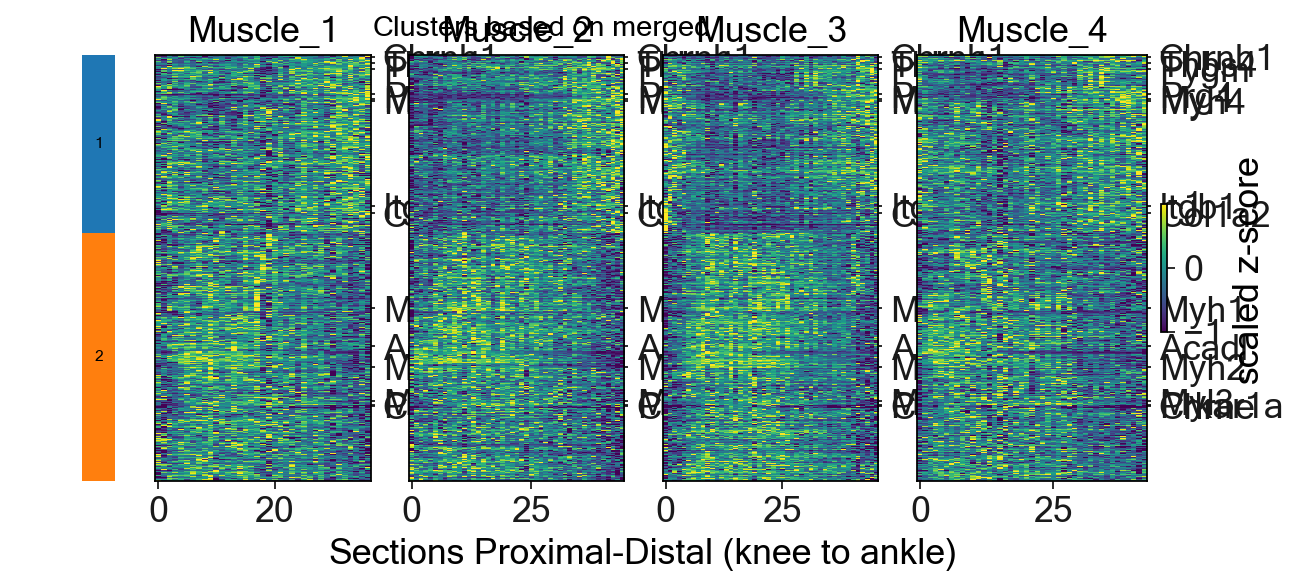

In [61]:
#Use the clustering to plot the indivudal figures
plotHeatmapAnn(data_deg_scaled_zscores, dg, clusters, title='Clusters based on merged', figsize=(9,3.5), type_data = 'scaled z-score', g_annotate=['Myh2', 'Myh1', 'Myh4', 'Myl3', 'Myl1', 'Prkar1a', 'Chrne', 'Chrnb1', 'Itgb1', 'Col1a2','Prg4', 'Thbs4', 'Acadl', 'Pygm'])
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('DEG_heatmap_ann.svg', format = 'svg', dpi=300, bbox_inches='tight')   
plt.show()
plt.close()


In [62]:
#get the genes ids from each cluster to do GO analyses
ClusterGeneNames(data_deg_scaled_zscores['Muscle_3'], clusters, dg, file_name = '686-DEG_clusterGeneNames_hierarchical_merged.txt')


686-DEG_clusterGeneNames_hierarchical_merged.txt


Gene onthology analysis with panther (http://geneontology.org/) and website to plot dotplot results 
http://www.bioinformatics.com.cn/plot_basic_gopathway_enrichment_bubbleplot_081_en

## Genes to look at

In [63]:
path = ''
file_names = [path + 'Muscle_1_data_deg.tsv.gz', 
             path + 'Muscle_2_data_deg.tsv.gz',
              path + 'Muscle_3_data_deg.tsv.gz',
              path + 'Muscle_4_data_deg.tsv.gz']
labels = ['Muscle_1','Muscle_2','Muscle_3','Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_deg = accessData(file_names, labels)
data_deg['Muscle_1']

001          002  \
new_gene                                                             
ENSMUSG00000015568_Lpl_ProteinCoding       102.106895    95.015603   
ENSMUSG00000018893_Mb_ProteinCoding       1518.684082  1361.680333   
ENSMUSG00000000031_H19_lincRNA             525.703164   648.449576   
ENSMUSG00000021622_Ckmt2_ProteinCoding     139.201480   190.853658   
ENSMUSG00000069919_Hba.a1_ProteinCoding    434.455107   204.612781   
...                                               ...          ...   
ENSMUSG00000024548_Setbp1_ProteinCoding      2.824165     2.703446   
ENSMUSG00000078941_Ak6_ProteinCoding         8.474564     8.112320   
ENSMUSG00000027637_Rab5if_ProteinCoding     11.300799    21.646076   
ENSMUSG00000028964_Park7_ProteinCoding      48.104837    29.774278   
ENSMUSG00000079278_Tmem233_ProteinCoding     8.474564    27.064214   

                                                  003          004  \
new_gene                                                             
ENSMUSG00000015568_Lpl_ProteinCoding       155.408216   164.753935   
ENSMUSG00000018893_Mb_ProteinCoding       1495.883518  1555.250267   
ENSMUSG00000000031_H19_lincRNA             766.204651   822.846731   
ENSMUSG00000021622_Ckmt2_ProteinCoding     184.962088   208.543574   
ENSMUSG00000069919_Hba.a1_ProteinCoding    281.108230   370.550871   
...                                               ...          ...   
ENSMUSG00000024548_Setbp1_ProteinCoding      9.605776     5.933058   
ENSMUSG00000078941_Ak6_ProteinCoding        14.413950     3.389076   
ENSMUSG00000027637_Rab5if_ProteinCoding     19.225655    22.088415   
ENSMUSG00000028964_Park7_ProteinCoding      57.847020    40.032314   
ENSMUSG00000079278_Tmem233_ProteinCoding    19.225655    23.793364   

                                                  005          006  \
new_gene                                                             
ENSMUSG00000015568_Lpl_ProteinCoding       163.979915   172.588052   
ENSMUSG00000018893_Mb_ProteinCoding       1749.442477  1692.754852   
ENSMUSG00000000031_H19_lincRNA             944.491446  1047.822927   
ENSMUSG00000021622_Ckmt2_ProteinCoding     241.144624   219.297119   
ENSMUSG00000069919_Hba.a1_ProteinCoding    636.173780   915.758088   
...                                               ...          ...   
ENSMUSG00000024548_Setbp1_ProteinCoding      3.357068     3.461574   
ENSMUSG00000078941_Ak6_ProteinCoding         5.596481    13.176534   
ENSMUSG00000027637_Rab5if_ProteinCoding     28.051016    26.414618   
ENSMUSG00000028964_Park7_ProteinCoding      32.555158    34.107131   
ENSMUSG00000079278_Tmem233_ProteinCoding    23.551297    19.439498   

                                                  007          008  \
new_gene                                                             
ENSMUSG00000015568_Lpl_ProteinCoding       145.394149   145.074606   
ENSMUSG00000018893_Mb_ProteinCoding       1579.371020  1825.778041   
ENSMUSG00000000031_H19_lincRNA            1096.875150   967.340118   
ENSMUSG00000021622_Ckmt2_ProteinCoding     197.303060   224.464510   
ENSMUSG00000069919_Hba.a1_ProteinCoding    973.824615  1156.928872   
...                                               ...          ...   
ENSMUSG00000024548_Setbp1_ProteinCoding      4.689353    10.163372   
ENSMUSG00000078941_Ak6_ProteinCoding        10.168966    10.163372   
ENSMUSG00000027637_Rab5if_ProteinCoding     18.798797    23.761087   
ENSMUSG00000028964_Park7_ProteinCoding      32.181770    40.833637   
ENSMUSG00000079278_Tmem233_ProteinCoding    26.664352    32.286844   

                                                  009          010  ...  \
new_gene                                                            ...   
ENSMUSG00000015568_Lpl_ProteinCoding       171.519773   202.864662  ...   
ENSMUSG00000018893_Mb_ProteinCoding       1704.596834  1840.014725  ...   
ENSMUSG00000000031_H19_lincRNA             980.769105   876.118015  ...   
ENSMUSG00000021622_Ckmt2_Protei

In [64]:
path = ''
file_names = [path + 'Muscle_1_data_deg_zscores.tsv.gz', 
             path + 'Muscle_2_data_deg_zscores.tsv.gz',
              path + 'Muscle_3_data_deg_zscores.tsv.gz',
              path + 'Muscle_4_data_deg_zscores.tsv.gz']
labels = ['Muscle_1','Muscle_2','Muscle_3','Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_deg_zscores = accessData(file_names, labels)
data_deg_zscores['Muscle_1']

001       002       003  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding     -0.948932 -1.150101  0.563149   
ENSMUSG00000018893_Mb_ProteinCoding       0.228222 -0.504750  0.121778   
ENSMUSG00000000031_H19_lincRNA           -1.036785 -0.373270  0.263263   
ENSMUSG00000021622_Ckmt2_ProteinCoding   -1.345129  0.146068 -0.024021   
ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.541062 -1.453766 -1.150003   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -1.243572 -1.284722  1.068093   
ENSMUSG00000078941_Ak6_ProteinCoding      0.275729  0.139859  2.503464   
ENSMUSG00000027637_Rab5if_ProteinCoding  -1.726595  0.437611 -0.068735   
ENSMUSG00000028964_Park7_ProteinCoding    1.053491 -0.855675  2.068159   
ENSMUSG00000079278_Tmem233_ProteinCoding -2.397377  0.942048 -0.466063   

                                               004       005       006  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding      0.828273  0.806315  1.050516   
ENSMUSG00000018893_Mb_ProteinCoding       0.398932  1.305519  1.040872   
ENSMUSG00000000031_H19_lincRNA            0.569445  1.227004  1.785570   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.656775  1.597967  0.967230   
ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.794826  0.259964  1.370194   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.183836 -1.061920 -1.026297   
ENSMUSG00000078941_Ak6_ProteinCoding     -1.631727 -0.803777  2.039336   
ENSMUSG00000027637_Rab5if_ProteinCoding   0.530147  1.777509  1.435178   
ENSMUSG00000028964_Park7_ProteinCoding    0.212721 -0.566040 -0.404399   
ENSMUSG00000079278_Tmem233_ProteinCoding  0.354476  0.310991 -0.427648   

                                               007       008       009  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding      0.279064  0.269999  1.020210   
ENSMUSG00000018893_Mb_ProteinCoding       0.511540  1.661891  1.096157   
ENSMUSG00000000031_H19_lincRNA            2.050725  1.350514  1.423106   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.332262  1.116413  1.601333   
ENSMUSG00000069919_Hba.a1_ProteinCoding   1.600776  2.327884  0.433653   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.607781  1.258162  0.411542   
ENSMUSG00000078941_Ak6_ProteinCoding      0.911263  0.909164 -1.103253   
ENSMUSG00000027637_Rab5if_ProteinCoding  -0.158033  0.880066 -1.075792   
ENSMUSG00000028964_Park7_ProteinCoding   -0.604930  0.296180 -0.042578   
ENSMUSG00000079278_Tmem233_ProteinCoding  0.870217  1.880236  0.227092   

                                               010  ...       028       029  \
new_gene                                            ...                       
ENSMUSG00000015568_Lpl_ProteinCoding      1.909419  ... -0.157923  0.159564   
ENSMUSG00000018893_Mb_ProteinCoding       1.728355  ... -0.654425  0.829001   
ENSMUSG00000000031_H19_lincRNA            0.857407  ... -0.489972 -0.159462   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.056140  ... -0.431565  0.546487   
ENSMUSG00000069919_Hba.a1_ProteinCoding   1.533374  ... -0.725254  0.491837   
...                                            ...  ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.094790  ...  0.479642  0.027866   
ENSMUSG00000078941_Ak6_ProteinCoding     -0.191998  ... -0.317222  0.570635   
ENSMUSG00000027637_Rab5if_ProteinCoding  -0.847552  ... -0.170552 -0.692842   
ENSMUSG00000028964_Park7_ProteinCoding   -0.937913  ...  1.095201 -0.882722   
ENSMUSG00000079278_Tmem233_ProteinCoding -0.390467  ... -0.198240  0.047400   

                                               030       031       032  \
new_gene                                                

In [65]:
path = ''
file_names = [path + 'Muscle_1_data_deg_scaled_zscores.tsv.gz', 
             path + 'Muscle_2_data_deg_scaled_zscores.tsv.gz',
              path + 'Muscle_3_data_deg_scaled_zscores.tsv.gz',
              path + 'Muscle_4_data_deg_scaled_zscores.tsv.gz']
labels = ['Muscle_1','Muscle_2','Muscle_3','Muscle_4']

#use accessData() function to obtain a dictonary with each dataset with labels as key
data_deg_scaled_zscores = accessData(file_names, labels)
data_deg_scaled_zscores['Muscle_1']

001       002       003  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding     -0.375701 -0.472522  0.352051   
ENSMUSG00000018893_Mb_ProteinCoding       0.306266 -0.032696  0.257041   
ENSMUSG00000000031_H19_lincRNA           -0.553308 -0.219498  0.100738   
ENSMUSG00000021622_Ckmt2_ProteinCoding   -0.582340  0.218478  0.127135   
ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.486367 -0.959228 -0.801852   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.613204 -0.629738  0.315601   
ENSMUSG00000078941_Ak6_ProteinCoding     -0.077452 -0.143166  1.000000   
ENSMUSG00000027637_Rab5if_ProteinCoding  -0.605114  0.338612  0.117814   
ENSMUSG00000028964_Park7_ProteinCoding    0.422525 -0.396721  0.857931   
ENSMUSG00000079278_Tmem233_ProteinCoding -1.000000  0.509458 -0.127024   

                                               004       005       006  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding      0.479653  0.469085  0.586617   
ENSMUSG00000018893_Mb_ProteinCoding       0.385210  0.804460  0.682075   
ENSMUSG00000000031_H19_lincRNA            0.254777  0.585591  0.866602   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.492744  0.998193  0.659468   
ENSMUSG00000069919_Hba.a1_ProteinCoding  -0.617839 -0.071365  0.503832   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.187412 -0.540218 -0.525905   
ENSMUSG00000078941_Ak6_ProteinCoding     -1.000000 -0.599559  0.775523   
ENSMUSG00000027637_Rab5if_ProteinCoding   0.378964  0.922890  0.773613   
ENSMUSG00000028964_Park7_ProteinCoding    0.061740 -0.272435 -0.203073   
ENSMUSG00000079278_Tmem233_ProteinCoding  0.243868  0.224213 -0.109660   

                                               007       008       009  \
new_gene                                                                 
ENSMUSG00000015568_Lpl_ProteinCoding      0.215324  0.210961  0.572031   
ENSMUSG00000018893_Mb_ProteinCoding       0.437286  0.969264  0.707641   
ENSMUSG00000000031_H19_lincRNA            1.000000  0.647728  0.684248   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.318470  0.739583  1.000000   
ENSMUSG00000069919_Hba.a1_ProteinCoding   0.623294  1.000000  0.018621   
...                                            ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.357749  0.391969  0.051805   
ENSMUSG00000078941_Ak6_ProteinCoding      0.229926  0.228911 -0.744402   
ENSMUSG00000027637_Rab5if_ProteinCoding   0.078875  0.531550 -0.321324   
ENSMUSG00000028964_Park7_ProteinCoding   -0.289123  0.097554 -0.047811   
ENSMUSG00000079278_Tmem233_ProteinCoding  0.476989  0.933529  0.186289   

                                               010  ...       028       029  \
new_gene                                            ...                       
ENSMUSG00000015568_Lpl_ProteinCoding      1.000000  ...  0.005005  0.157809   
ENSMUSG00000018893_Mb_ProteinCoding       1.000000  ... -0.101912  0.584095   
ENSMUSG00000000031_H19_lincRNA            0.399649  ... -0.278210 -0.111932   
ENSMUSG00000021622_Ckmt2_ProteinCoding    0.170184  ... -0.091728  0.433516   
ENSMUSG00000069919_Hba.a1_ProteinCoding   0.588374  ... -0.581795  0.048766   
...                                            ...  ...       ...       ...   
ENSMUSG00000024548_Setbp1_ProteinCoding  -0.151635  ...  0.079167 -0.102352   
ENSMUSG00000078941_Ak6_ProteinCoding     -0.303670  ... -0.364235  0.065180   
ENSMUSG00000027637_Rab5if_ProteinCoding  -0.221797  ...  0.073416 -0.154334   
ENSMUSG00000028964_Park7_ProteinCoding   -0.432010  ...  0.440423 -0.408327   
ENSMUSG00000079278_Tmem233_ProteinCoding -0.092854  ... -0.005965  0.105067   

                                               030       031       032  \
new_gene                                                

### Pie charts metabolic pathways GO

In [66]:
#access de data
#Create a variable list with the file names and one with the labels to use as dictionary keys
#path = '/Volumes/Clara/Data/re-map_MOUSE-E102/'
path=''
file_names = [path + 'Muscle_1_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz', 
             path + 'Muscle_2_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz',
             path + 'Muscle_3_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz',
             path + 'Muscle_4_genes.t.t.counts_filtered_noRibo_TOMOseq2-4_normal.tsv.gz']
labels = ['Muscle_1', 'Muscle_2', 'Muscle_3', 'Muscle_4']


#use accessData() function to obtain a dictonary with each dataset with labels as key
data_genes_filtered_normal= accessData(file_names, labels)
data_genes_filtered_normal

{'Muscle_1':                                                   001         002         003  \
 new_gene                                                                        
 ENSMUSG00000000031_H19_lincRNA             525.703164  648.449576  766.204651   
 ENSMUSG00000000056_Narf_ProteinCoding        8.474564    2.703446    0.000000   
 ENSMUSG00000000078_Klf6_ProteinCoding        5.649019    2.703446    4.801128   
 ENSMUSG00000000085_Scmh1_ProteinCoding       2.824165    0.000000    1.599985   
 ENSMUSG00000000088_Cox5a_ProteinCoding     164.952214  166.130244  184.962088   
 ...                                               ...         ...         ...   
 ENSMUSG00000115987_Vps28_ProteinCoding      16.955342   21.646076    9.605776   
 ENSMUSG00000116564_Riok2_ProteinCoding       5.649019    5.407553    1.599985   
 ENSMUSG00000116590_AC154200.1_lincRNA      104.956104   75.947139   56.233243   
 ENSMUSG00000117924_Tmem223_ProteinCoding     5.649019    0.000000   16.017459   
 ENS

In [67]:
for key in data_genes_filtered_normal:
    for index in data_genes_filtered_normal[key].index:
        if 'Acad11' in index:
            print(index)

ENSMUSG00000090150_Acad11_ProteinCoding
ENSMUSG00000090150_Acad11_ProteinCoding
ENSMUSG00000090150_Acad11_ProteinCoding


In [68]:
for key in data_genes_filtered_normal:
    for index in data_deg_scaled_zscores[key].index:
        if 'Acss1' in index:
            print(index)

In [69]:
data_charts = pd.read_csv('GO_piecharts2.txt', sep='\t')
data_charts

gene               status                                         type
0    Foxk1         Not detected                       1 Canonical glycolysis
1     Tpi1  AProximal-distal UP                       1 Canonical glycolysis
2      Hk1         Not detected                       1 Canonical glycolysis
3    Aldoa  AProximal-distal UP                       1 Canonical glycolysis
4     Pfkm     Not regionalized                       1 Canonical glycolysis
..     ...                  ...                                          ...
216   Pck2         Not detected  91 Short-chain fatty acid metabolic process
217   Oxsm         Not detected  91 Short-chain fatty acid metabolic process
218   Pck1         Not detected  91 Short-chain fatty acid metabolic process
219   Mmut           Central UP  91 Short-chain fatty acid metabolic process
220   Phyh           Central UP  91 Short-chain fatty acid metabolic process

[221 rows x 3 columns]

In [70]:
data_count=pd.crosstab(data_charts['type'], data_charts['status'])
data_per=data_count.div(data_count.sum(axis=1), axis=0)*100
data_per.to_excel('GO_barchart.xlsx')
data_per

status                                              AProximal-distal UP  \
type                                                                      
1 Canonical glycolysis                                        35.294118   
2 Gycogen catabolic process                                   23.529412   
3 Tricarboxylic acid cycle                                     0.000000   
4 MET, NADH to ubiquinone                                      0.000000   
5 MET, succinate to ubiquinone                                 0.000000   
6 MET, ubiquinol to cytochrome c                               0.000000   
7 MET, cytochrome c to oxygen                                  0.000000   
71 Proton motive force-driven mitochondrial ATP...             0.000000   
8 Carnitine metabolic process, CoA-linked                      0.000000   
9 Fatty acid beta-oxidation using acyl-CoA dehy...             0.000000   
91 Short-chain fatty acid metabolic process                    0.000000   

status                                              Central UP  Not detected  \
type                                                                           
1 Canonical glycolysis                                5.882353     35.294118   
2 Gycogen catabolic process                           0.000000     35.294118   
3 Tricarboxylic acid cycle                           37.500000     18.750000   
4 MET, NADH to ubiquinone                            40.000000     24.000000   
5 MET, succinate to ubiquinone                       60.000000      0.000000   
6 MET, ubiquinol to cytochrome c                     53.846154     15.384615   
7 MET, cytochrome c to oxygen                        55.000000     20.000000   
71 Proton motive force-driven mitochondrial ATP...   53.225806      9.677419   
8 Carnitine metabolic process, CoA-linked           100.000000      0.000000   
9 Fatty acid beta-oxidation using acyl-CoA dehy...   41.666667     41.666667   
91 Short-chain fatty acid metabolic process          26.666667     73.333333   

status                                              Not regionalized  
type                                                                  
1 Canonical glycolysis                                     23.529412  
2 Gycogen catabolic process                                41.176471  
3 Tricarboxylic acid cycle                                 43.750000  
4 MET, NADH to ubiquinone                                  36.000000  
5 MET, succinate to ubiquinone                             40.000000  
6 MET, ubiquinol to cytochrome c                           30.769231  
7 MET, cytochrome c to oxygen                              25.000000  
71 Proton motive force-driven mitochondrial ATP...         37.096774  
8 Carnitine metabolic process, CoA-linked                   0.000000  
9 Fatty acid beta-oxidation using acyl-CoA dehy...         16.666667  
91 Short-chain fatty acid metabolic process                 0.000000

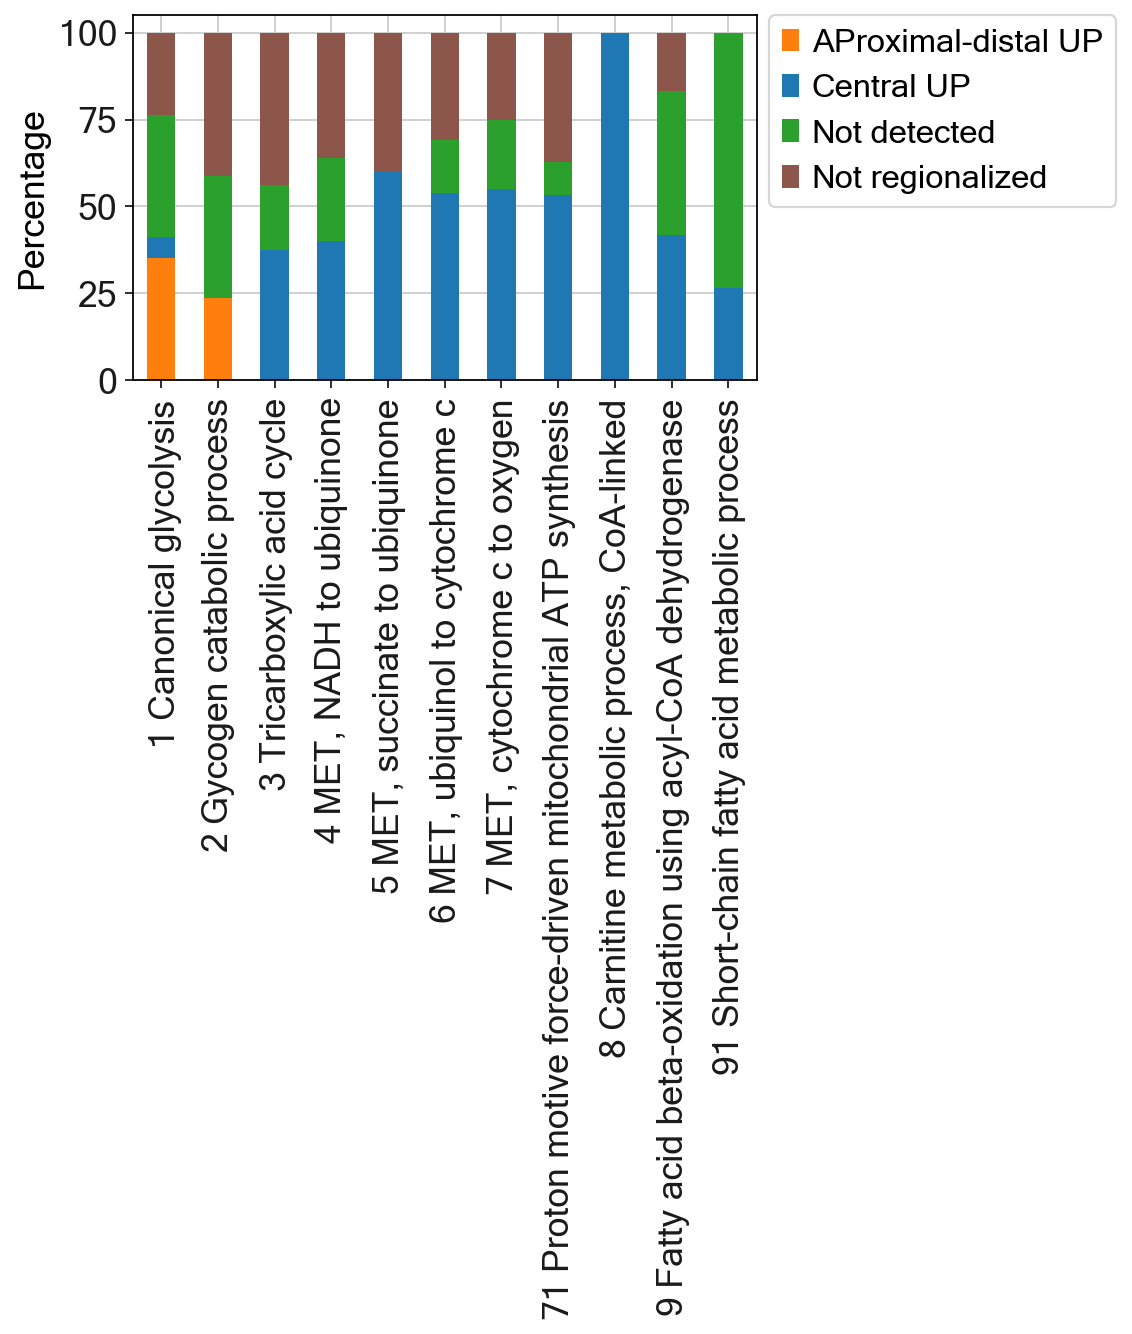

In [71]:

mycolors=['#ff7f0e','#1f77b4','#2ca02c','#8c564b']
ax=data_per.plot(kind='bar', stacked=True, color=mycolors, figsize=(5,3))

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Percentage')
plt.xlabel('')
ax.set_axisbelow(True)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('GO_percentage_bar.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()



### Compare skeletal muscle to tendon

In [72]:
coverage=[]
for key in data_genes_filtered_normal:
    coverage.append(data_genes_filtered_normal[key].sum()[0])
mean_cov=np.mean(coverage)
mean_cov
coverage

[190167.96095399137, 161939.20400793833, 191586.9682475964, 147790.26354707332]

In [73]:
data_genes_filtered_renormal = normalizeTO(data_genes_filtered_normal, factor=mean_cov)
data_genes_filtered_renormal

{'Muscle_1':                                                   001         002         003  \
 new_gene                                                                        
 ENSMUSG00000000031_H19_lincRNA             477.887460  589.469385  696.513963   
 ENSMUSG00000000056_Narf_ProteinCoding        7.703754    2.457552    0.000000   
 ENSMUSG00000000078_Klf6_ProteinCoding        5.135209    2.457552    4.364438   
 ENSMUSG00000000085_Scmh1_ProteinCoding       2.567291    0.000000    1.454457   
 ENSMUSG00000000088_Cox5a_ProteinCoding     149.948869  151.019750  168.138731   
 ...                                               ...         ...         ...   
 ENSMUSG00000115987_Vps28_ProteinCoding      15.413157   19.677242    8.732076   
 ENSMUSG00000116564_Riok2_ProteinCoding       5.135209    4.915705    1.454457   
 ENSMUSG00000116590_AC154200.1_lincRNA       95.409747   69.039313   51.118509   
 ENSMUSG00000117924_Tmem223_ProteinCoding     5.135209    0.000000   14.560580   
 ENS

In [74]:
adata_1=adata[adata.obs["Sample"] == "Muscle_1"]
data_1=pd.DataFrame(adata_1.obs)
data_1['Ckm counts'] = list(data_genes_filtered_normal['Muscle_1'].loc['ENSMUSG00000030399_Ckm_ProteinCoding'])
data_1['Ttn counts'] = list(data_genes_filtered_normal['Muscle_1'].loc['ENSMUSG00000051747_Ttn_ProteinCoding'])
data_1['Prg4 counts'] = list(data_genes_filtered_normal['Muscle_1'].loc['ENSMUSG00000006014_Prg4_ProteinCoding'])



In [75]:
adata_2=adata[adata.obs["Sample"] == "Muscle_2"]
data_2=pd.DataFrame(adata_2.obs)
data_2['Ckm counts'] = list(data_genes_filtered_normal['Muscle_2'].loc['ENSMUSG00000030399_Ckm_ProteinCoding'])
data_2['Ttn counts'] = list(data_genes_filtered_normal['Muscle_2'].loc['ENSMUSG00000051747_Ttn_ProteinCoding'])
data_2['Prg4 counts'] = list(data_genes_filtered_normal['Muscle_2'].loc['ENSMUSG00000006014_Prg4_ProteinCoding'])



In [76]:
adata_3=adata[adata.obs["Sample"] == "Muscle_3"]
data_3=pd.DataFrame(adata_3.obs)
data_3['Ckm counts'] = list(data_genes_filtered_normal['Muscle_3'].loc['ENSMUSG00000030399_Ckm_ProteinCoding'])
data_3['Ttn counts'] = list(data_genes_filtered_normal['Muscle_3'].loc['ENSMUSG00000051747_Ttn_ProteinCoding'])
data_3['Prg4 counts'] = list(data_genes_filtered_normal['Muscle_3'].loc['ENSMUSG00000006014_Prg4_ProteinCoding'])



In [77]:
adata_4=adata[adata.obs["Sample"] == "Muscle_4"]
data_4=pd.DataFrame(adata_4.obs)
data_4['Ckm counts'] = list(data_genes_filtered_normal['Muscle_4'].loc['ENSMUSG00000030399_Ckm_ProteinCoding'])
data_4['Ttn counts'] = list(data_genes_filtered_normal['Muscle_4'].loc['ENSMUSG00000051747_Ttn_ProteinCoding'])
data_4['Prg4 counts'] = list(data_genes_filtered_normal['Muscle_4'].loc['ENSMUSG00000006014_Prg4_ProteinCoding'])



In [78]:
df_1=pd.concat([data_1,data_2])
df_2=pd.concat([data_3,data_4])
data_m=pd.concat([df_1,df_2])
data_m.to_excel("source table F1 F.xlsx") 
data_m

Section    Sample      Region           leiden  Transcript counts  \
0       001  Muscle_1    Proximal          Central      161211.575240   
1       002  Muscle_1    Proximal          Central      188609.317165   
2       003  Muscle_1    Proximal  Proximal-distal      285859.890922   
3       004  Muscle_1    Proximal  Proximal-distal      603433.080500   
4       005  Muscle_1  Transition          Central      462816.711656   
..      ...       ...         ...              ...                ...   
166     039  Muscle_4      Distal  Proximal-distal      348027.897739   
167     040  Muscle_4      Distal  Proximal-distal      582268.965080   
168     041  Muscle_4      Distal  Proximal-distal      201367.900503   
169     042  Muscle_4      Distal  Proximal-distal      160966.128144   
170     043  Muscle_4      Distal  Proximal-distal      166629.459771   

           PC1        PC2       color   Ckm counts   Ttn counts  Prg4 counts  
0    19.433060  19.433060    tab:blue  4624.992054  2113.317033    14.127725  
1    35.949142  35.949142    tab:blue  4680.148949  1398.423612     5.407553  
2    -1.548404  -1.548404  tab:orange  5012.872300  2563.192874     3.200361  
3    10.428934  10.428934  tab:orange  4560.327225  1502.613158     2.541496  
4     7.703436   7.703436    tab:blue  5896.407883  1486.732569     5.596481  
..         ...        ...         ...          ...          ...          ...  
166  12.789564  12.789564  tab:orange  4003.381448   981.326176    18.053081  
167   6.970232   6.970232  tab:orange  3788.823396  1317.873295     6.003666  
168   6.545357   6.545357  tab:orange  3460.371520  1312.875019    16.146559  
169  17.398216  17.398216  tab:orange  3320.769474  1237.182375    11.089474  
170   5.242346   5.242346  tab:orange  3181.064446  1198.684914    18.999316  

[171 rows x 11 columns]

In [79]:
data_m=pd.read_excel('source table F1 F.xlsx', index_col=0)  
data_m

Section    Sample      Region           leiden  Transcript counts  \
0          1  Muscle_1    Proximal          Central      161211.575240   
1          2  Muscle_1    Proximal          Central      188609.317165   
2          3  Muscle_1    Proximal  Proximal-distal      285859.890922   
3          4  Muscle_1    Proximal  Proximal-distal      603433.080500   
4          5  Muscle_1  Transition          Central      462816.711656   
..       ...       ...         ...              ...                ...   
166       39  Muscle_4      Distal  Proximal-distal      348027.897739   
167       40  Muscle_4      Distal  Proximal-distal      582268.965080   
168       41  Muscle_4      Distal  Proximal-distal      201367.900503   
169       42  Muscle_4      Distal  Proximal-distal      160966.128144   
170       43  Muscle_4      Distal  Proximal-distal      166629.459771   

           PC1        PC2       color   Ckm counts   Ttn counts  Prg4 counts  
0    19.433060  19.433060    tab:blue  4624.992054  2113.317033    14.127725  
1    35.949142  35.949142    tab:blue  4680.148949  1398.423612     5.407553  
2    -1.548404  -1.548404  tab:orange  5012.872300  2563.192874     3.200361  
3    10.428934  10.428934  tab:orange  4560.327225  1502.613158     2.541496  
4     7.703436   7.703436    tab:blue  5896.407883  1486.732569     5.596481  
..         ...        ...         ...          ...          ...          ...  
166  12.789564  12.789564  tab:orange  4003.381448   981.326176    18.053081  
167   6.970232   6.970232  tab:orange  3788.823396  1317.873295     6.003666  
168   6.545357   6.545357  tab:orange  3460.371520  1312.875019    16.146559  
169  17.398216  17.398216  tab:orange  3320.769474  1237.182375    11.089474  
170   5.242346   5.242346  tab:orange  3181.064446  1198.684914    18.999316  

[171 rows x 11 columns]

In [80]:
data_m_ttn=data_m[['Sample','leiden','Ttn counts']]
data_m_ttn=data_m_ttn.groupby(['Sample','leiden']).agg(['mean', 'count', 'std'])
ci95_hi = []
ci95_lo = []

for i in data_m_ttn.index:
    m, c, s = data_m_ttn.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

data_m_ttn['Ttn counts','ci95_hi'] = ci95_hi
data_m_ttn['Ttn counts','ci95_lo'] = ci95_lo
data_m_ttn.to_excel("source table F1 F ttn.xlsx") 

data_m_ckm=data_m[['Sample','leiden','Ckm counts']]
data_m_ckm=data_m_ckm.groupby(['Sample','leiden']).agg(['mean', 'count', 'std'])
ci95_hi = []
ci95_lo = []

for i in data_m_ckm.index:
    m, c, s = data_m_ckm.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

data_m_ckm['Ckm counts','ci95_hi'] = ci95_hi
data_m_ckm['Ckm counts','ci95_lo'] = ci95_lo
data_m_ckm.to_excel("source table F1 F ckm.xlsx") 

data_m_prg4=data_m[['Sample','leiden','Prg4 counts']]
data_m_prg4=data_m_prg4.groupby(['Sample','leiden']).agg(['mean', 'count', 'std'])
ci95_hi = []
ci95_lo = []

for i in data_m_prg4.index:
    m, c, s = data_m_prg4.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

data_m_prg4['Prg4 counts','ci95_hi'] = ci95_hi
data_m_prg4['Prg4 counts','ci95_lo'] = ci95_lo
data_m_prg4.to_excel("source table F1 F prg4.xlsx") 
data_m_prg4

Prg4 counts                                       
                                mean count        std    ci95_hi    ci95_lo
Sample   leiden                                                            
Muscle_1 Central           10.294319    23   6.537775  12.966230   7.622407
         Proximal-distal   41.562631    14  27.167244  55.793703  27.331558
Muscle_2 Central            6.699675    30   5.091562   8.521667   4.877683
         Proximal-distal   19.905331    15   9.598410  24.762797  15.047866
Muscle_3 Central            4.763931    25   3.287299   6.052553   3.475310
         Proximal-distal    9.840286    21   5.941865  12.381664   7.298908
Muscle_4 Central            3.464369    26   2.254902   4.331125   2.597612
         Proximal-distal    8.381624    17   5.539154  11.014771   5.748477

In [81]:
pvals=[]
pvals.append(ttest_ind(data_1.loc[data_1['leiden']=='Central']['Ckm counts'] , data_1.loc[data_1['leiden']=='Proximal-distal']['Ckm counts'])[1])
pvals.append(ttest_ind(data_2.loc[data_2['leiden']=='Central']['Ckm counts'] , data_2.loc[data_2['leiden']=='Proximal-distal']['Ckm counts'])[1])
pvals.append(ttest_ind(data_3.loc[data_3['leiden']=='Central']['Ckm counts'] , data_3.loc[data_3['leiden']=='Proximal-distal']['Ckm counts'])[1])
pvals.append(ttest_ind(data_4.loc[data_4['leiden']=='Central']['Ckm counts'] , data_4.loc[data_4['leiden']=='Proximal-distal']['Ckm counts'])[1])
print(pvals)
multipletests(pvals, alpha=0.05, method='fdr_bh')

[0.3817388842210654, 0.033808372319248825, 0.08614298562415146, 0.24275691609831807]


(array([False, False, False, False]),
 array([0.38173888, 0.13523349, 0.17228597, 0.32367589]),
 0.012741455098566168,
 0.0125)

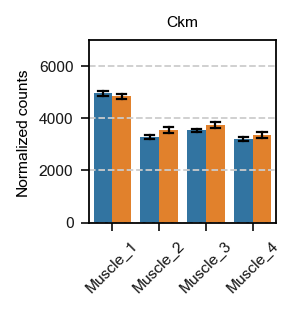

In [82]:
plt.figure(figsize=(1.5, 1.5))
sns.barplot(data=data_m, x="Sample", y="Ckm counts", hue="leiden", errorbar='se', errwidth=1, errcolor = 'black', capsize=0.2)
# Major ticks every 2000
major_ticks = np.arange(0, 6001, 2000)
plt.yticks(major_ticks)
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(rotation=45, fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Normalized counts', fontsize=7, fontname="Microsoft Sans Serif")
plt.title('Ckm', fontsize=7, fontname="Microsoft Sans Serif", style='italic')
plt.xlabel('')
plt.ylim(0, 7000)
plt.legend([],[], frameon=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('barplot-ckm-muscles.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

In [83]:
pvals=[]
pvals.append(ttest_ind(data_1.loc[data_1['leiden']=='Central']['Ttn counts'] , data_1.loc[data_1['leiden']=='Proximal-distal']['Ttn counts'])[1])
pvals.append(ttest_ind(data_2.loc[data_2['leiden']=='Central']['Ttn counts'] , data_2.loc[data_2['leiden']=='Proximal-distal']['Ttn counts'])[1])
pvals.append(ttest_ind(data_3.loc[data_3['leiden']=='Central']['Ttn counts'] , data_3.loc[data_3['leiden']=='Proximal-distal']['Ttn counts'])[1])
pvals.append(ttest_ind(data_4.loc[data_4['leiden']=='Central']['Ttn counts'] , data_4.loc[data_4['leiden']=='Proximal-distal']['Ttn counts'])[1])
print(pvals)
multipletests(pvals, alpha=0.05, method='fdr_bh')

[0.48906627789646395, 0.031418224209735356, 0.1382526325572813, 0.48967940605759663]


(array([False, False, False, False]),
 array([0.48967941, 0.1256729 , 0.27650527, 0.48967941]),
 0.012741455098566168,
 0.0125)

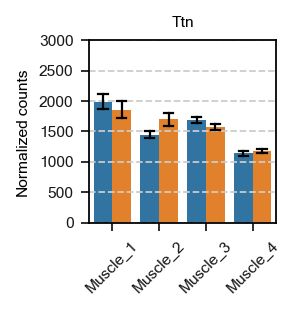

In [84]:
plt.figure(figsize=(1.5, 1.5))
sns.barplot(data=data_m, x="Sample", y="Ttn counts", hue="leiden", errorbar='se', errwidth=1, errcolor = 'black', capsize=0.2)
# Major ticks every 2000
major_ticks = np.arange(0, 3001, 500)
plt.yticks(major_ticks)
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(rotation=45, fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Normalized counts', fontsize=7, fontname="Microsoft Sans Serif")
plt.title('Ttn', fontsize=7, fontname="Microsoft Sans Serif", style='italic')
plt.xlabel('')
plt.ylim(0, 3000)
plt.legend([],[], frameon=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('barplot-ttn-muscles.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

In [85]:
pvals=[]
pvals.append(ttest_ind(data_1.loc[data_1['leiden']=='Central']['Prg4 counts'] , data_1.loc[data_1['leiden']=='Proximal-distal']['Prg4 counts'])[1])
pvals.append(ttest_ind(data_2.loc[data_2['leiden']=='Central']['Prg4 counts'] , data_2.loc[data_2['leiden']=='Proximal-distal']['Prg4 counts'])[1])
pvals.append(ttest_ind(data_3.loc[data_3['leiden']=='Central']['Prg4 counts'] , data_3.loc[data_3['leiden']=='Proximal-distal']['Prg4 counts'])[1])
pvals.append(ttest_ind(data_4.loc[data_4['leiden']=='Central']['Prg4 counts'] , data_4.loc[data_4['leiden']=='Proximal-distal']['Prg4 counts'])[1])
print(pvals)
multipletests(pvals, alpha=0.05, method='fdr_bh')

[6.1476354781086425e-06, 2.985825184643325e-07, 0.0006698510121122916, 0.0002150134345348445]


(array([ True,  True,  True,  True]),
 array([1.22952710e-05, 1.19433007e-06, 6.69851012e-04, 2.86684579e-04]),
 0.012741455098566168,
 0.0125)

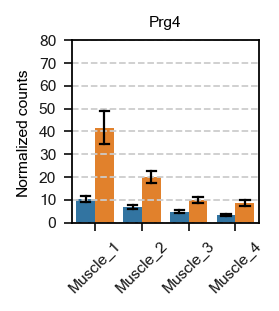

In [86]:
plt.figure(figsize=(1.5, 1.5))
sns.barplot(data=data_m, x="Sample", y="Prg4 counts", hue="leiden", errorbar='se', errwidth=1, errcolor = 'black', capsize=0.2)
# Major ticks every 2000
major_ticks = np.arange(0, 81, 10)
plt.yticks(major_ticks)
plt.grid(which='major', axis='y', linestyle='--')
plt.xticks(rotation=45, fontsize=7, fontname="Microsoft Sans Serif")
plt.yticks(fontsize=7, fontname="Microsoft Sans Serif")
plt.ylabel('Normalized counts', fontsize=7, fontname="Microsoft Sans Serif")
plt.title('Prg4', fontsize=7, fontname="Microsoft Sans Serif", style='italic')
plt.xlabel('')
plt.ylim(0, 80)
plt.legend([],[], frameon=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 7
plt.savefig('barplot-prg4-muscles.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

### Metabolism genes

In [87]:
#select the specific genes
gly_genes=['ENSMUSG00000030695_Aldoa_ProteinCoding', 'ENSMUSG00000000628_Hk2_ProteinCoding', 'ENSMUSG00000060600_Eno3_ProteinCoding'
          'ENSMUSG00000023456_Tpi1_ProteinCoding', 'ENSMUSG00000057666_Gapdh_ProteinCoding', 'ENSMUSG00000062070_Pgk1_ProteinCoding',
          'ENSMUSG00000032294_Pkm_ProteinCoding', 'ENSMUSG00000063229_Ldha_ProteinCoding', 'ENSMUSG00000032648_Pygm_ProteinCoding', 'ENSMUSG00000025791_Pgm1_ProteinCoding','ENSMUSG00000033400_Agl_ProteinCoding' ]
tca_genes=['ENSMUSG00000002010_Idh3g_ProteinCoding', 'ENSMUSG00000030541_Idh2_ProteinCoding', 'ENSMUSG00000032279_Idh3a_ProteinCoding',
          'ENSMUSG00000020456_Ogdh_ProteinCoding', 'ENSMUSG00000021748_Pdhb_ProteinCoding', 'ENSMUSG00000022110_Sucla2_ProteinCoding',
          'ENSMUSG00000021577_Sdha_ProteinCoding', 'ENSMUSG00000009863_Sdhb_ProteinCoding', 'ENSMUSG00000058076_Sdhc_ProteinCoding',
          'ENSMUSG00000020321_Mdh1_ProteinCoding', 'ENSMUSG00000019179_Mdh2_ProteinCoding']
list_g=[]
for gene in gly_genes:
    list_g.append(gene.split('_')[1])

list_t=[]
for gene in tca_genes:
    list_t.append(gene.split('_')[1])

list_f=['Dlat', 'Acss2', 'Pdhx', 'Pdhb','Acadl','Crat','Acadm','Etfb', 'Acadvl', 'Etfa','Mmut']
list_a=['Got1','Got2','Dlst','Cpt1b','Cat','Cpt2','Acadm','Acadl', 'Pdk4', 'Pdk2', 'Pdk1']
list_e1=['Ndufa3', 'Ndufs3', 'Ndufb3', 'Ndufb10', 'Aifm1', 'Ndufa1', 'Ndufs8', 'Ndufs7', 'Ndufa12', 'Ndufb8', 'Ndufs1', 'Ndufs2', 'Ndufs6', 'Ndufa5', 'Ndufb9', 'Ndufab1', 'Ndufb1.ps', 'Ndufa11', 'Ndufa9', 'Ndufa8', 'Ndufb5', 'Ndufa6']
list_e2=['Sdhb', 'Sdha', 'Sdhc', 'Sdhaf4']
list_e3=['Uqcrc2', 'Uqcrq', 'Uqcrc1', 'Uqcrh', 'Cycs', 'Uqcrfs1', 'Uqcrb', 'Cyc1']
list_e4=['Cox6c', 'Cox4i1', 'Cox7c', 'Cox8a', 'Cox5b', 'Cox6a2', 'Cox7a1', 'mt.Co3', 'Cox5a', 'Cycs', 'Cox8b']
list_e5=['Atp5a1', 'Atp5h', 'Atp5e', 'Atp5k', 'Atp5b', 'Atp5j2', 'Atp5j', 'mt.Atp8', 'Atp5pb', 'Atp5d', 'Atp5c1', 'Atp5o', 'Atp5g1']


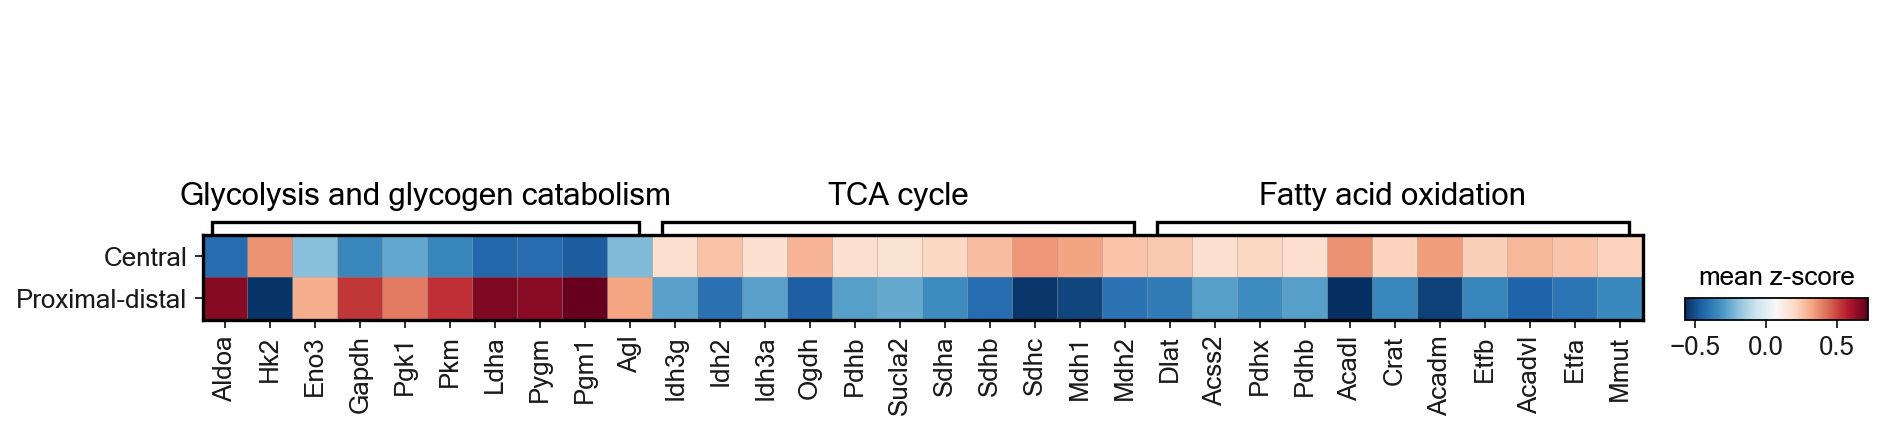

In [88]:
marker_genes_dict = {
    'Glycolysis and glycogen catabolism': list_g,
    'TCA cycle': list_t,
    'Fatty acid oxidation': list_f,
}

sc.set_figure_params(fontsize=14)
sc.pl.matrixplot(adata, marker_genes_dict, groupby='leiden',  cmap='RdBu_r', gene_symbols='gene_name', colorbar_title='mean z-score', var_group_rotation=0, show=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.savefig('heatmap-pathway1.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()



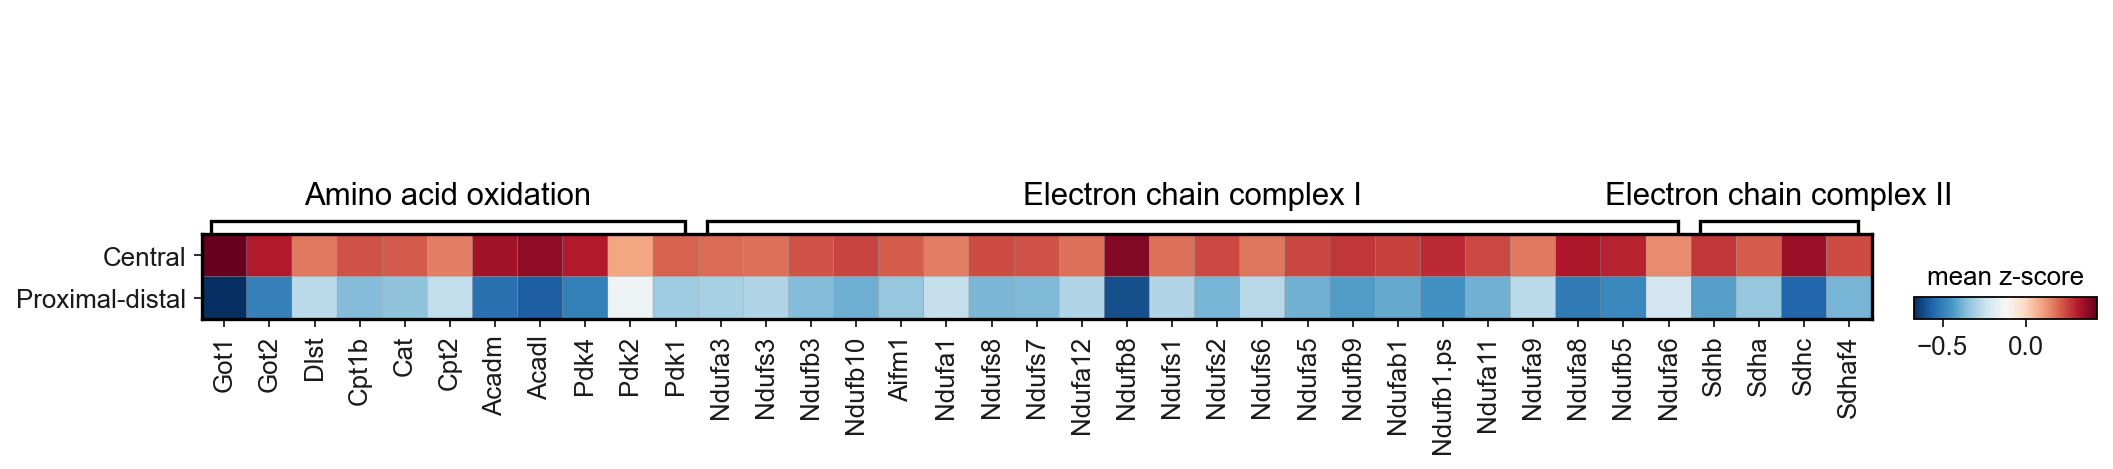

In [89]:
marker_genes_dict = {
    'Amino acid oxidation': list_a,
    'Electron chain complex I': list_e1,
    'Electron chain complex II': list_e2,
}
sc.set_figure_params(fontsize=14)
sc.pl.matrixplot(adata, marker_genes_dict, groupby='leiden',  cmap='RdBu_r', gene_symbols='gene_name', colorbar_title='mean z-score', var_group_rotation=0, show=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.savefig('heatmap-pathway2.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

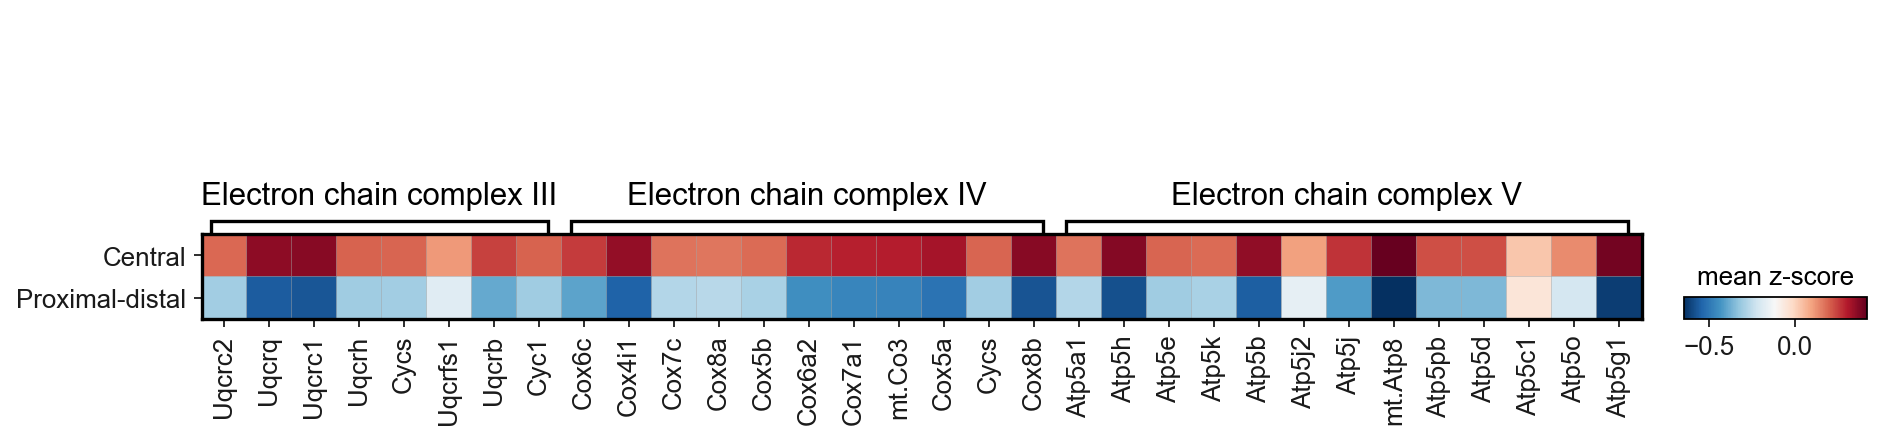

In [90]:
marker_genes_dict = {
    'Electron chain complex III': list_e3,
    'Electron chain complex IV': list_e4,
    'Electron chain complex V': list_e5
}
sc.set_figure_params(fontsize=14)
sc.pl.matrixplot(adata, marker_genes_dict, groupby='leiden',  cmap='RdBu_r', gene_symbols='gene_name', colorbar_title='mean z-score', var_group_rotation=0, show=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.savefig('heatmap-pathway3.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

In [91]:
gene_ids = adata.var.index.values 
clusters = adata.obs['leiden'].cat.categories 
obs = adata[:,gene_ids].X.toarray() 
obs = pd.DataFrame(obs,columns=gene_ids,index=adata.obs['leiden'])
marker_genes = list_g+list_t+list_f+list_a+list_e1+list_e2+list_e3+list_e4+list_e5
out = [id for id in obs.columns if any(g in id for g in marker_genes)]
average_obs = obs.groupby(level=0).mean() 
average_obs=average_obs[out]
average_obs.T.to_excel("cluster-metabolism_average.xlsx") 
average_obs

ENSMUSG00000000088_Cox5a_ProteinCoding  \
leiden                                                    
Central                                        0.326383   
Proximal-distal                               -0.506625   

                 ENSMUSG00000000168_Dlat_ProteinCoding  \
leiden                                                   
Central                                       0.246040   
Proximal-distal                              -0.381913   

                 ENSMUSG00000000399_Ndufa9_ProteinCoding  \
leiden                                                     
Central                                         0.170922   
Proximal-distal                                -0.265312   

                 ENSMUSG00000000563_Atp5pb_ProteinCoding  \
leiden                                                     
Central                                         0.227440   
Proximal-distal                                -0.353041   

                 ENSMUSG00000000628_Hk2_ProteinCoding  \
leiden                                                  
Central                                      0.361253   
Proximal-distal                             -0.560750   

                 ENSMUSG00000002010_Idh3g_ProteinCoding  \
leiden                                                    
Central                                        0.179334   
Proximal-distal                               -0.278370   

                 ENSMUSG00000002379_Ndufa11_ProteinCoding  \
leiden                                                      
Central                                          0.245767   
Proximal-distal                                 -0.381490   

                 ENSMUSG00000003072_Atp5d_ProteinCoding  \
leiden                                                    
Central                                        0.227657   
Proximal-distal                               -0.353378   

                 ENSMUSG00000004610_Etfb_ProteinCoding  \
leiden                                                   
Central                                       0.228169   
Proximal-distal                              -0.354172   

                 ENSMUSG00000004789_Dlst_ProteinCoding  ...  \
leiden                                                  ...   
Central                                       0.171790  ...   
Proximal-distal                              -0.266659  ...   

                 ENSMUSG00000062908_Acadm_ProteinCoding  \
leiden                                                    
Central                                        0.340868   
Proximal-distal                               -0.529109   

                 ENSMUSG00000063229_Ldha_ProteinCoding  \
leiden                                                   
Central                                      -0.436097   
Proximal-distal                               0.676927   

                 ENSMUSG00000063694_Cycs_ProteinCoding  \
leiden                                                   
Central                                       0.192667   
Proximal-distal                              -0.299065   

                 ENSMUSG00000063882_Uqcrh_ProteinCoding  \
leiden                                                    
Central                                        0.196739   
Proximal-distal                               -0.305386   

                 ENSMUSG00000064356_mt.Atp8_ProteinCoding  \
leiden                                                      
Central                                          0.416413   
Proximal-distal                                 -0.646372   

                 ENSMUSG00000064358_mt.Co3_ProteinCoding  \
leiden                                                     
Central                                         0.303438   
Proximal-distal                                -0.471008   

                 ENSMUSG00000074211_Sdhaf1_ProteinCoding  \
leiden                                                     
Central                                        -0.022854   
Proximal-distal          

### Fiber type hetereogeneity

In [92]:
genes=[]
for index in data_deg_scaled_zscores['Muscle_1'].index:
    if 'Myh' in index or 'Myl' in index or 'Tnn' in index or 'Myo' in index or 'Myb' in index or 'Lmod' in index or 'Actn' in index:
        genes.append(index)
        print(index)
data_deg_sarc={}
for key in data_deg:
    data_deg_sarc[key]=data_deg_scaled_zscores[key].loc[genes]

ENSMUSG00000033196_Myh2_ProteinCoding
ENSMUSG00000056328_Myh1_ProteinCoding
ENSMUSG00000052374_Actn2_ProteinCoding
ENSMUSG00000018830_Myh11_ProteinCoding
ENSMUSG00000059741_Myl3_ProteinCoding
ENSMUSG00000029683_Lmod2_ProteinCoding
ENSMUSG00000022836_Mylk_ProteinCoding
ENSMUSG00000025716_Myo3a_ProteinCoding
ENSMUSG00000030672_Mylpf_ProteinCoding
ENSMUSG00000006457_Actn3_ProteinCoding
ENSMUSG00000061816_Myl1_ProteinCoding
ENSMUSG00000038670_Mybpc2_ProteinCoding
ENSMUSG00000057003_Myh4_ProteinCoding
ENSMUSG00000031097_Tnni2_ProteinCoding
ENSMUSG00000017300_Tnnc2_ProteinCoding
ENSMUSG00000061723_Tnnt3_ProteinCoding
ENSMUSG00000024049_Myom1_ProteinCoding
ENSMUSG00000044951_Mylk4_ProteinCoding
ENSMUSG00000020061_Mybpc1_ProteinCoding
ENSMUSG00000031461_Myom2_ProteinCoding
ENSMUSG00000049173_Myoz3_ProteinCoding


In [93]:
adata_plot=adata[adata.obs["leiden"] == "Central"]
ann=pd.DataFrame(adata_plot.obs)
df_c=adata[adata.obs["leiden"] == "Central"].to_df().T
df_a=adata[adata.obs["leiden"] == "Proximal-distal"].to_df().T
df_plot=pd.concat([df_c, df_a], axis=1).loc[genes]
df_plot

0         1         4  \
gene_id                                                                 
ENSMUSG00000033196_Myh2_ProteinCoding   -0.618054 -1.705087 -0.832863   
ENSMUSG00000056328_Myh1_ProteinCoding    0.548705 -1.806578 -0.081532   
ENSMUSG00000052374_Actn2_ProteinCoding  -2.607302 -1.939021 -0.184370   
ENSMUSG00000018830_Myh11_ProteinCoding  -1.711675 -0.949972  0.394105   
ENSMUSG00000059741_Myl3_ProteinCoding   -1.500566 -1.535384 -0.214902   
ENSMUSG00000029683_Lmod2_ProteinCoding  -0.986463 -1.440333 -0.994558   
ENSMUSG00000022836_Mylk_ProteinCoding    0.631363 -0.027299 -0.778343   
ENSMUSG00000025716_Myo3a_ProteinCoding   0.401230 -0.843935 -0.507806   
ENSMUSG00000030672_Mylpf_ProteinCoding   1.783196  0.130182  0.008487   
ENSMUSG00000006457_Actn3_ProteinCoding   0.263447 -0.318597  0.718147   
ENSMUSG00000061816_Myl1_ProteinCoding    0.423376  0.877152 -0.091498   
ENSMUSG00000038670_Mybpc2_ProteinCoding  1.068999 -0.111610 -0.689479   
ENSMUSG00000057003_Myh4_ProteinCoding   -0.550119 -0.698019 -0.297079   
ENSMUSG00000031097_Tnni2_ProteinCoding   2.200748 -1.107665  1.239106   
ENSMUSG00000017300_Tnnc2_ProteinCoding   1.288327  0.201472  0.600601   
ENSMUSG00000061723_Tnnt3_ProteinCoding   0.845042  1.019120  0.535085   
ENSMUSG00000024049_Myom1_ProteinCoding   0.685376 -1.728906 -0.841166   
ENSMUSG00000044951_Mylk4_ProteinCoding  -1.209138 -0.710758 -0.338450   
ENSMUSG00000020061_Mybpc1_ProteinCoding -1.201319 -0.608143 -1.355261   
ENSMUSG00000031461_Myom2_ProteinCoding  -0.483228 -1.198789  0.128396   
ENSMUSG00000049173_Myoz3_ProteinCoding   0.993767 -1.322875 -1.427371   

                                                5         6         7  \
gene_id                                                                 
ENSMUSG00000033196_Myh2_ProteinCoding   -0.425516 -0.614557  0.241535   
ENSMUSG00000056328_Myh1_ProteinCoding   -0.338300 -0.662994 -0.493166   
ENSMUSG00000052374_Actn2_ProteinCoding   1.130215  0.027126 -0.965779   
ENSMUSG00000018830_Myh11_ProteinCoding   4.067545  1.606453  1.560427   
ENSMUSG00000059741_Myl3_ProteinCoding    0.086346 -1.187604  0.742900   
ENSMUSG00000029683_Lmod2_ProteinCoding  -1.003176  0.555774  0.755711   
ENSMUSG00000022836_Mylk_ProteinCoding    3.465047  0.235727  2.326370   
ENSMUSG00000025716_Myo3a_ProteinCoding   0.270554 -0.412124 -0.280756   
ENSMUSG00000030672_Mylpf_ProteinCoding   0.583348 -1.108661 -1.209743   
ENSMUSG00000006457_Actn3_ProteinCoding   0.985042 -0.529361 -0.815213   
ENSMUSG00000061816_Myl1_ProteinCoding    0.274897  0.161653 -0.482758   
ENSMUSG00000038670_Mybpc2_ProteinCoding  0.264850  1.114248  0.232780   
ENSMUSG00000057003_Myh4_ProteinCoding   -0.400136 -1.670399  0.138712   
ENSMUSG00000031097_Tnni2_ProteinCoding  -0.148908 -2.378497 -1.116077   
ENSMUSG00000017300_Tnnc2_ProteinCoding  -0.261876 -1.094507 -1.269422   
ENSMUSG00000061723_Tnnt3_ProteinCoding  -0.439432 -0.777330 -0.405150   
ENSMUSG00000024049_Myom1_ProteinCoding  -0.290880 -0.961691  0.270065   
ENSMUSG00000044951_Mylk4_ProteinCoding  -1.290822 -0.759754 -0.312860   
ENSMUSG00000020061_Mybpc1_ProteinCoding  1.102461  0.313170  0.556492   
ENSMUSG00000031461_Myom2_ProteinCoding  -0.856513 -0.174446  0.772698   
ENSMUSG00000049173_Myoz3_ProteinCoding   0.501973 -0.979920  1.273520   

                                                8         9        10  \
gene_id                                                                 
ENSMUSG00000033196_Myh2_ProteinCoding   -0.070576  0.135178  0.075332   
ENSMUSG00000056328_Myh1_ProteinCoding    0.634270  0.472503 -0.988221   
ENSMUSG00000052374_Actn2_ProteinCoding   1.025054  0.208788 -0.663375   
ENSMUSG00000018830_Myh11_ProteinCoding   1.362704  0.425077 -0.767256   
ENSMUSG00000059741_Myl3_ProteinCoding    0.457391  0.218988  0.103327   
ENSMUSG00000029683_Lmod2_ProteinCoding  -0.229221 -0.583984  0.210059   
ENSMUSG00000022836_Mylk_ProteinCoding    1.472873  1.285523 -1.010847   
ENSMUSG00000025716_Myo3a_Protei

In [94]:
genes_names=[]
for gene in genes:
    genes_names.append(gene.split('_')[1])
genes_names.remove('Myh11')
genes_names

['Myh2',
 'Myh1',
 'Actn2',
 'Myl3',
 'Lmod2',
 'Mylk',
 'Myo3a',
 'Mylpf',
 'Actn3',
 'Myl1',
 'Mybpc2',
 'Myh4',
 'Tnni2',
 'Tnnc2',
 'Tnnt3',
 'Myom1',
 'Mylk4',
 'Mybpc1',
 'Myom2',
 'Myoz3']

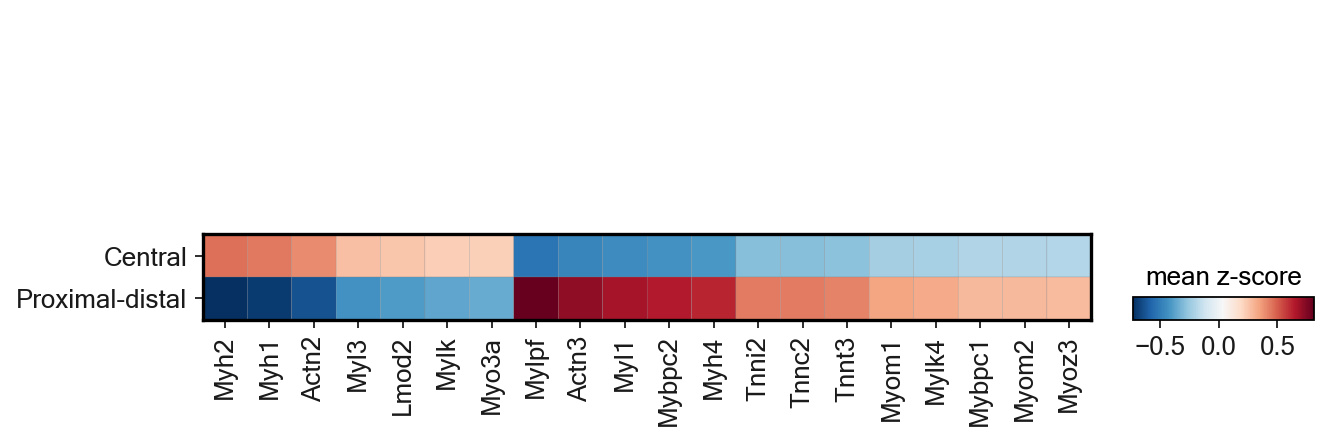

In [95]:
sc.set_figure_params(scanpy=True, fontsize=14)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Microsoft Sans Serif"
plt.rcParams["font.size"] = 14
sc.pl.matrixplot(adata, genes_names, groupby='leiden',  cmap='RdBu_r', gene_symbols='gene_name', colorbar_title='mean z-score', 
                 show=False)
plt.savefig('heatmap-sarcomer-genes.svg', format = 'svg', dpi=300, bbox_inches='tight')  
plt.show()
plt.close()

In [96]:
gene_ids = adata.var.index.values 
clusters = adata.obs['leiden'].cat.categories 
obs = adata[:,gene_ids].X.toarray() 
obs = pd.DataFrame(obs,columns=gene_ids,index=adata.obs['leiden'])
marker_genes = genes
out = [id for id in obs.columns if any(g in id for g in marker_genes)]
average_obs = obs.groupby(level=0).mean() 
average_obs=average_obs[out]
average_obs.T.to_excel("cluster-sarcomere_average.xlsx") 
average_obs

ENSMUSG00000006457_Actn3_ProteinCoding  \
leiden                                                    
Central                                       -0.463035   
Proximal-distal                                0.718741   

                 ENSMUSG00000017300_Tnnc2_ProteinCoding  \
leiden                                                    
Central                                       -0.283238   
Proximal-distal                                0.439653   

                 ENSMUSG00000018830_Myh11_ProteinCoding  \
leiden                                                    
Central                                        0.262389   
Proximal-distal                               -0.407291   

                 ENSMUSG00000020061_Mybpc1_ProteinCoding  \
leiden                                                     
Central                                        -0.187552   
Proximal-distal                                 0.291125   

                 ENSMUSG00000022836_Mylk_ProteinCoding  \
leiden                                                   
Central                                       0.231762   
Proximal-distal                              -0.359751   

                 ENSMUSG00000024049_Myom1_ProteinCoding  \
leiden                                                    
Central                                       -0.219863   
Proximal-distal                                0.341280   

                 ENSMUSG00000025716_Myo3a_ProteinCoding  \
leiden                                                    
Central                                        0.221875   
Proximal-distal                               -0.344403   

                 ENSMUSG00000029683_Lmod2_ProteinCoding  \
leiden                                                    
Central                                        0.253484   
Proximal-distal                               -0.393468   

                 ENSMUSG00000030672_Mylpf_ProteinCoding  \
leiden                                                    
Central                                       -0.520526   
Proximal-distal                                0.807980   

                 ENSMUSG00000031097_Tnni2_ProteinCoding  ...  \
leiden                                                   ...   
Central                                       -0.282634  ...   
Proximal-distal                                0.438715  ...   

                 ENSMUSG00000033196_Myh2_ProteinCoding  \
leiden                                                   
Central                                       0.466473   
Proximal-distal                              -0.724077   

                 ENSMUSG00000038670_Mybpc2_ProteinCoding  \
leiden                                                     
Central                                        -0.419479   
Proximal-distal                                 0.651131   

                 ENSMUSG00000044951_Mylk4_ProteinCoding  \
leiden                                                    
Central                                       -0.213823   
Proximal-distal                                0.331904   

                 ENSMUSG00000049173_Myoz3_ProteinCoding  \
leiden                                                    
Central                                       -0.182992   
Proximal-distal                                0.284048   

                 ENSMUSG00000052374_Actn2_ProteinCoding  \
leiden                                                    
Central                                        0.403958   
Proximal-distal                               -0.627039   

                 ENSMUSG00000056328_Myh1_ProteinCoding  \
leiden                                                   
Central                                       0.445048   
Proximal-distal                              -0.690821   

                 ENSMUSG00000057003_Myh4_ProteinCoding  \
leiden                                                   
Central                                      -0.403282   
Proximal-distal                    